In [ ]:
data.list <- list()

nagasa <- length(list.files(path)[grep("N-total", list.files(path))])

# data.listに格納
for (i in 1:nagasa){
    load(paste0(path,list.files(path)[grep("N-total", list.files(path))][i]))
    a <- sobj
    data.list <- c(data.list, a)
}

# [[1]]のみ例示
data.list[[1]]

# ribosomal protein, MT, MALATの発現をすべて0にする
# これらの遺伝子によりクラスターができるのを防ぐため
remove_some_genes <- function(pbmc, genes=c("^RPS","^RPL","^MT-","MALAT1","NEAT")) {
    pbmc_sce <- as.SingleCellExperiment(pbmc)

    for (gene in genes){
        counts(pbmc_sce)[rownames(pbmc_sce)[grepl(gene, rownames(pbmc_sce))],] = 0
    }

    return (as.Seurat(pbmc_sce, counts = "counts"))
}

UMAP <- function(data.integrated, dims=1:30){
    data.integrated <- RunPCA(data.integrated, verbose = FALSE)
    data.integrated <- RunUMAP(data.integrated, dims = 1:30, verbose = FALSE, umap.method = 'umap-learn', metric = 'correlation')
    data.integrated <- FindNeighbors(data.integrated, dims = 1:30, verbose = FALSE)
    data.integrated <- FindClusters(data.integrated, verbose = FALSE)
    return (data.integrated)
}

for (i in 1:nagasa){
    data.list[[i]][['percent.mt']] <- PercentageFeatureSet(data.list[[i]], pattern='^MT-')
    data.list[[i]] <- subset(data.list[[i]], subset= nFeature_RNA > 200 & percent.mt < 20)
    data.list[[i]] <- remove_some_genes(data.list[[i]], genes=c("^RPS","^RPL","^MT-","MALAT1","NEAT"))
    data.list[[i]] <- NormalizeData(data.list[[i]]) # method = LogNormalize, scale.factor=10000
}

a <- list.files(path)[grep("N-total", list.files(path))]

data.integrated <- merge(data.list[[1]],y=data.list[[2]], project='NormalStomach')
for (i in 3:nagasa){
data.integrated <- merge(data.integrated,y=data.list[[i]],
                        project='NormalStomach')
    }

data.integrated <- remove_some_genes(data.integrated)

# STEMID stemっぽさを評価する

# Memo

# meta.dataにNormal or Tumorの情報を付与
data.integrated@meta.data["NT"] <- c(rep(FALSE,dim(data.integrated@meta.data)[1]))

for (i in 1:dim(data.integrated@meta.data)[1]){
   if (grepl("N",data.integrated@meta.data$orig.ident[i])) {data.integrated@meta.data$NT[i] = "N"}
    else {data.integrated@meta.data$NT[i] = "T"}
}

data.integrated@meta.data %>% head

# Memo 終わり

In [3]:
library(Seurat)
library(Matrix)
library(ggplot2)
library(cowplot)
library(dplyr)
library(enrichR)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Welcome to enrichR
Checking connection ... Connection is Live!


In [4]:
library(schex)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:Matrix’:

    which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, M

In [5]:
path = '/data/share/scRNAseq/results/human_STAD/soupx/'

In [16]:
list.files(path)

[1] "10N-Bcell.Rds"  "10N-total.Rds"  "10T-Bcell.Rds"  "10T-total.Rds" 
 [5] "11N-Bcell.Rds"  "11N-total.Rds"  "11T1-Bcell.Rds" "11T1-total.Rds"
 [9] "11T2-Bcell.Rds" "11T2-total.Rds" "12N-Bcell.Rds"  "12N-total.Rds" 
[13] "12T-Bcell.Rds"  "12T-total.Rds"  "14N-Bcell.Rds"  "14N-total.Rds" 
[17] "14T-Bcell.Rds"  "14T-total.Rds"  "15N-Bcell.Rds"  "15N-total.Rds" 
[21] "15T-Bcell.Rds"  "15T-total.Rds"  "16N-Bcell.Rds"  "16N-total.Rds" 
[25] "16T-Bcell.Rds"  "16T-total.Rds"  "17N-Bcell.Rds"  "17N-total.Rds" 
[29] "17T-Bcell.Rds"  "17T-total.Rds"  "18N-Bcell.Rds"  "18N-total.Rds" 
[33] "18T-Bcell.Rds"  "18T-total.Rds"  "1T-Bcell.Rds"   "6N-Bcell.Rds"  
[37] "6N-total.Rds"   "6T-Bcell.Rds"   "6T-total.Rds"   "7N-Bcell.Rds"  
[41] "7T-Bcell.Rds"   "8N-Bcell.Rds"   "8N-total.Rds"   "8T-Bcell.Rds"  
[45] "8T-total.Rds"   "9N-Bcell.Rds"   "9N-total.Rds"   "9T-Bcell.Rds"  
[49] "9T-total.Rds"

In [6]:
data.list <- list()

In [7]:
nagasa <- length(list.files(path)[grep("N-total", list.files(path))])

In [8]:
# data.listに格納
for (i in 1:nagasa){
    load(paste0(path,list.files(path)[grep("N-total", list.files(path))][i]))
    a <- sobj
    data.list <- c(data.list, a)
}

In [9]:
# [[1]]のみ例示
data.list[[1]]

An object of class Seurat 
33538 features across 2669 samples within 1 assay 
Active assay: RNA (33538 features)

In [10]:
# ribosomal protein, MT, MALATの発現をすべて0にする
# これらの遺伝子によりクラスターができるのを防ぐため
remove_some_genes <- function(pbmc, genes=c("^RPS","^RPL","^MT-","MALAT1","NEAT")) {
    pbmc_sce <- as.SingleCellExperiment(pbmc)

    for (gene in genes){
        counts(pbmc_sce)[rownames(pbmc_sce)[grepl(gene, rownames(pbmc_sce))],] = 0
    }

    return (as.Seurat(pbmc_sce, counts = "counts"))
}

In [11]:
UMAP <- function(data.integrated, dims=1:30){
    data.integrated <- RunPCA(data.integrated, verbose = FALSE)
    data.integrated <- RunUMAP(data.integrated, dims = 1:30, verbose = FALSE, umap.method = 'umap-learn', metric = 'correlation')
    data.integrated <- FindNeighbors(data.integrated, dims = 1:30, verbose = FALSE)
    data.integrated <- FindClusters(data.integrated, verbose = FALSE)
    return (data.integrated)
}

In [12]:
for (i in 1:nagasa){
    data.list[[i]][['percent.mt']] <- PercentageFeatureSet(data.list[[i]], pattern='^MT-')
    data.list[[i]] <- subset(data.list[[i]], subset= nFeature_RNA > 200 & percent.mt < 20)
    data.list[[i]] <- remove_some_genes(data.list[[i]], genes=c("^RPS","^RPL","^MT-","MALAT1","NEAT"))
    data.list[[i]] <- NormalizeData(data.list[[i]]) # method = LogNormalize, scale.factor=10000
}

In [13]:
a <- list.files(path)[grep("N-total", list.files(path))]

In [14]:
data.integrated <- merge(data.list[[1]],y=data.list[[2]], project='NormalStomach')
for (i in 3:nagasa){
data.integrated <- merge(data.integrated,y=data.list[[i]],
                        project='NormalStomach')
    }

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”

In [15]:
data.integrated <- remove_some_genes(data.integrated)

# ここをみる

In [16]:
data.integrated[['percent.mt']] <- PercentageFeatureSet(data.integrated, pattern='^MT-')

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”

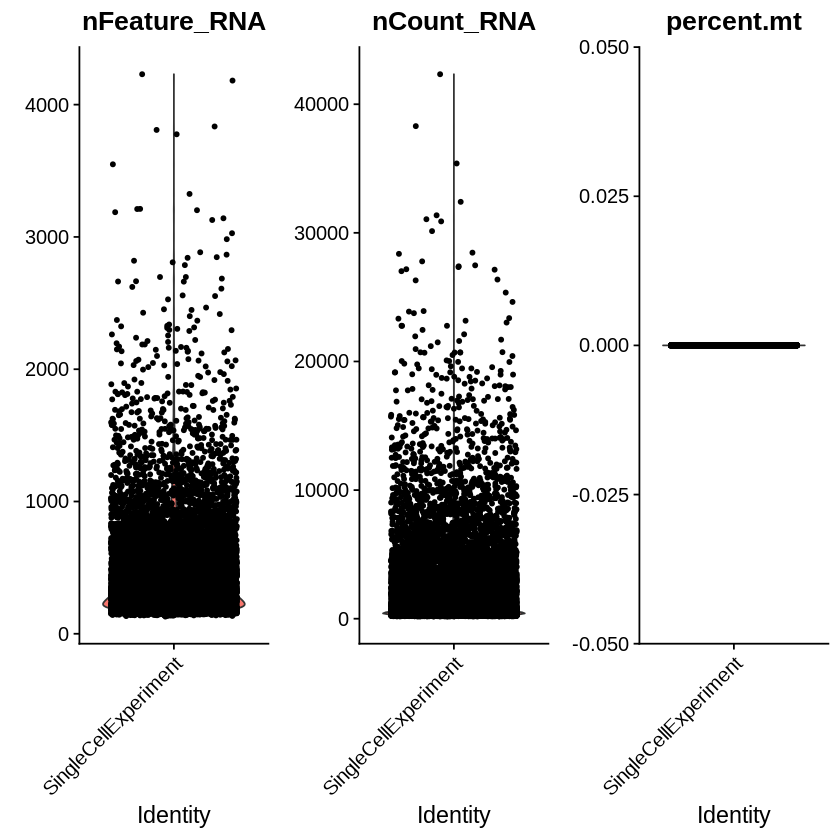

In [17]:
VlnPlot(data.integrated, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [18]:
Idents(data.integrated) <- 'orig.ident'

In [19]:
unique(data.integrated[['orig.ident']])

orig.ident
AAACCTGAGGCTAGCA_1_1_1_1_1 10N-total 
AAACCTGCACTTGGAT_2_1_1_1_1 11N-total 
AAACCTGAGTGCAAGC_1_1_1_1   12N-total 
AAACCTGTCCATGAAC_2_1_1_1   14N-total 
AAACCTGAGGATGTAT_1_1_1     15N-total 
AAACCTGGTCTGATCA_2_1_1     16N-total 
AAACCTGAGCACCGTC_1_1       17N-total 
AAAGCAAGTTAAGGGC_2_1       18N-total 
AAACCTGAGCGGATCA_1         6N-total  
AAACCTGAGGGTTTCT_2         8N-total  
AAACCTGAGTCGAGTG           9N-total

In [19]:
data.integrated

An object of class Seurat 
33538 features across 19663 samples within 1 assay 
Active assay: RNA (33538 features)

In [20]:
reticulate::import(module = "umap")

Module(umap)

In [21]:
DefaultAssay(data.integrated) <- 'RNA'

In [22]:
data.integrated <- FindVariableFeatures(object = data.integrated)
data.integrated <- ScaleData(object = data.integrated)

Centering and scaling data matrix


In [23]:
data.integrated <- RunPCA(data.integrated, verbose = FALSE)
data.integrated <- RunUMAP(data.integrated, dims = 1:30, verbose = FALSE, umap.method = 'umap-learn', metric = 'correlation')
data.integrated <- FindNeighbors(data.integrated, dims = 1:30, verbose = FALSE)
data.integrated <- FindClusters(data.integrated, verbose = FALSE)

# やること

## ミトコンドリアRNAの発現が高い(>20%?)細胞を除く
## そのうえでMergeする
## merge後、NormalizeData->ScaleData
## UMAP

### percent.mt < 20とすると細胞数は38416 -> 19663に減った

## 

In [6]:
load('N-stomach-all.RData')

In [9]:
data.integrated

An object of class Seurat 
33538 features across 19663 samples within 1 assay 
Active assay: RNA (33538 features)
 2 dimensional reductions calculated: pca, umap

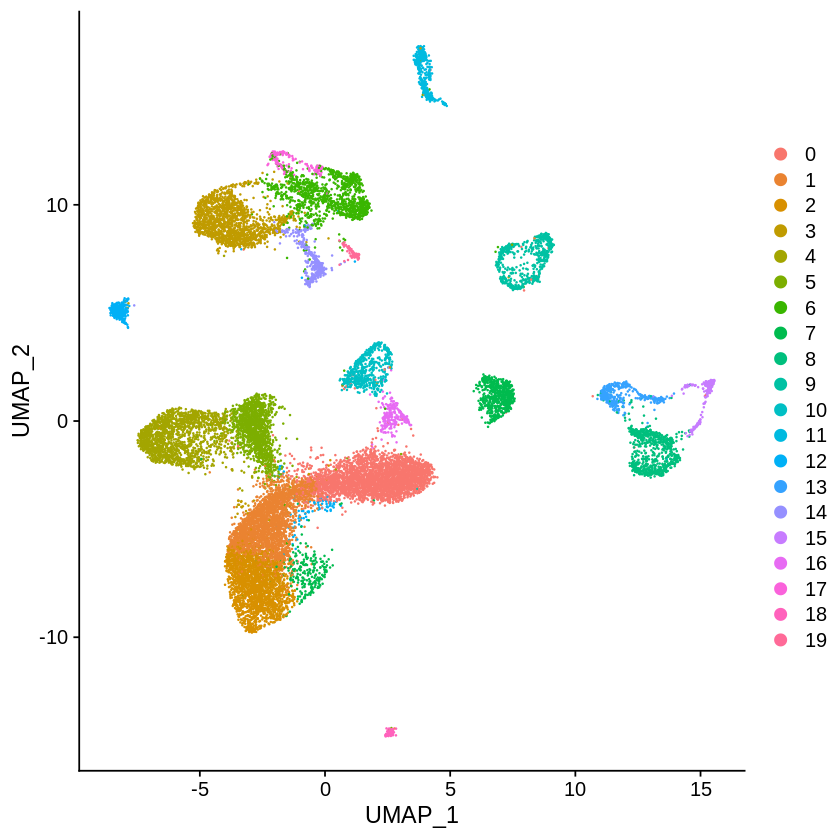

In [8]:
DimPlot(data.integrated)

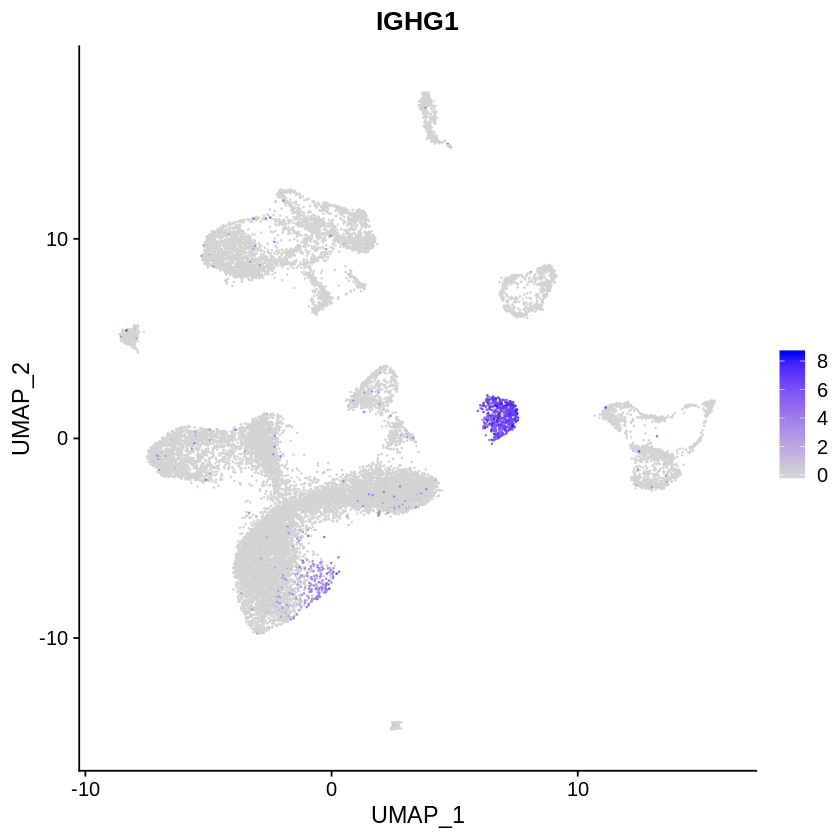

In [26]:
FeaturePlot(data.integrated2, features = 'IGHG1')

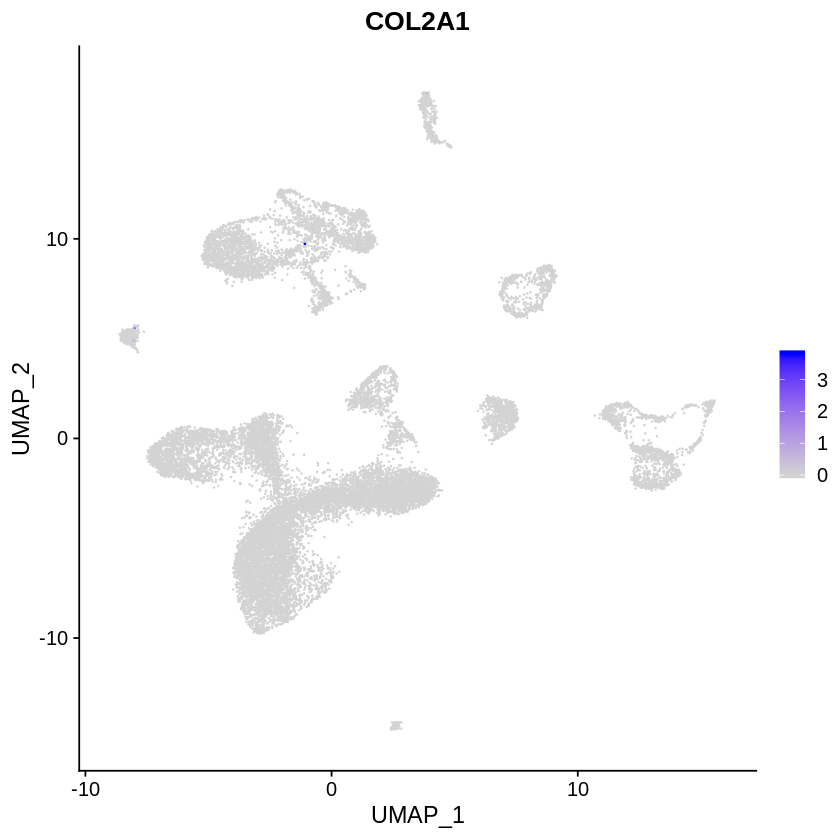

In [10]:
FeaturePlot(data.integrated,features='COL2A1')

In [42]:
data.integrated2 <- data.integrated

In [43]:
new.cluster.ids <- c("B cells",'Plasma cells','Plasma cells','Epithelial cells','T cells',
'T cells','Epithelial cells','Plasma cells','Fibroblasts','Macrophages','B cells',
'Endothelial cells','Parietal cells','Fibroblasts','Epithelial cells','Fibroblasts',
'B cells','Epithelial cells','mast cells','Epithelial cells')
names(new.cluster.ids) <- levels(data.integrated2)
data.integrated2 <- RenameIdents(data.integrated2, new.cluster.ids)
DimPlot(data.integrated2, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

ERROR: Error in value[[3L]](cond): could not open file '/tmp/RtmpjEo4IT/filebb63a65878f.png'


plot without title

In [45]:
table(Idents(data.integrated2))


          B cells      Plasma cells  Epithelial cells           T cells 
             4187              5789              3567              3150 
      Fibroblasts       Macrophages Endothelial cells    Parietal cells 
             1387               624               426               381 
       mast cells 
              152 

In [46]:
stomach.celltype.markers <- FindAllMarkers(data.integrated2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster B cells
Calculating cluster Plasma cells
Calculating cluster Epithelial cells
Calculating cluster T cells
Calculating cluster Fibroblasts
Calculating cluster Macrophages
Calculating cluster Endothelial cells
Calculating cluster Parietal cells
Calculating cluster mast cells


In [48]:
write.csv(stomach.celltype.markers,'./seurat_object/stomach-all-celltype-marker.csv')

In [49]:
stomach.celltype.markers %>% head

p_val avg_logFC pct.1 pct.2 p_val_adj cluster gene    
MS4A1    0     2.582867  0.497 0.020 0         B cells MS4A1   
HLA-DRA  0     2.187971  0.809 0.110 0         B cells HLA-DRA 
CD74     0     2.187969  0.793 0.206 0         B cells CD74    
VPREB3   0     2.135033  0.386 0.028 0         B cells VPREB3  
HLA-DPB1 0     2.096962  0.562 0.068 0         B cells HLA-DPB1
CD37     0     2.019845  0.541 0.087 0         B cells CD37

In [51]:
unique(stomach.celltype.markers$cluster)

[1] B cells           Plasma cells      Epithelial cells  T cells          
[5] Fibroblasts       Macrophages       Endothelial cells Parietal cells   
[9] mast cells       
9 Levels: B cells Plasma cells Epithelial cells T cells ... mast cells

In [54]:
for(i in 1:length(unique(stomach.celltype.markers$cluster))){
    print(stomach.celltype.markers %>% filter(cluster==unique(stomach.celltype.markers$cluster)[i])    %>% filter(p_val_adj<0.05))
    print(' ')
        print(' ')
        print(' ')
}

           p_val avg_logFC pct.1 pct.2     p_val_adj cluster       gene
1   0.000000e+00 2.5828666 0.497 0.020  0.000000e+00 B cells      MS4A1
2   0.000000e+00 2.1879706 0.809 0.110  0.000000e+00 B cells    HLA-DRA
3   0.000000e+00 2.1879692 0.793 0.206  0.000000e+00 B cells       CD74
4   0.000000e+00 2.1350327 0.386 0.028  0.000000e+00 B cells     VPREB3
5   0.000000e+00 2.0969619 0.562 0.068  0.000000e+00 B cells   HLA-DPB1
6   0.000000e+00 2.0198450 0.541 0.087  0.000000e+00 B cells       CD37
7   0.000000e+00 1.9821165 0.272 0.034  0.000000e+00 B cells      CD79B
8   0.000000e+00 1.8819144 0.329 0.071  0.000000e+00 B cells     SMIM14
9   0.000000e+00 1.8246862 0.446 0.074  0.000000e+00 B cells   HLA-DRB1
10  0.000000e+00 1.8243691 0.658 0.139  0.000000e+00 B cells      CXCR4
11  0.000000e+00 1.7857485 0.398 0.061  0.000000e+00 B cells   HLA-DPA1
12  0.000000e+00 1.7484153 0.564 0.111  0.000000e+00 B cells       CD52
13  0.000000e+00 1.7424262 0.276 0.020  0.000000e+00 B cells    

In [28]:
data_schex <- make_hexbin(as.SingleCellExperiment(data.integrated), nbins=60, dimension_reduction = 'UMAP')

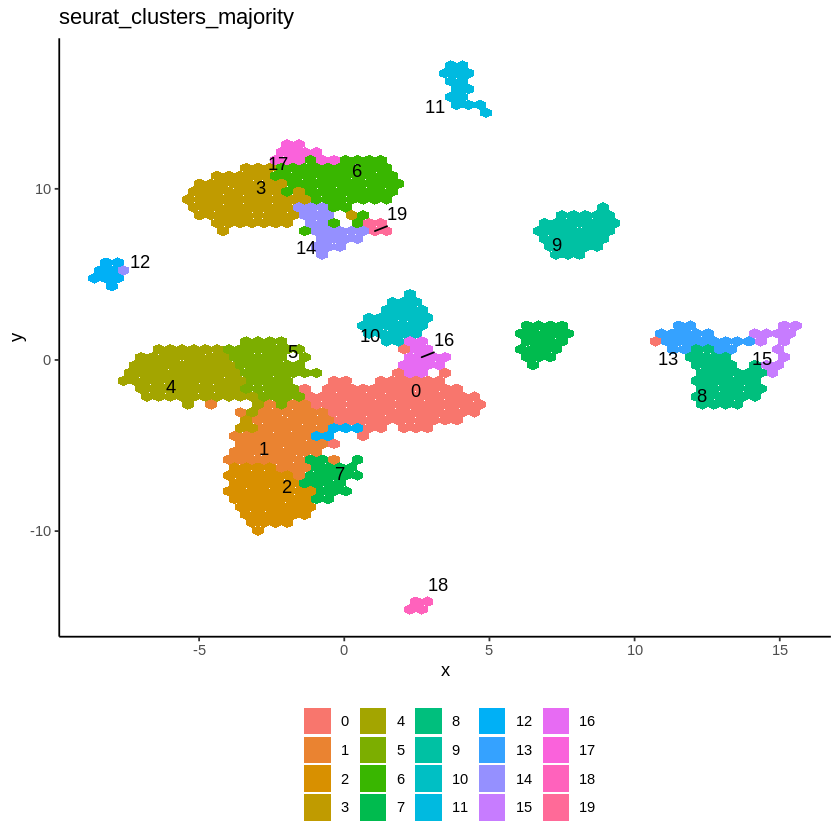

In [29]:
label_df <- make_hexbin_label(data_schex, col = "seurat_clusters")
pp <- plot_hexbin_meta(data_schex, col = "seurat_clusters", action = "majority")
pp + ggrepel::geom_label_repel(data = label_df, aes(x = x, y = y, label = label), colour = "black", 
    label.size = NA, fill = NA)

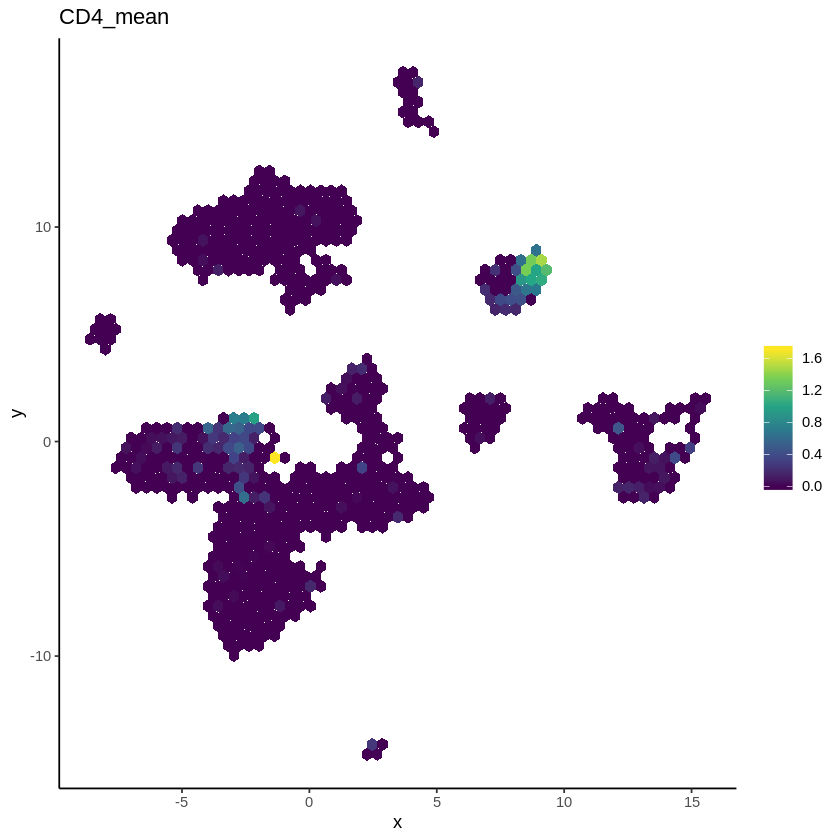

In [27]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='CD4',action='mean')
plot(p1)

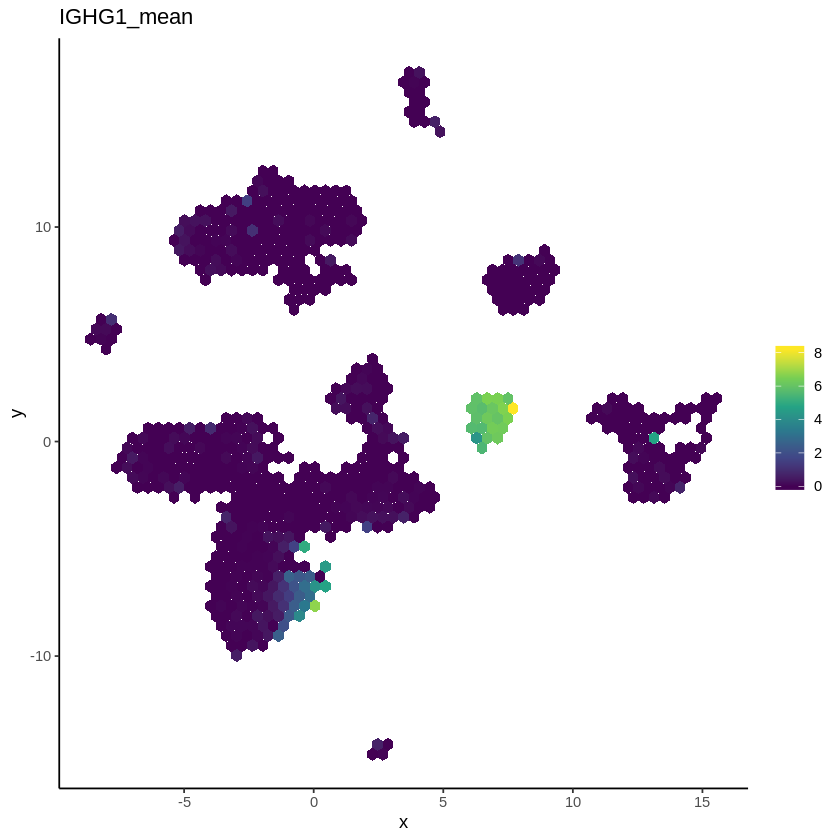

In [30]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='IGHG1',action='mean')
plot(p1)

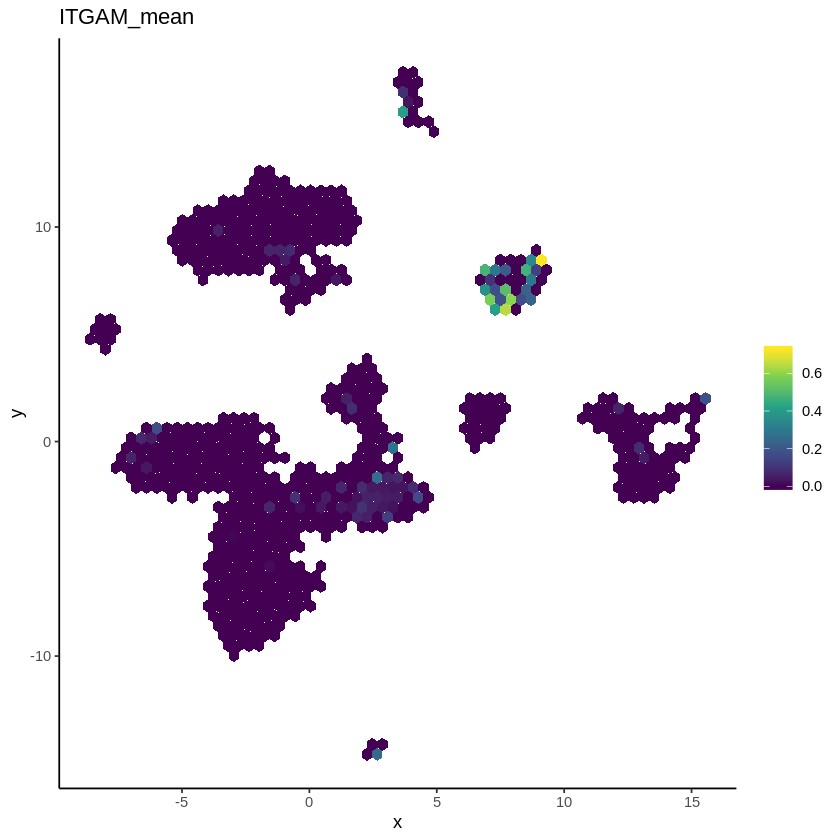

In [28]:
# ITGAM = CD11B
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='ITGAM',action='mean')
plot(p1)

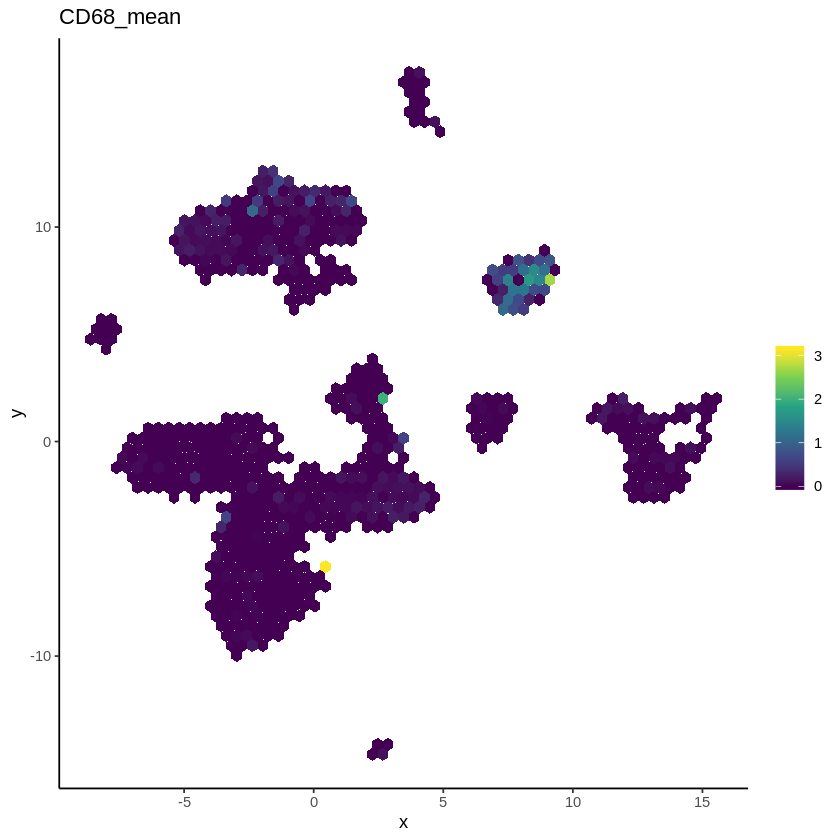

In [29]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='CD68',action='mean')
plot(p1)

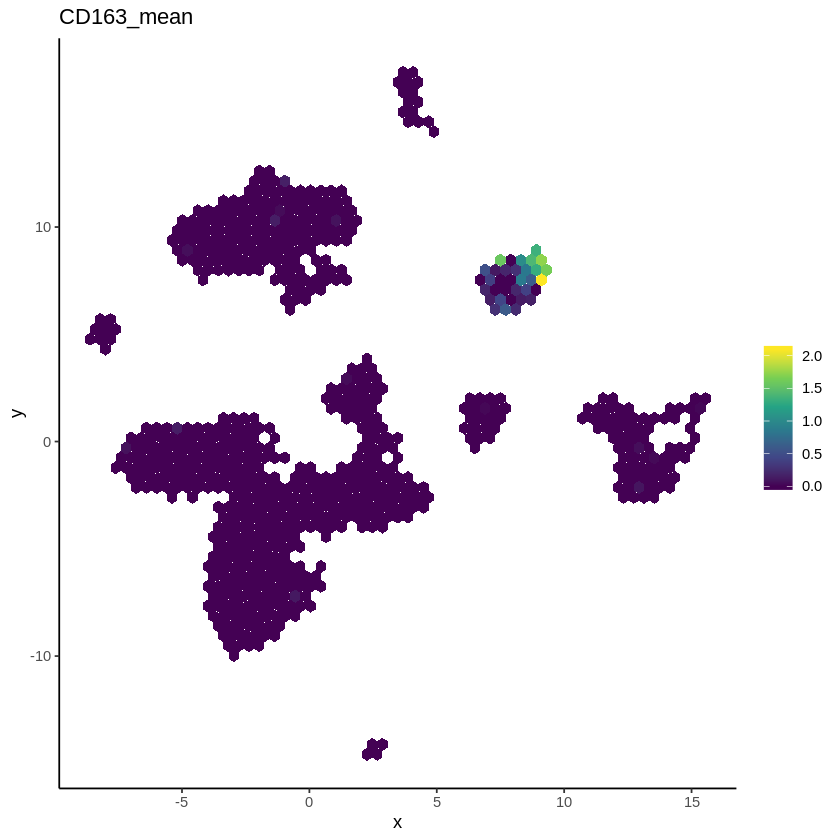

In [30]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='CD163',action='mean')
plot(p1)

HLA-DRA

HLA-DRB1

HLA-DRB3

HLA-DRB4

HLA-DRB5

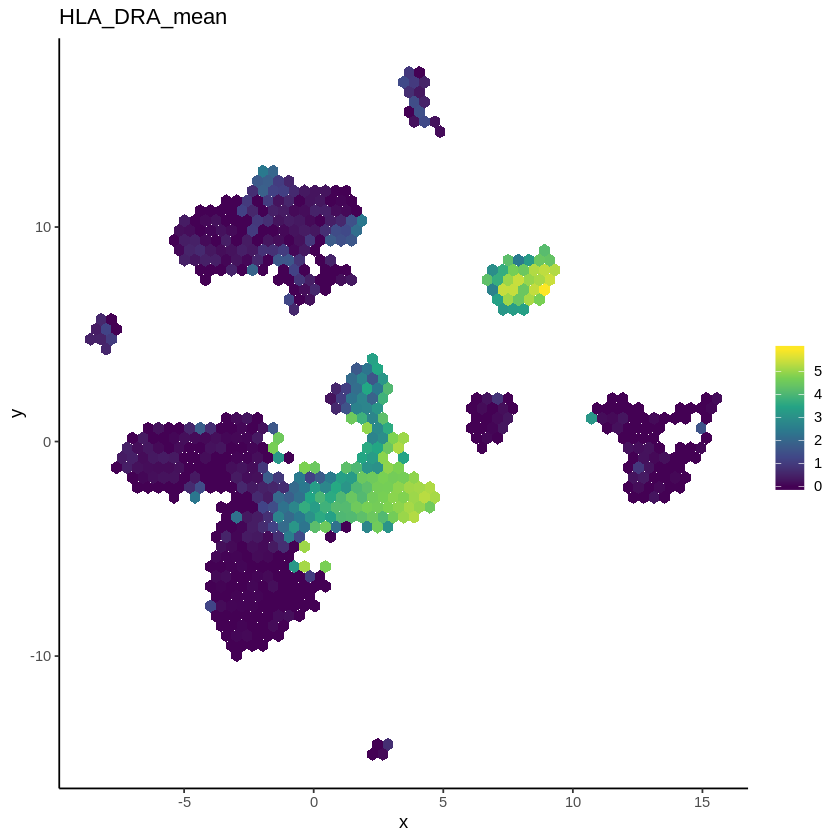

In [31]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='HLA-DRA',action='mean')
plot(p1)

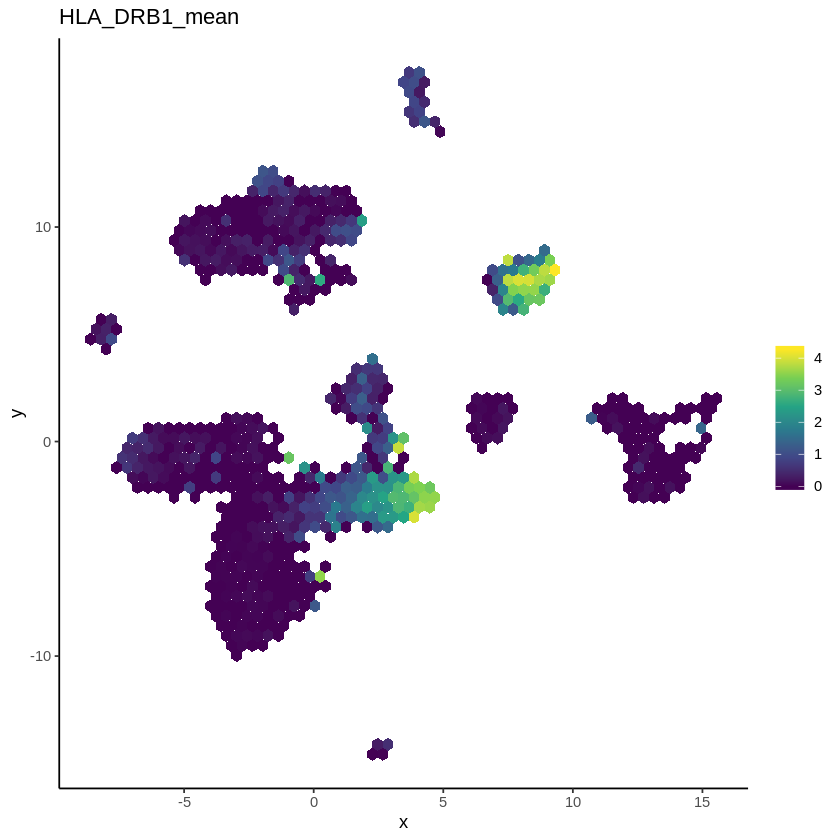

In [32]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='HLA-DRB1',action='mean')
plot(p1)

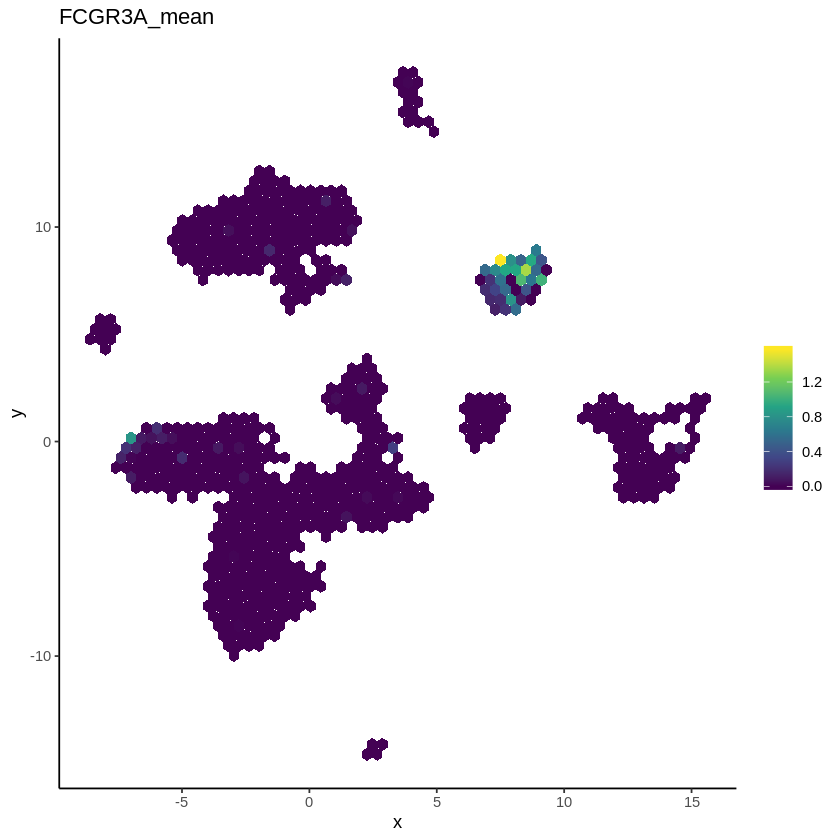

In [33]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='FCGR3A',action='mean')
plot(p1)

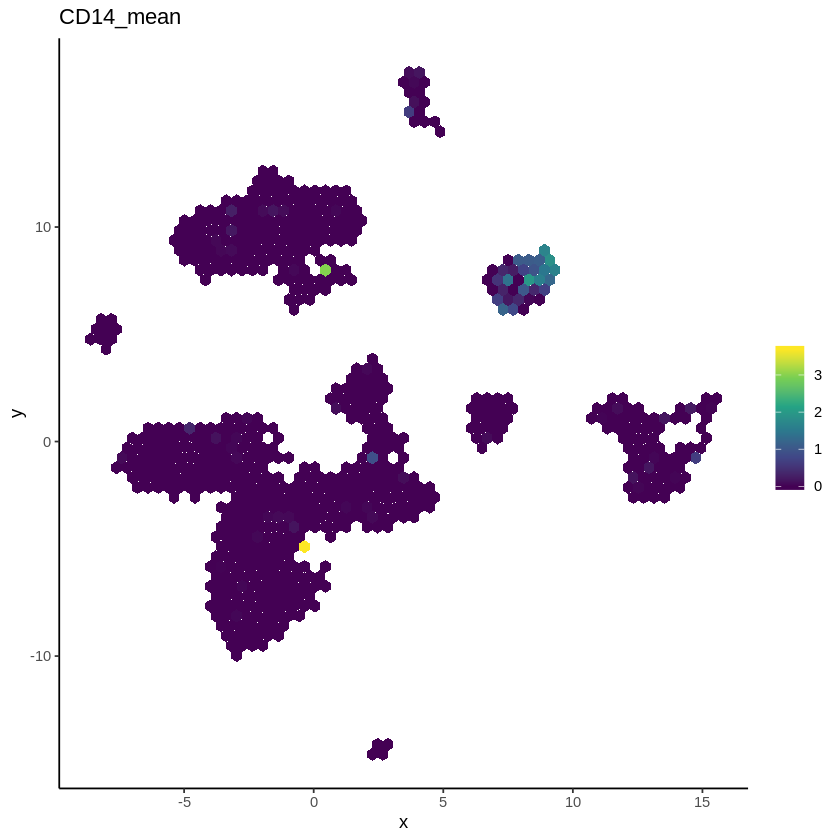

In [34]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='CD14',action='mean')
plot(p1)

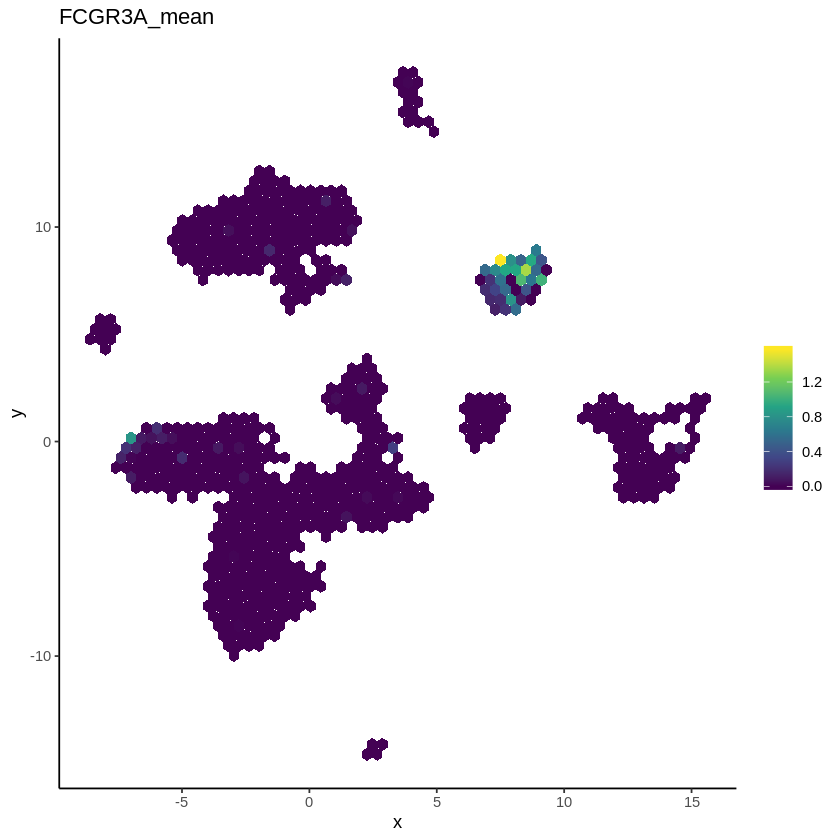

In [35]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='FCGR3A',action='mean')
plot(p1)

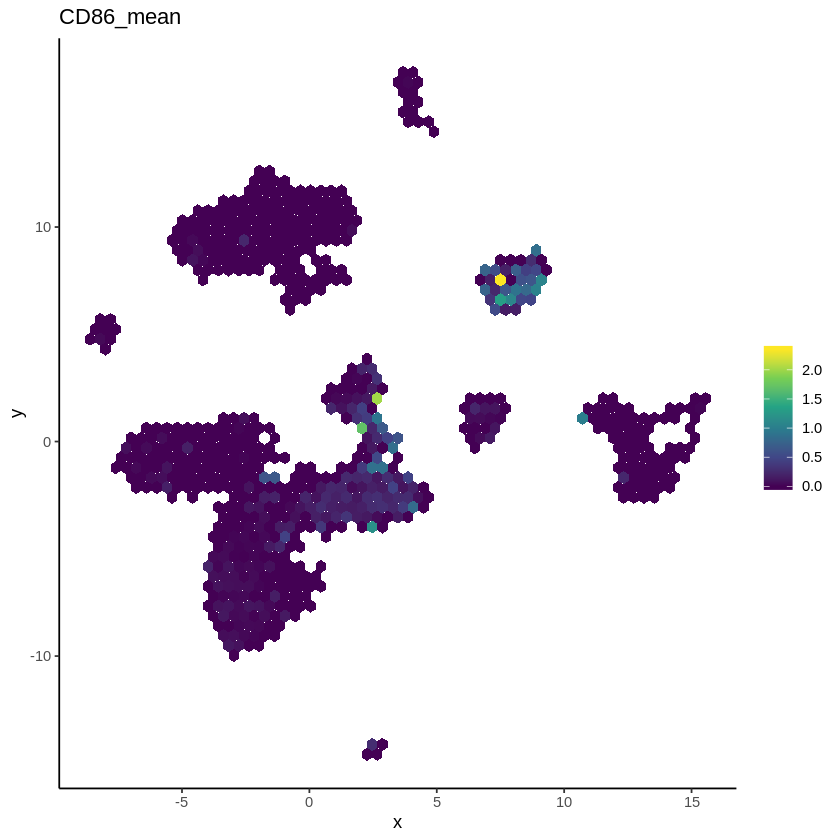

In [36]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='CD86',action='mean')
plot(p1)

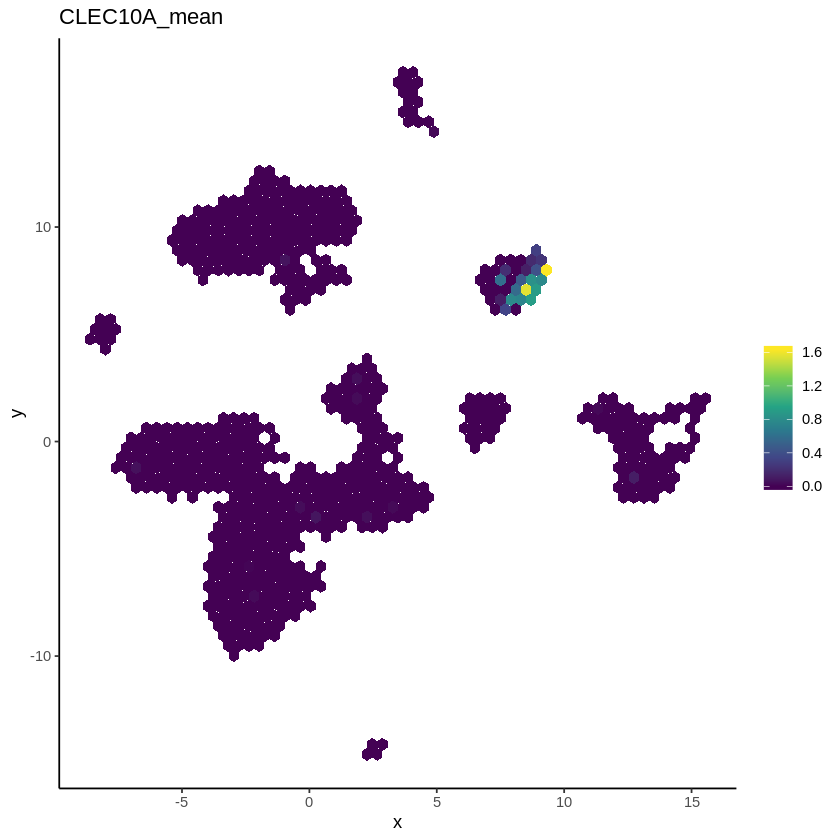

In [37]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='CLEC10A',action='mean')
plot(p1)

In [38]:
Tcellmarker2 <- c('CD3D','CD3E','CD3G','CD247','CD8A','CD4','CXCR3','CCR4','IL2RA','CCR6','CXCR5','IL10','FOXP3')

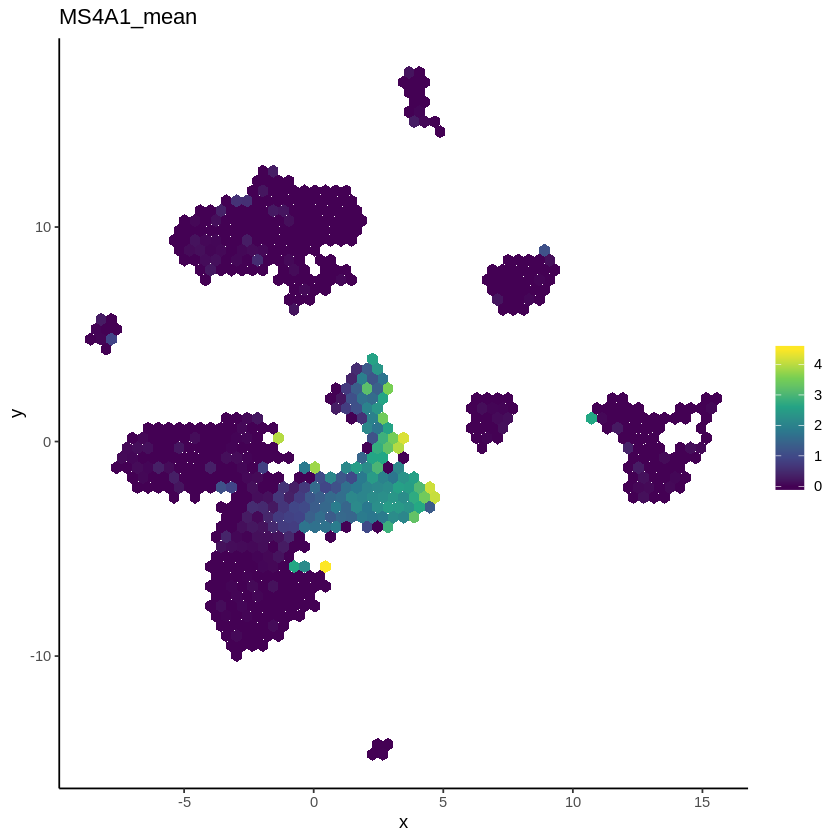

In [39]:
p1 <- plot_hexbin_gene(data_schex, type='logcounts',gene='MS4A1',action='mean')
plot(p1)

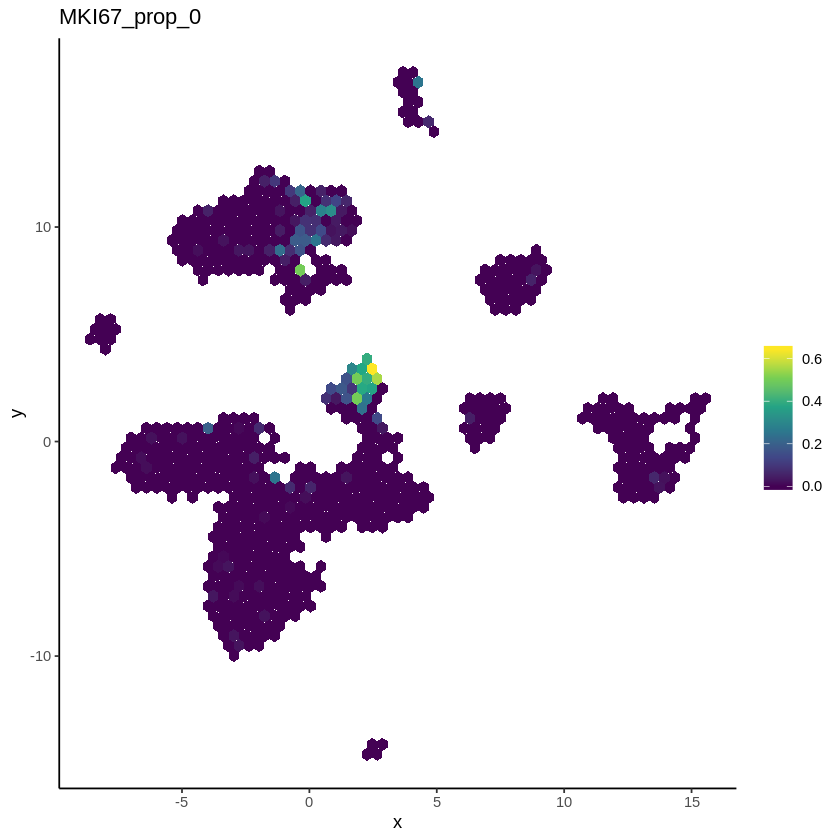

In [40]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'MKI67', action = "prop_0")

In [ ]:
IGKC
IGLC3
JCHAIN
IGHG1
IGLL5

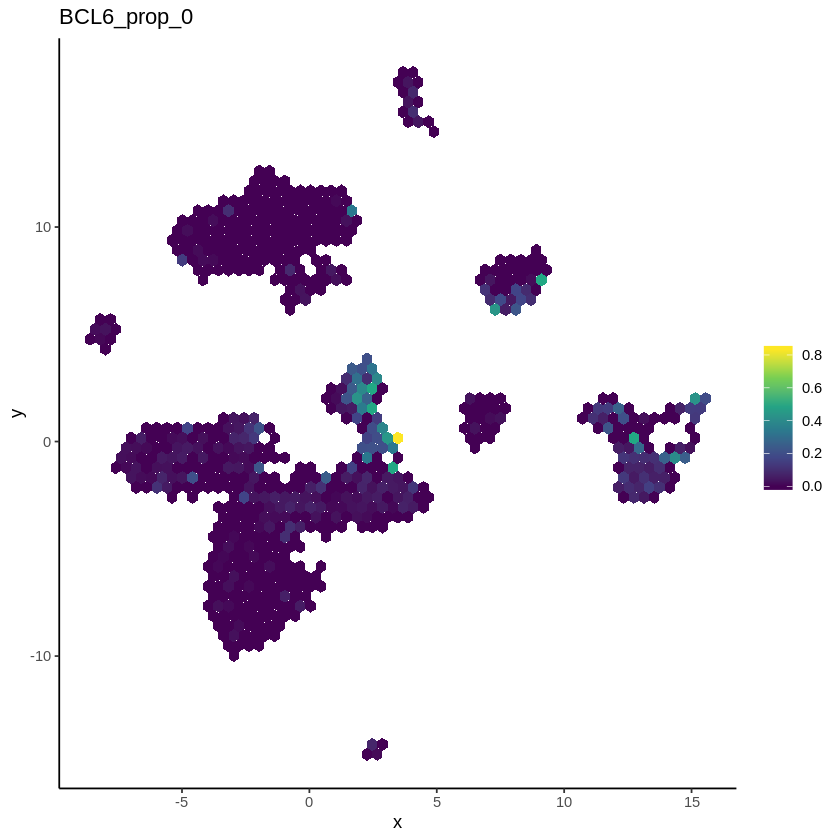

In [41]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'BCL6', action = "prop_0")

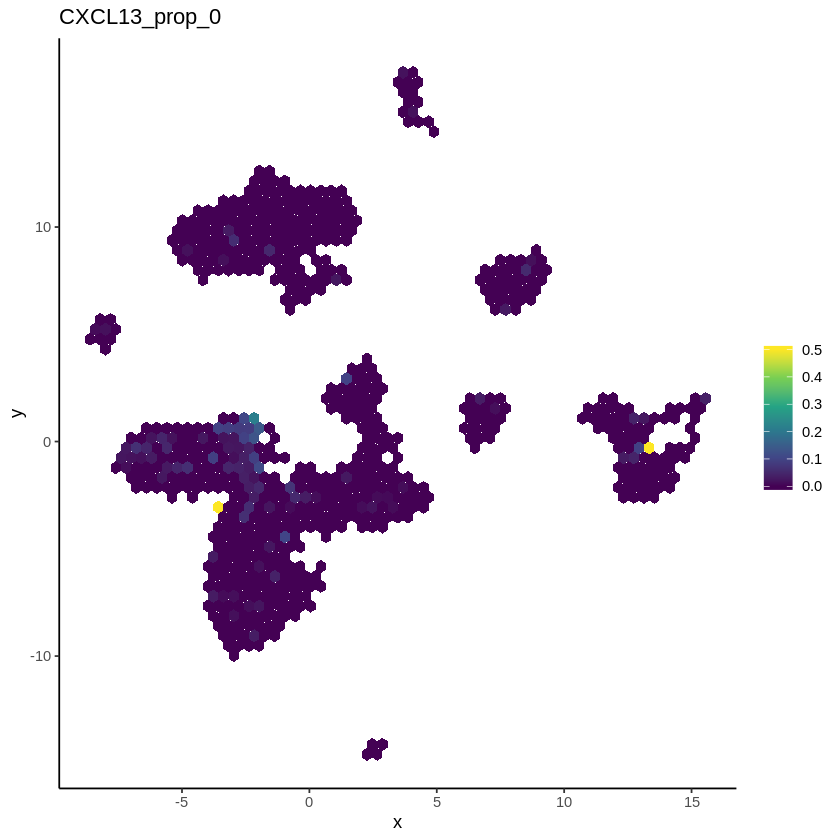

In [42]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'CXCL13', action = "prop_0")

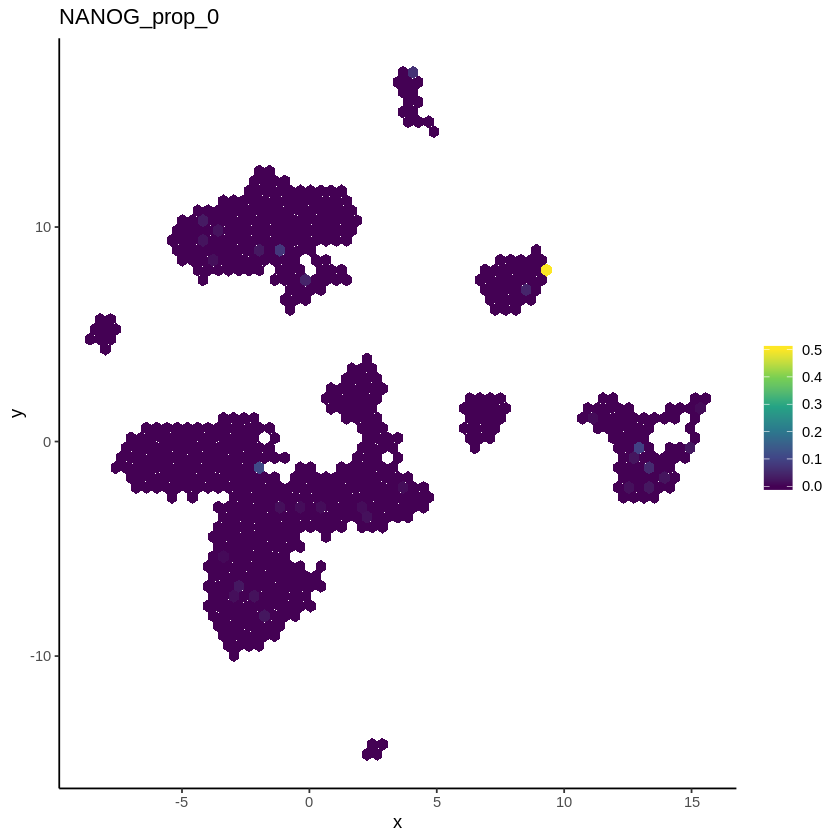

In [43]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'NANOG', action = "prop_0")

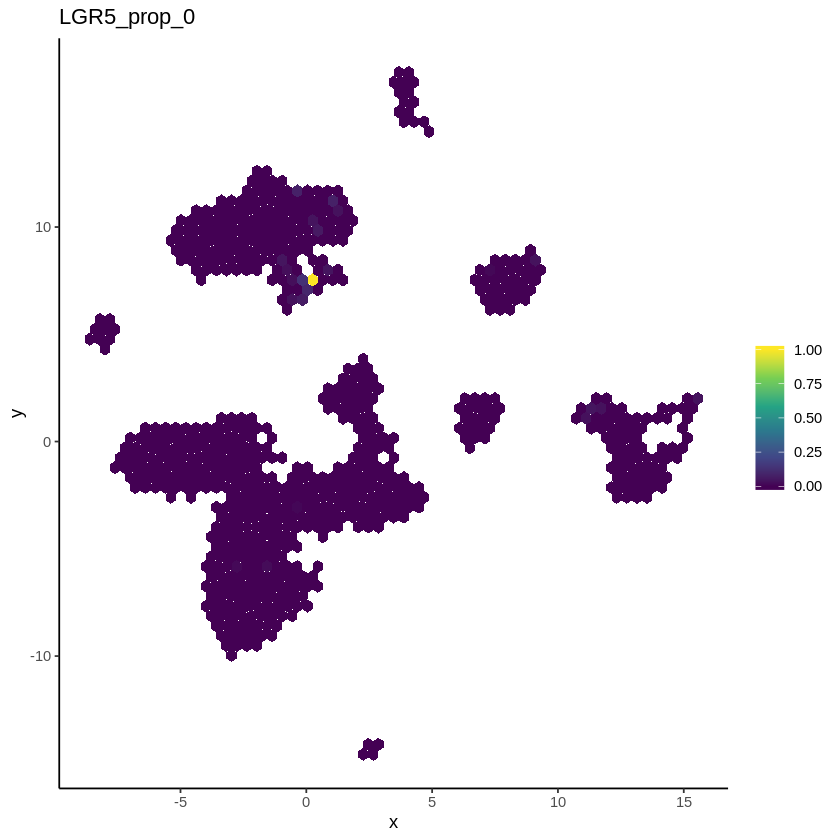

In [44]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'LGR5', action = "prop_0")

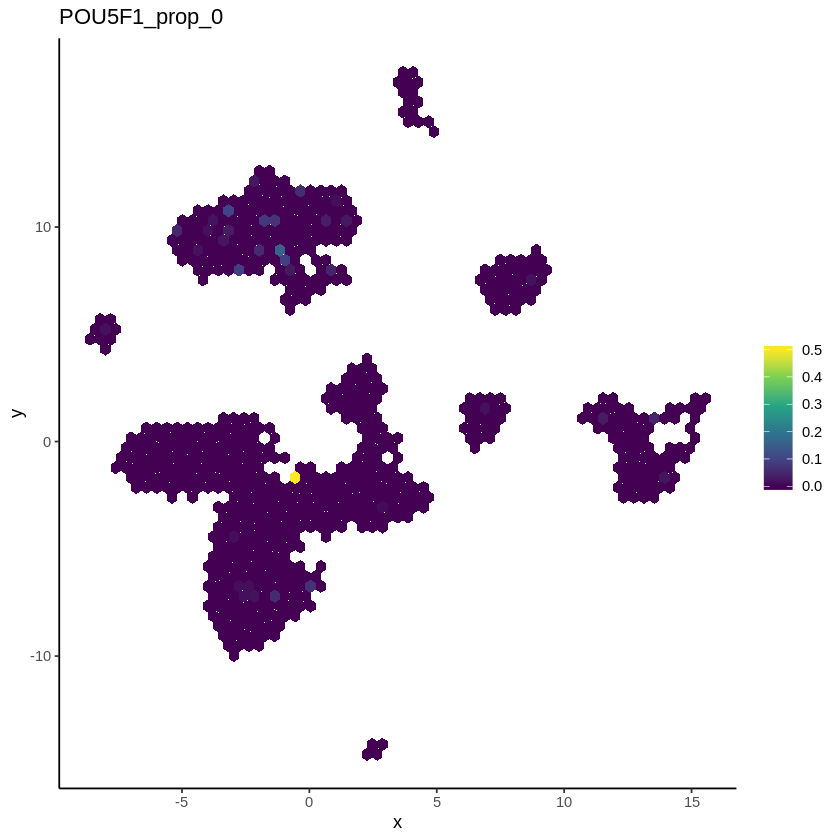

In [45]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'POU5F1', action = "prop_0")

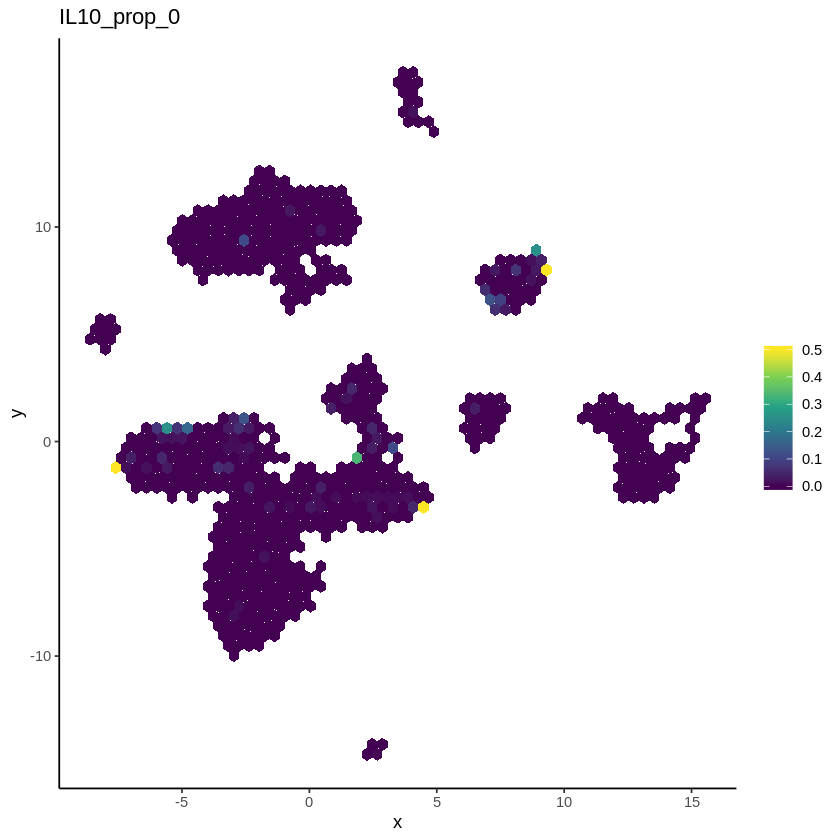

In [46]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'IL10', action = "prop_0")

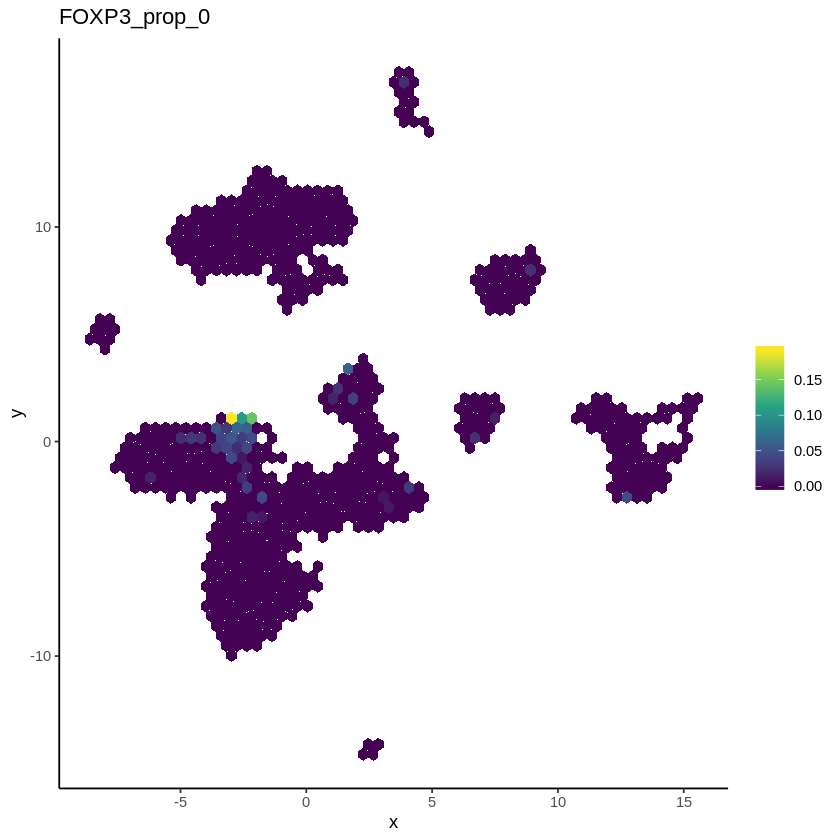

In [47]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'FOXP3', action = "prop_0")

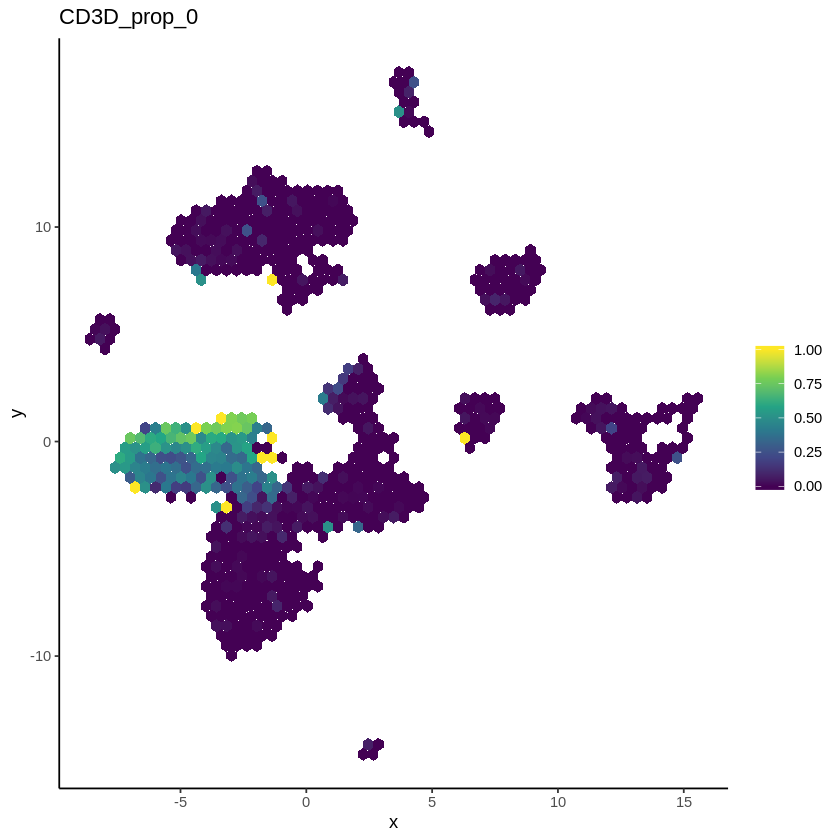

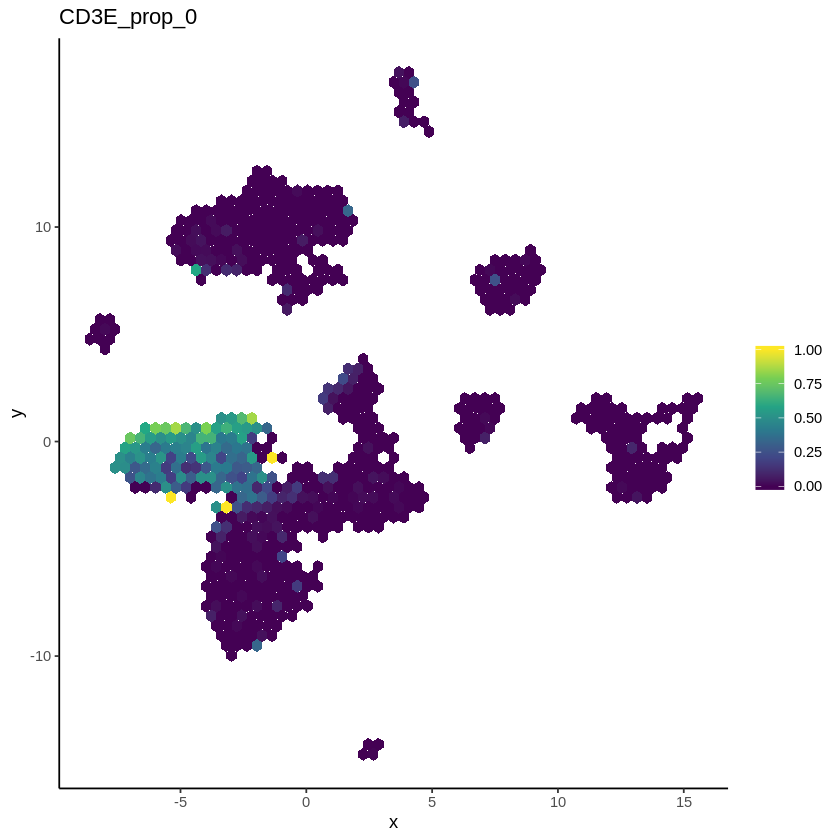

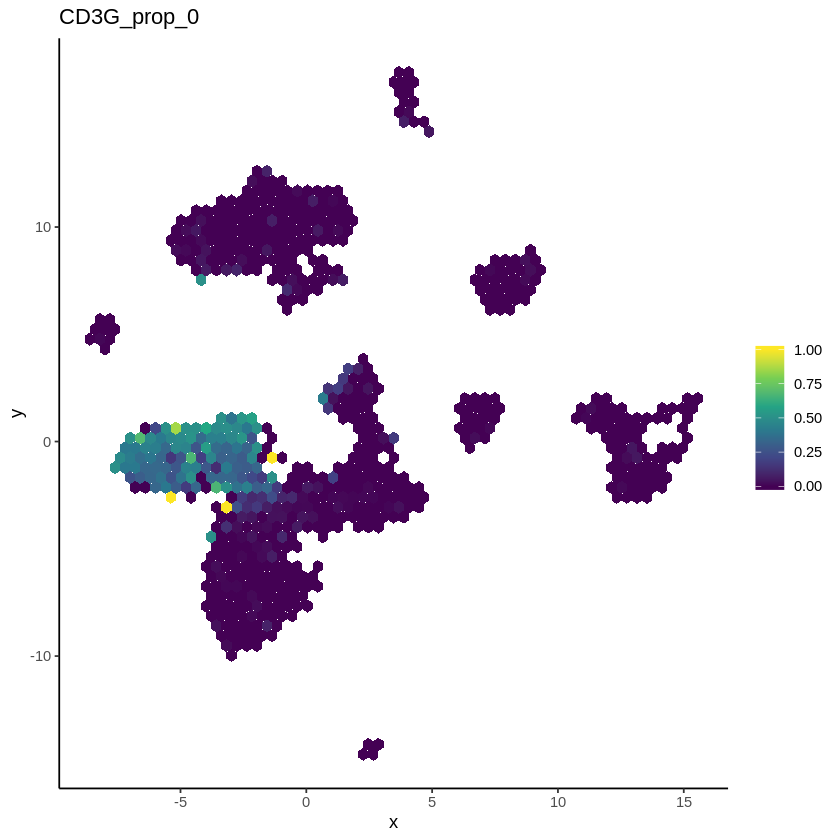

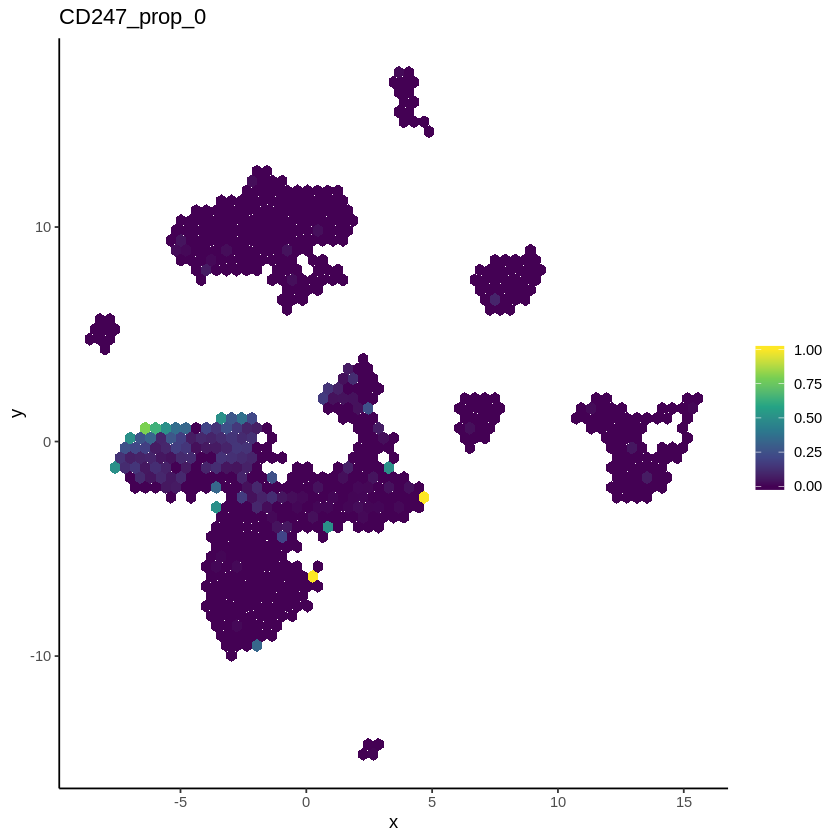

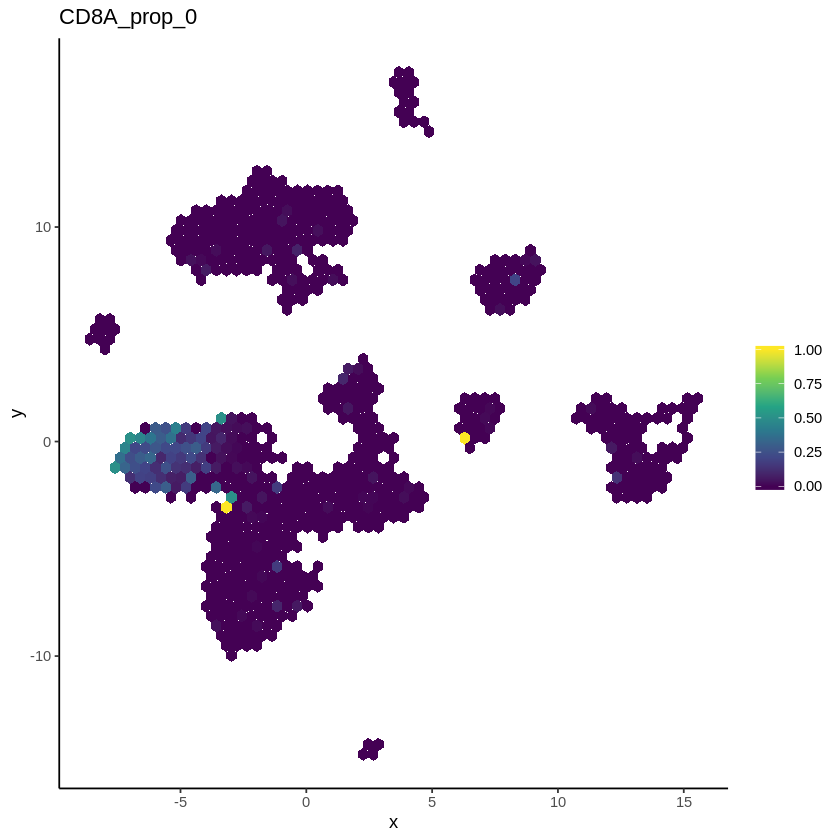

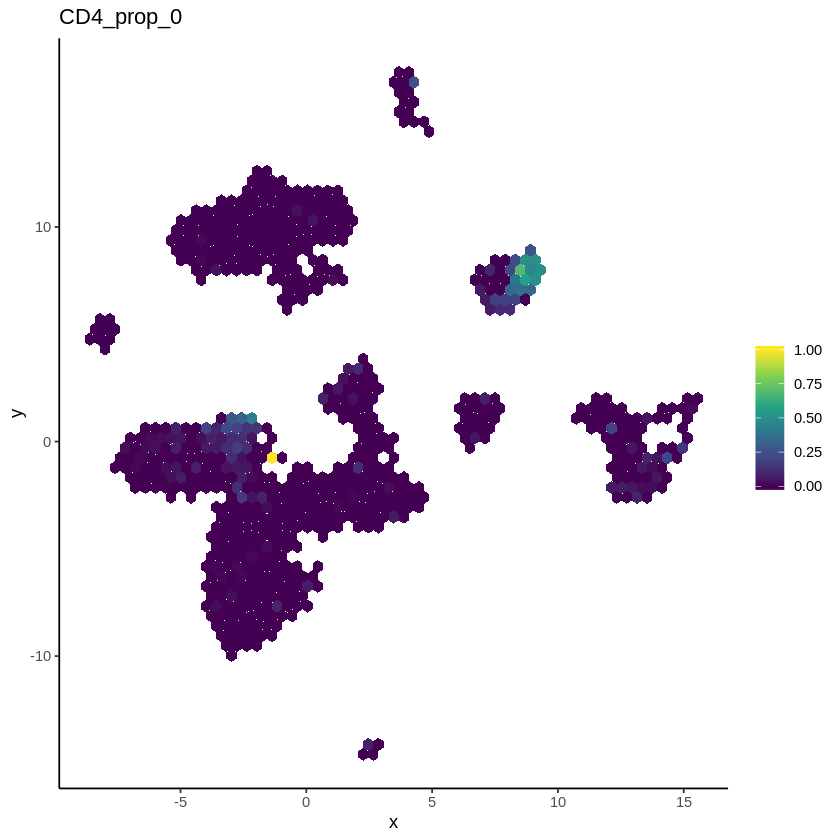

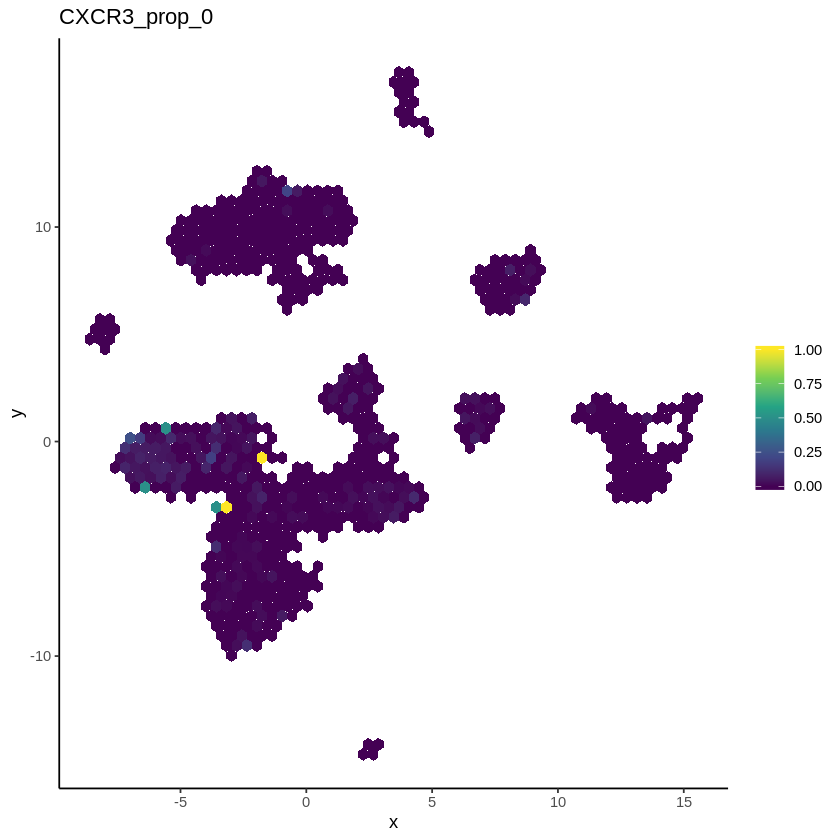

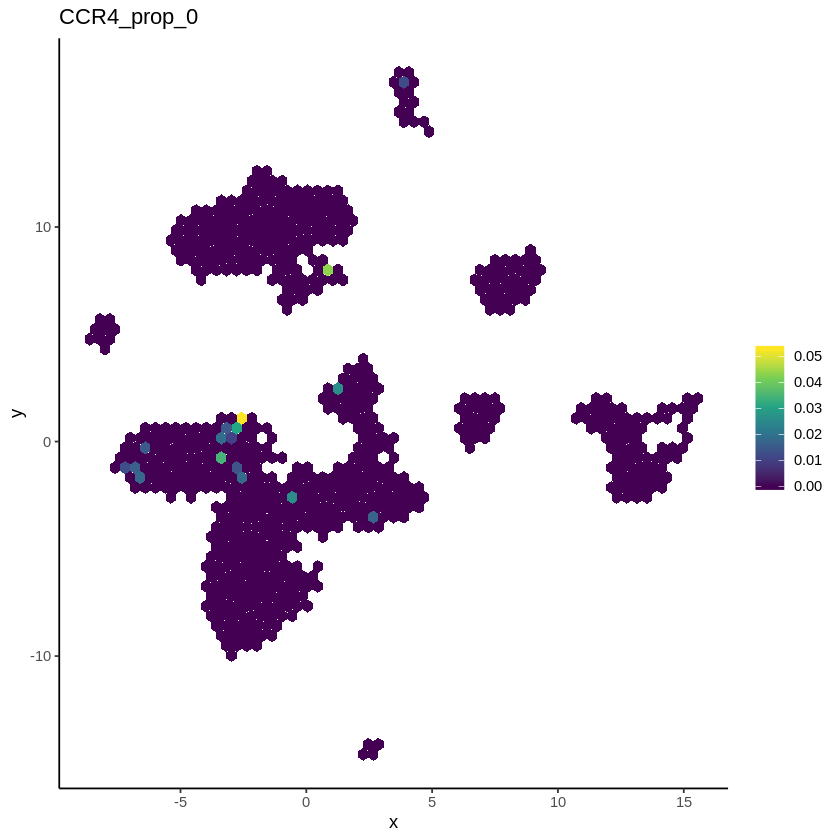

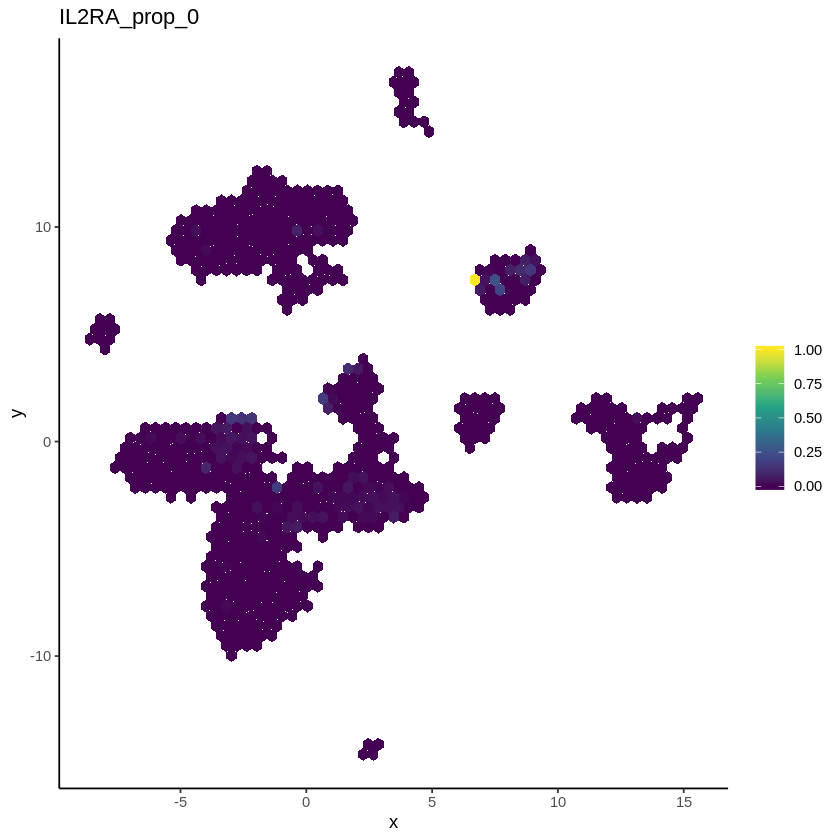

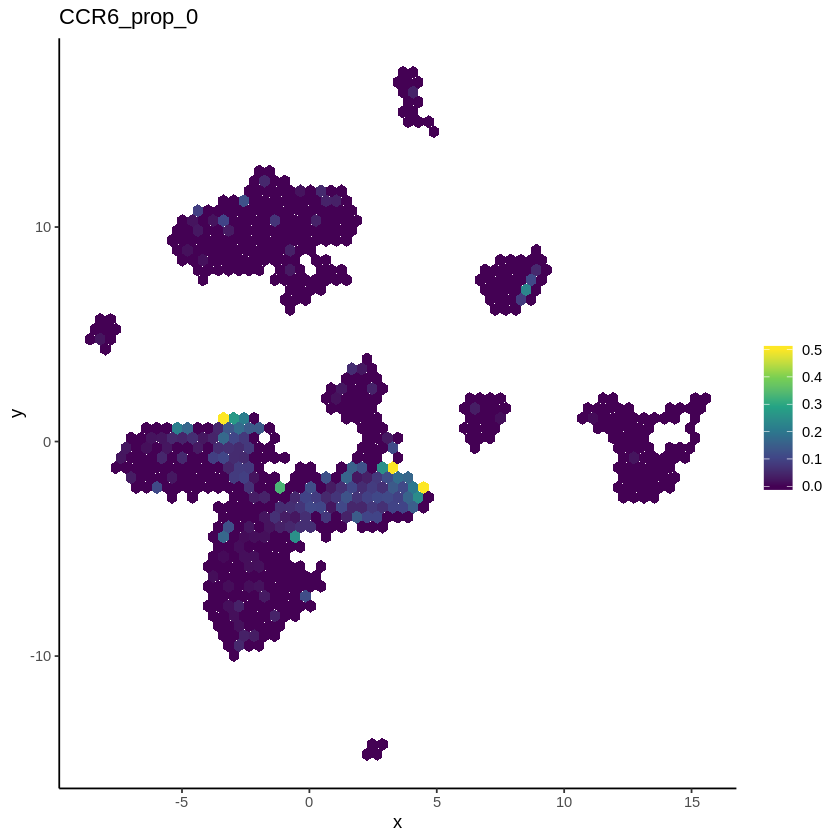

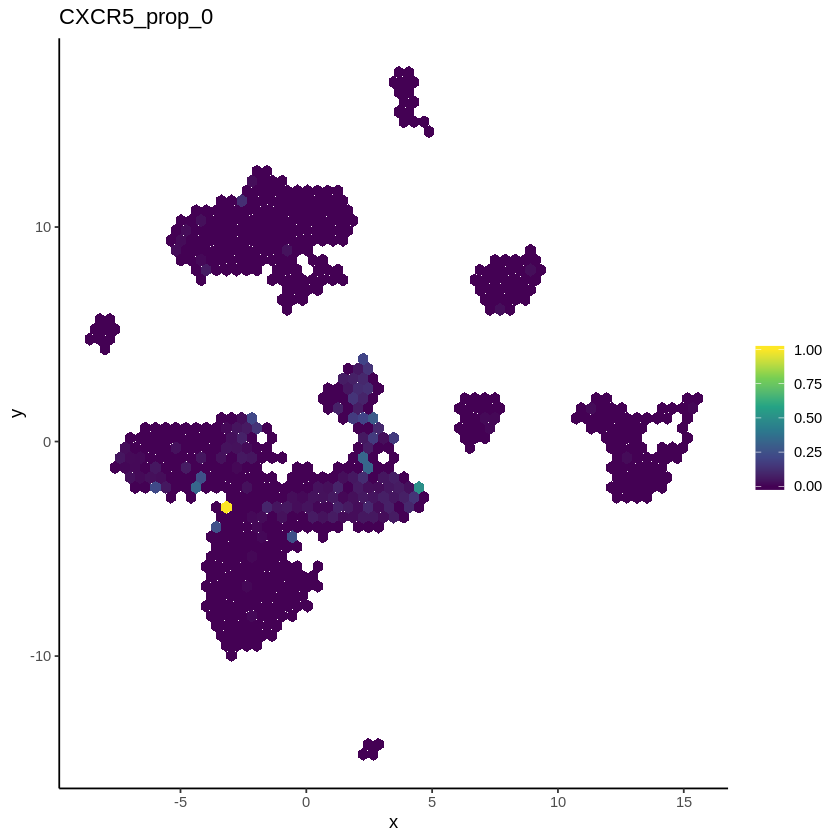

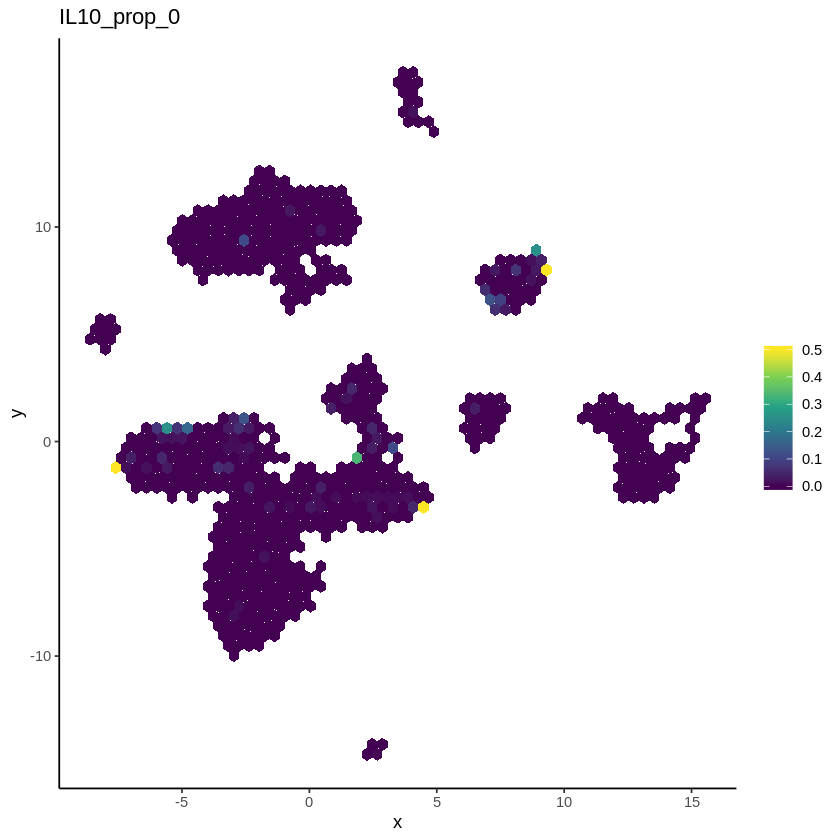

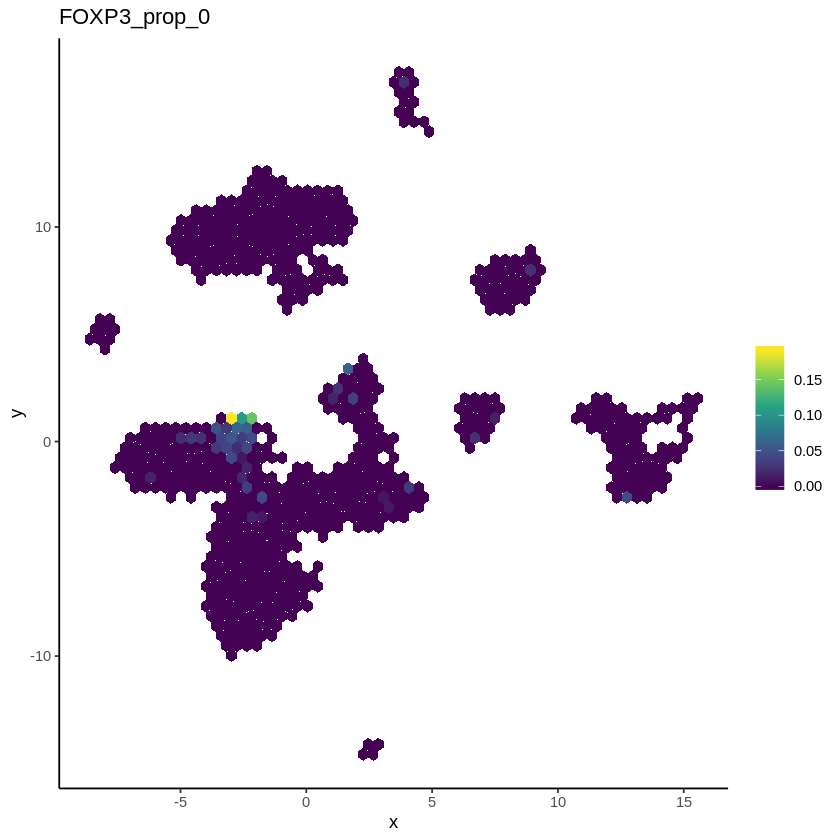

In [48]:
for (i in 1:length(Tcellmarker2)){
    p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = Tcellmarker2[i], action = "prop_0")
    plot(p1)
}

In [49]:
epi_markers <- c("TFF1","TFF2","PGA4","CA2","MUC1","MUC5AC","REG1A",
                 "GKN2","OLFM4","KRT19","SPINK1", "LCN2","ATP4B","SOX4",
                 "IFI6","MLN","KRT20","CEACAM5","CEACAM6","GIF", "ALDH1A1",
                 "CKB","BEST4","GUCA2A","CHGA","PCSK1N","GHRL","TACSTD2",
                 "CCDC80","IGFBP6","GAST","CEL")

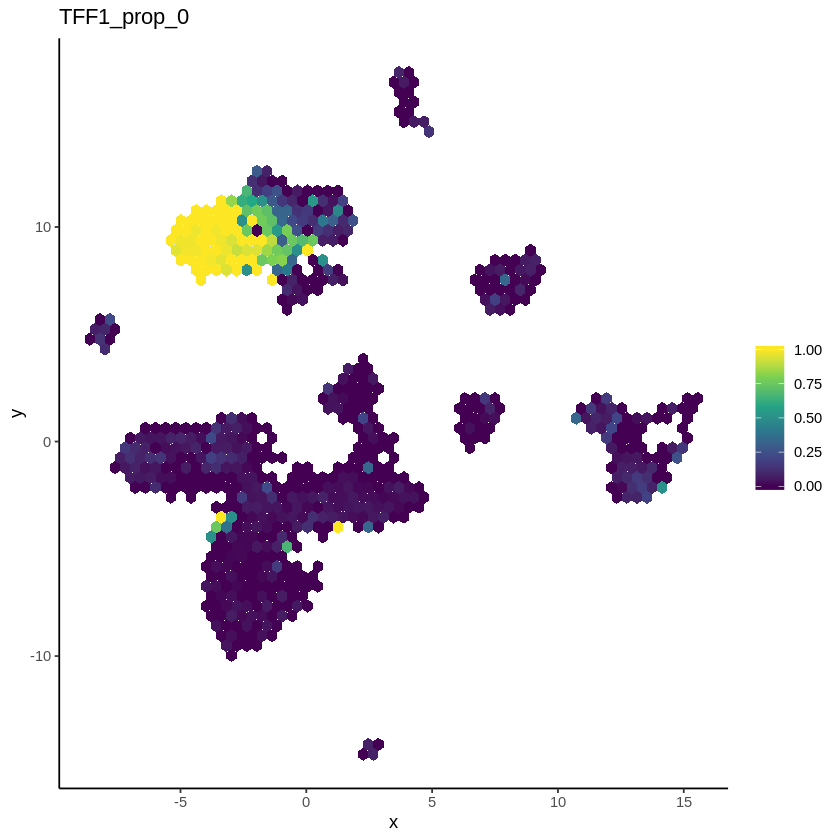

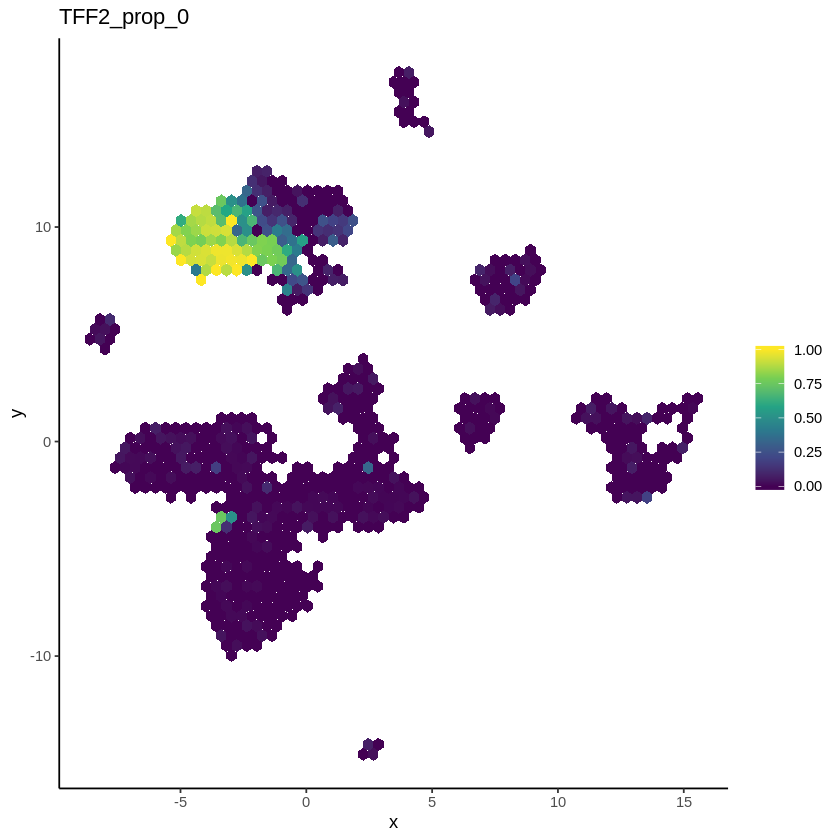

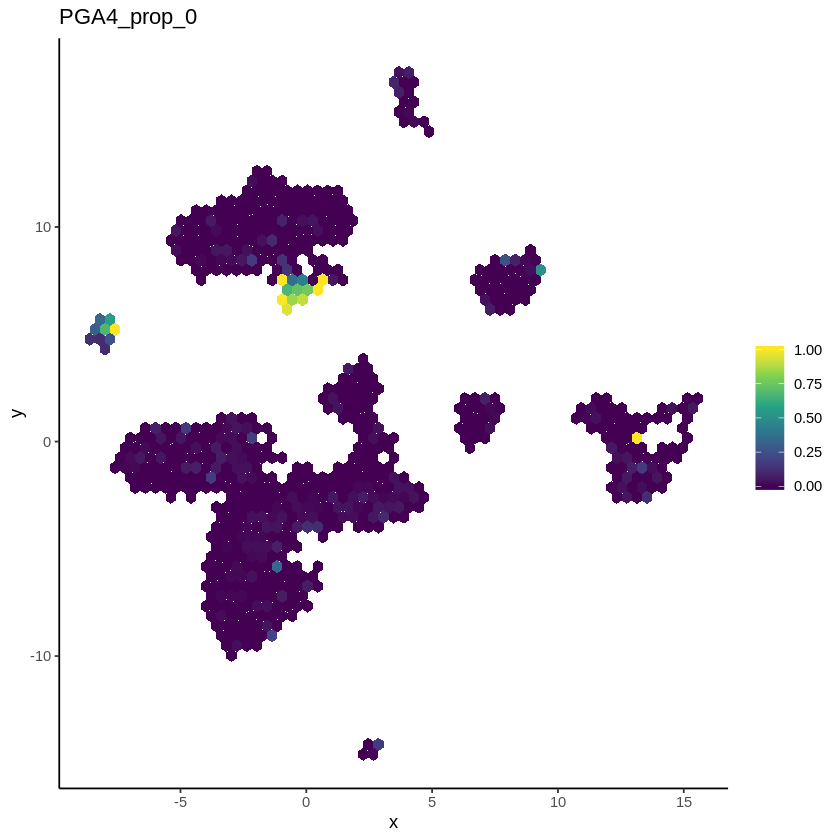

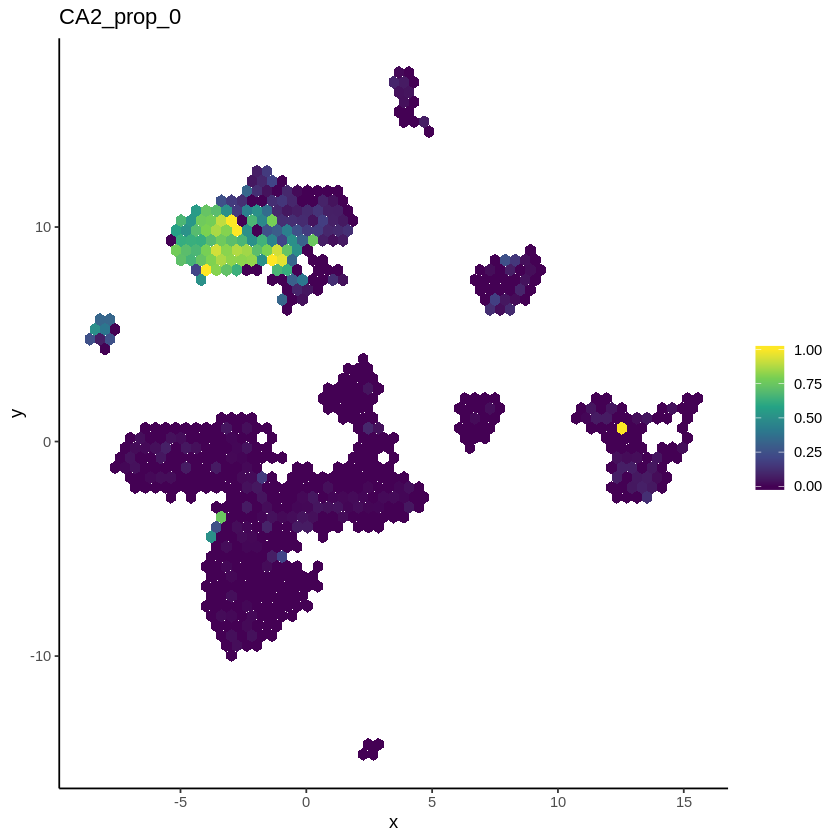

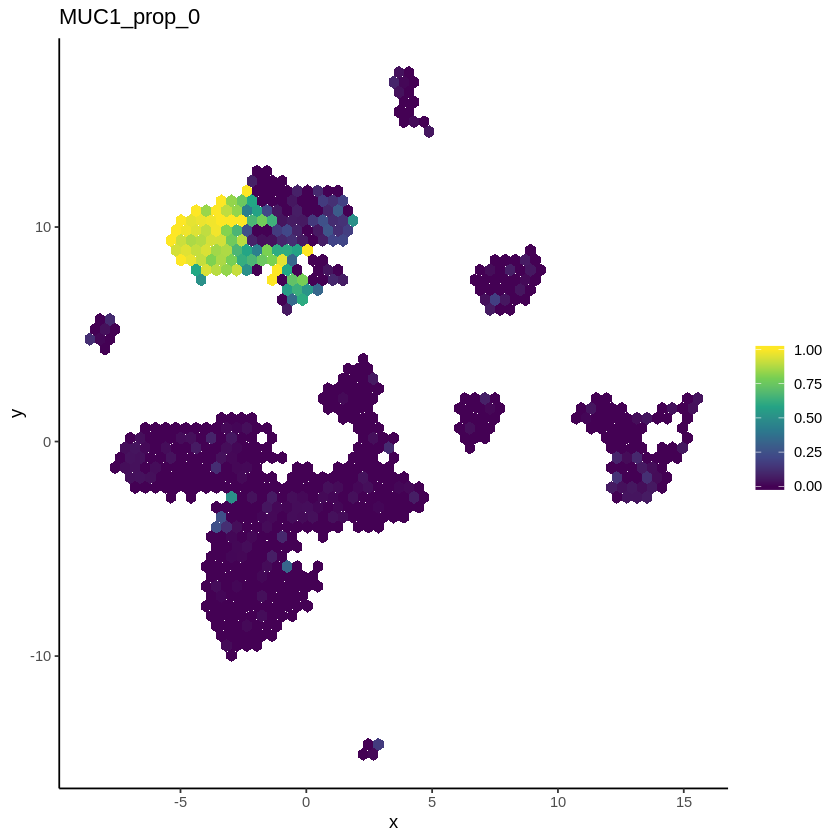

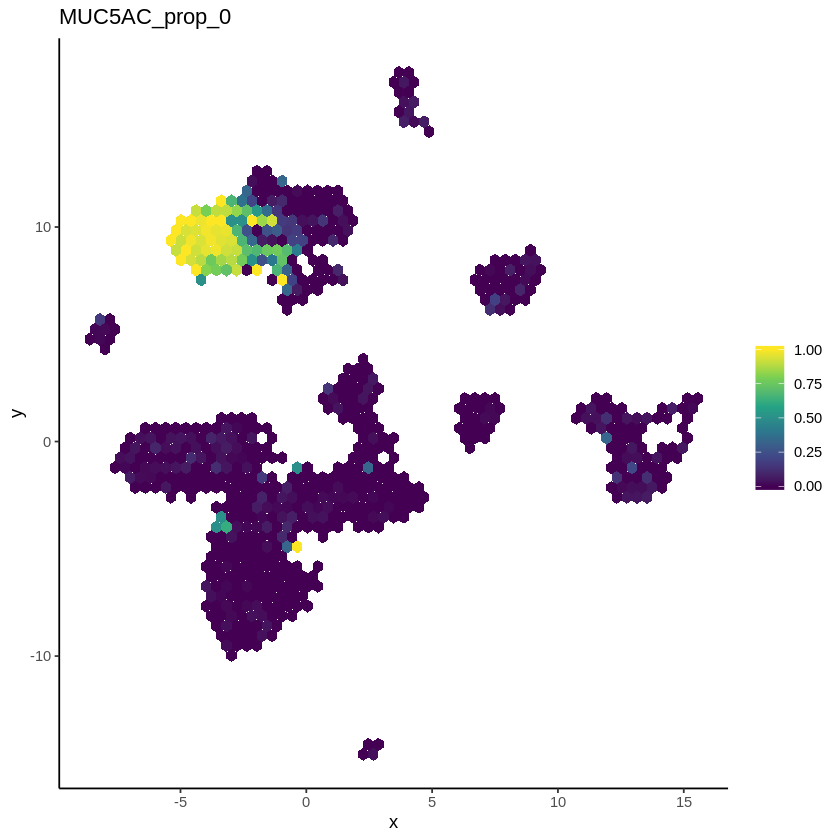

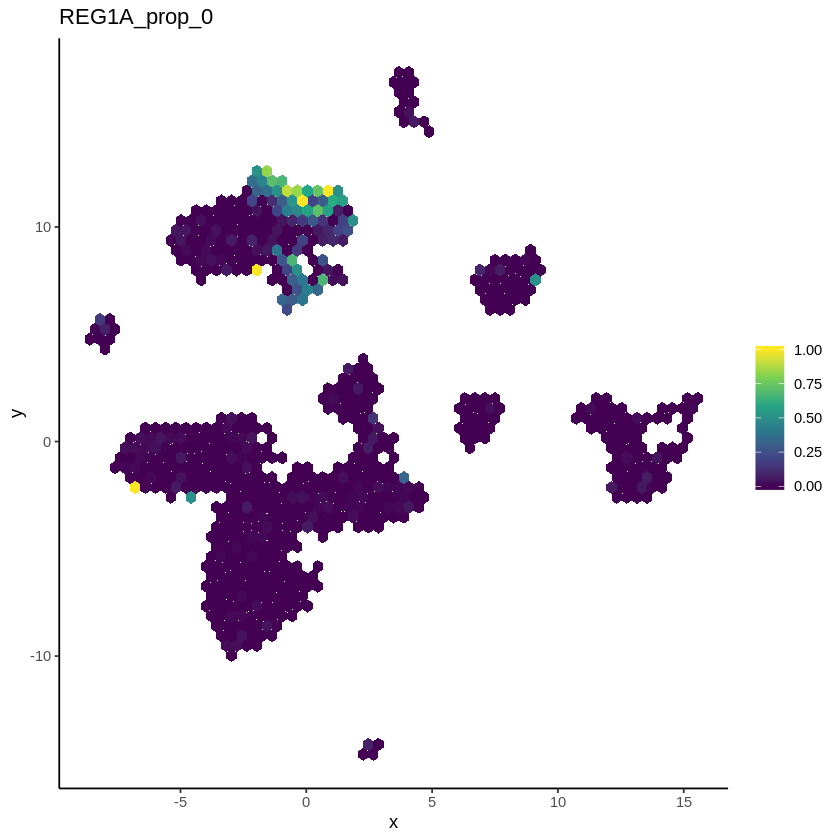

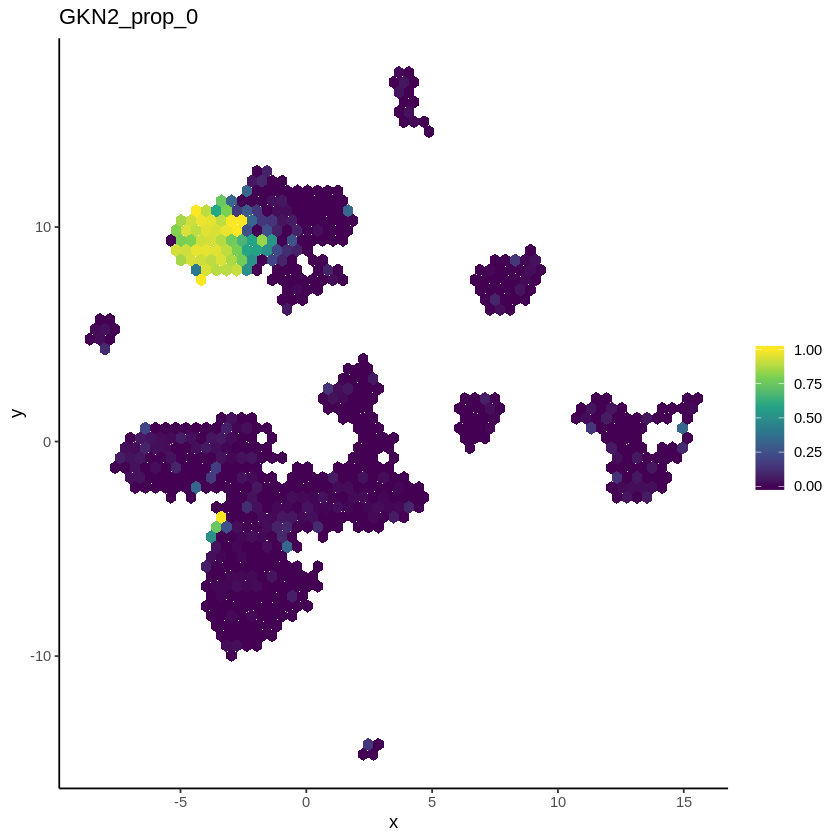

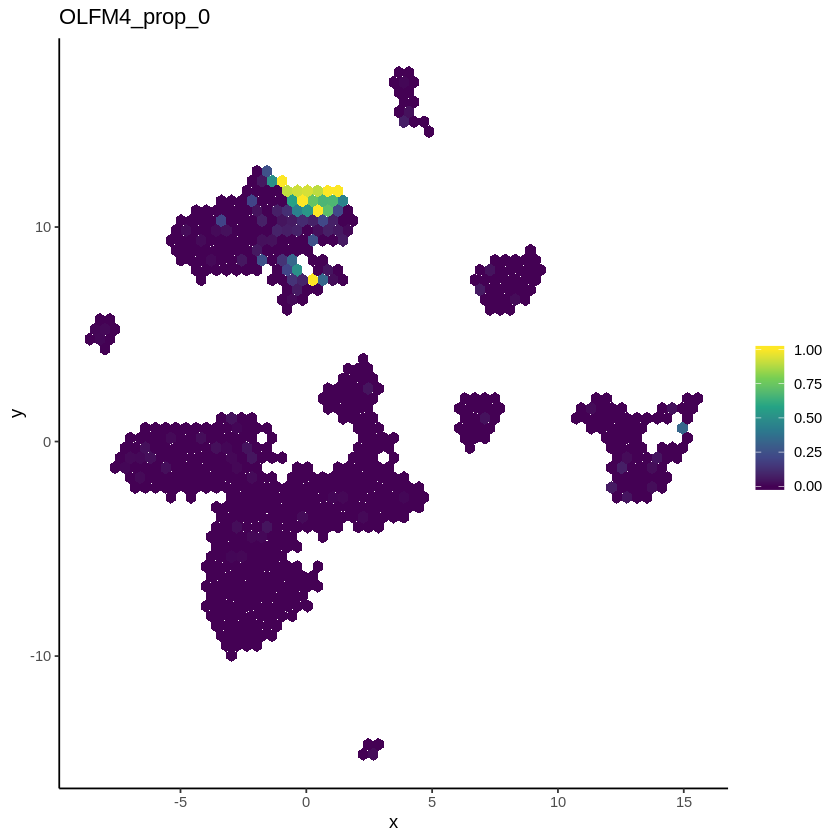

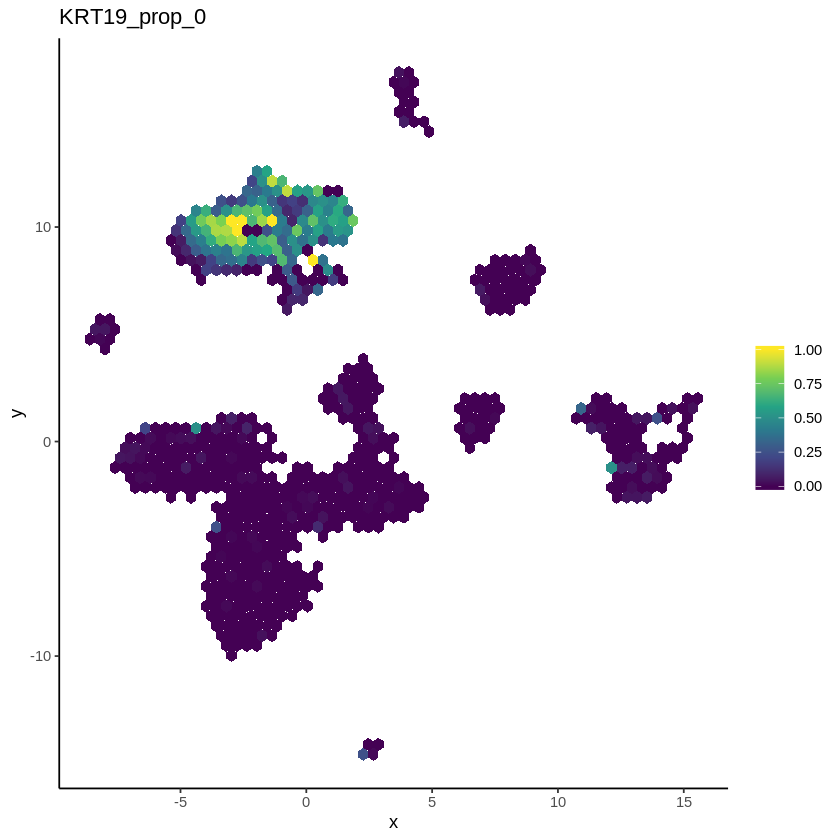

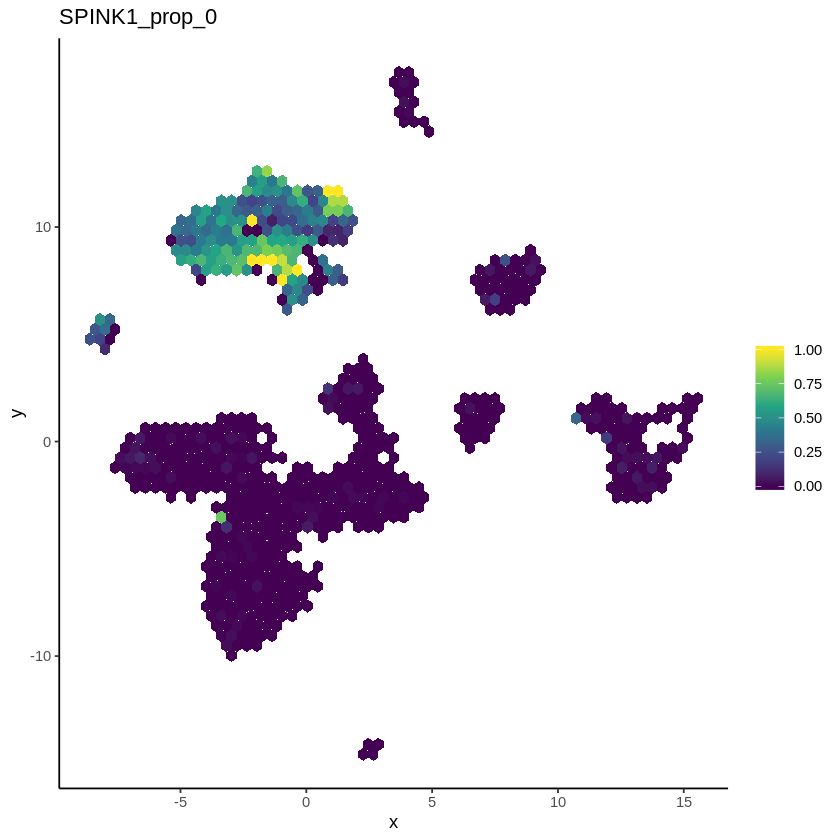

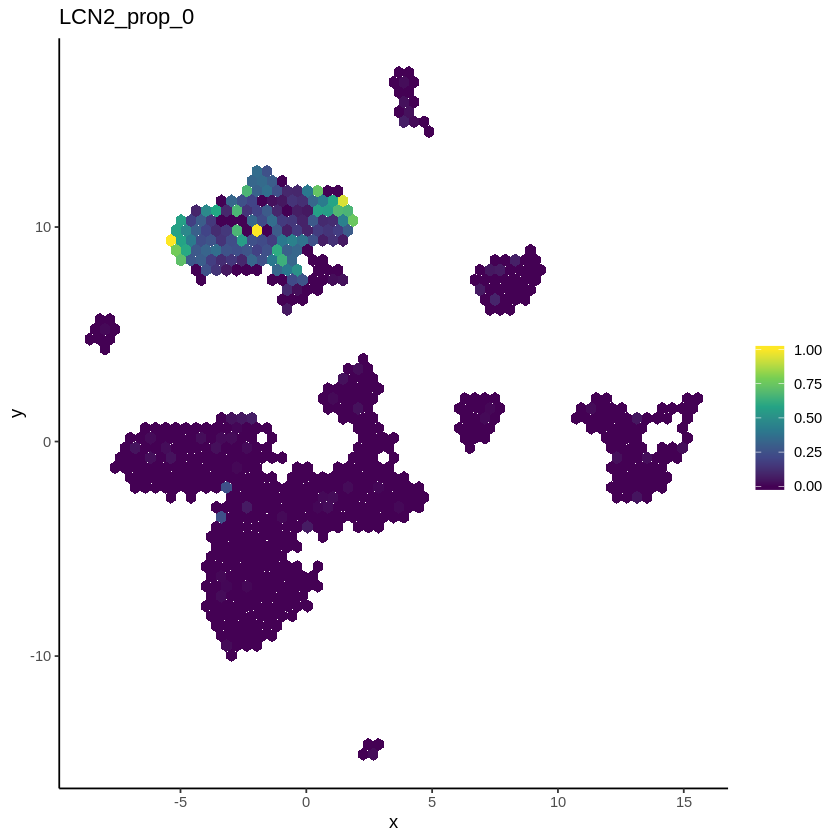

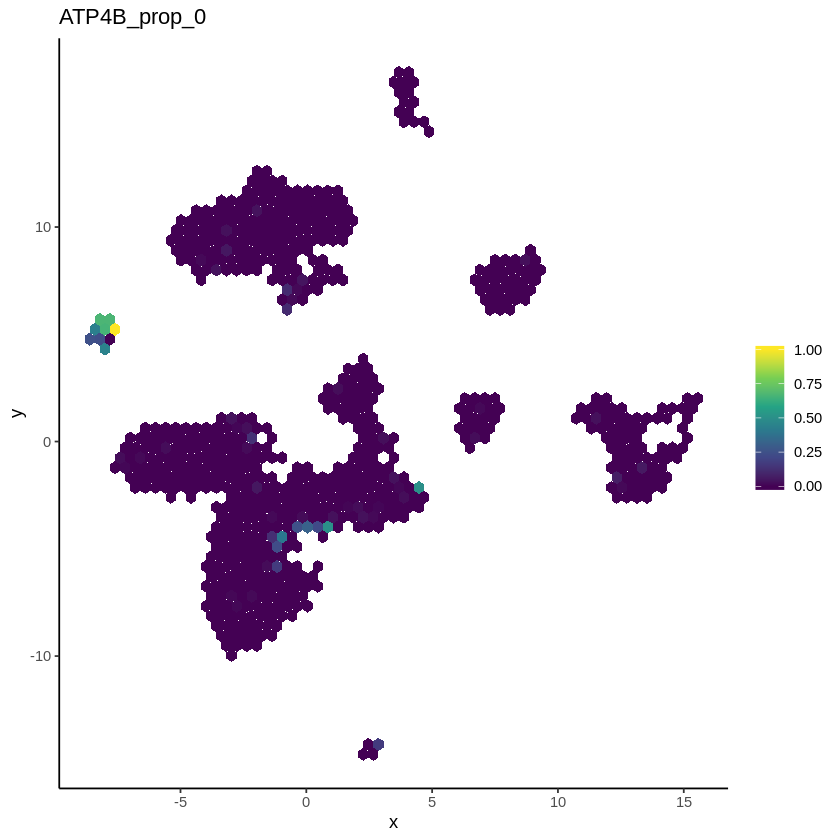

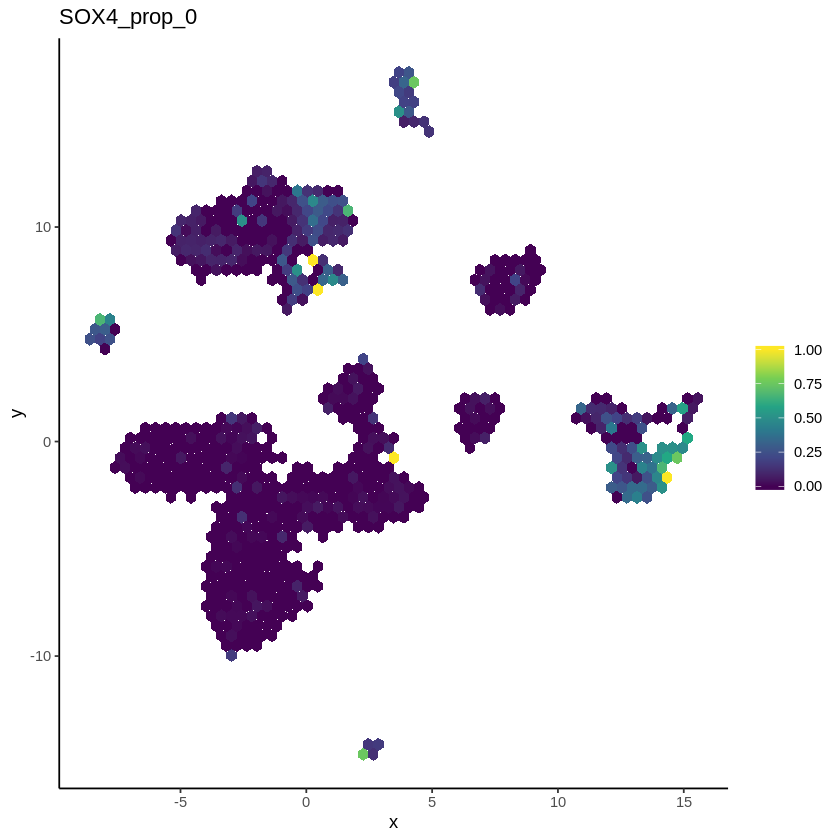

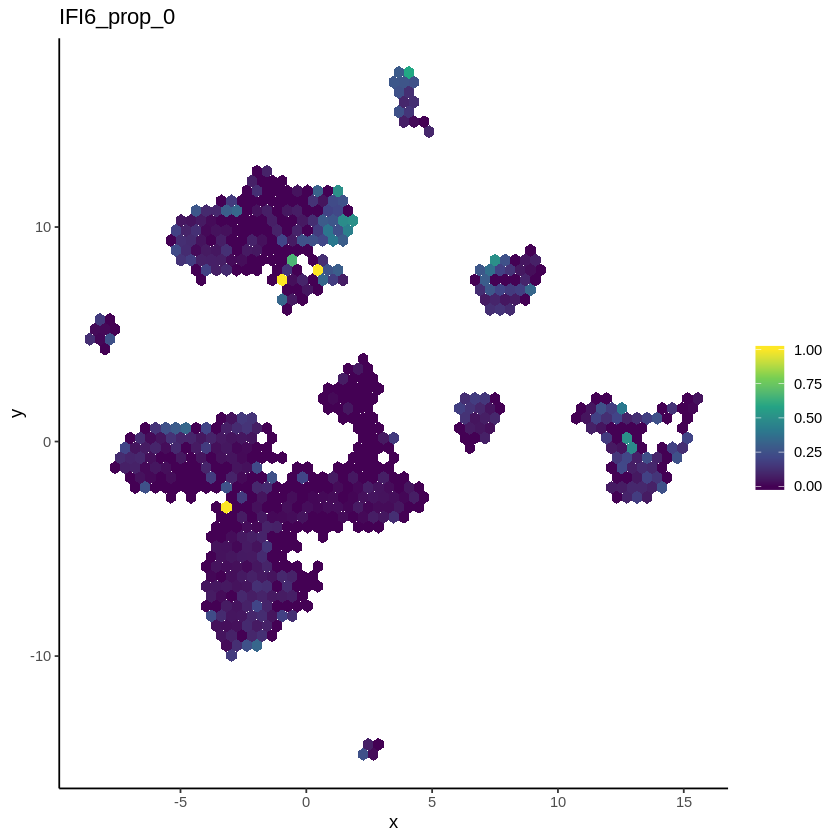

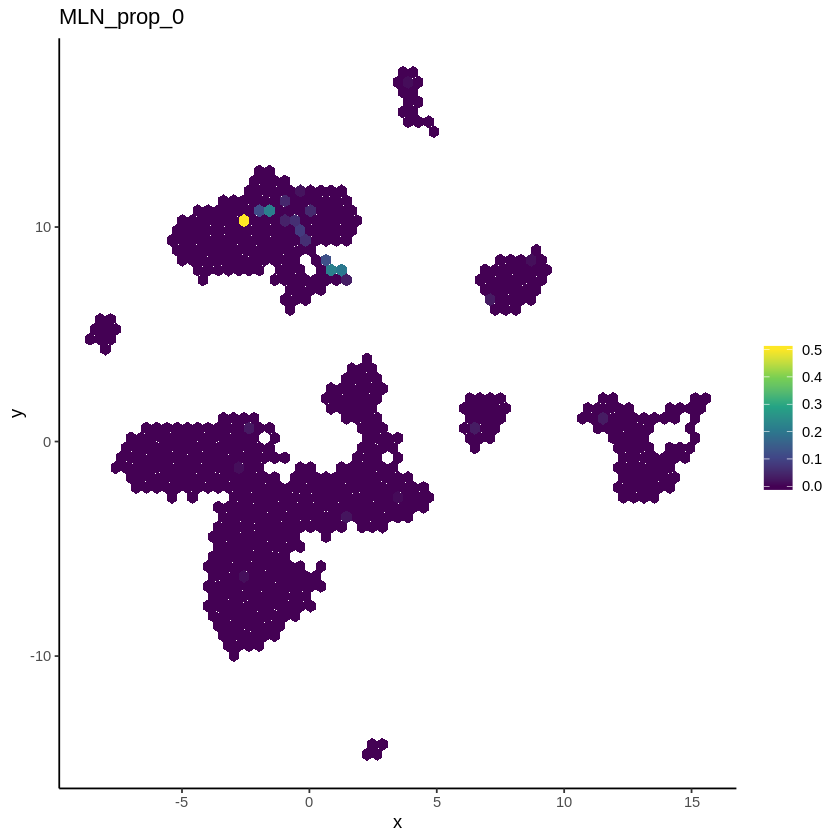

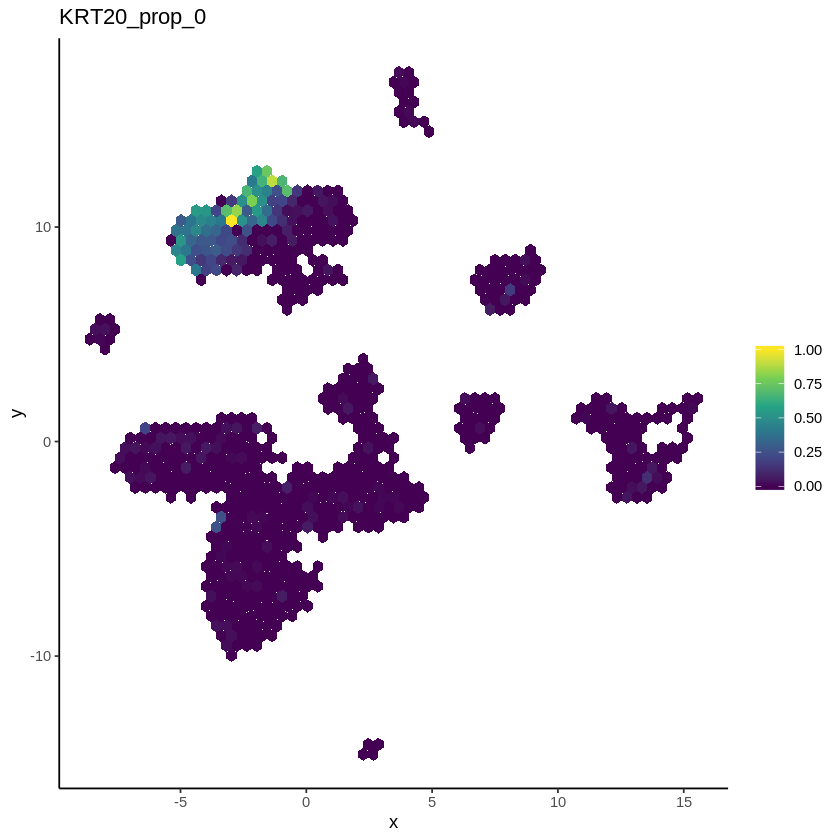

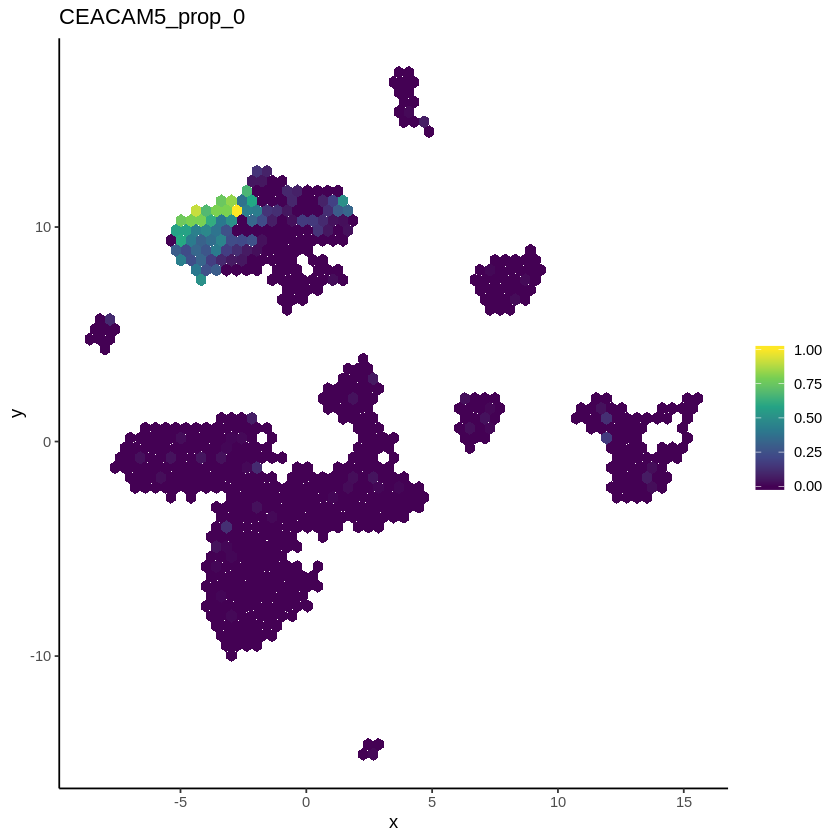

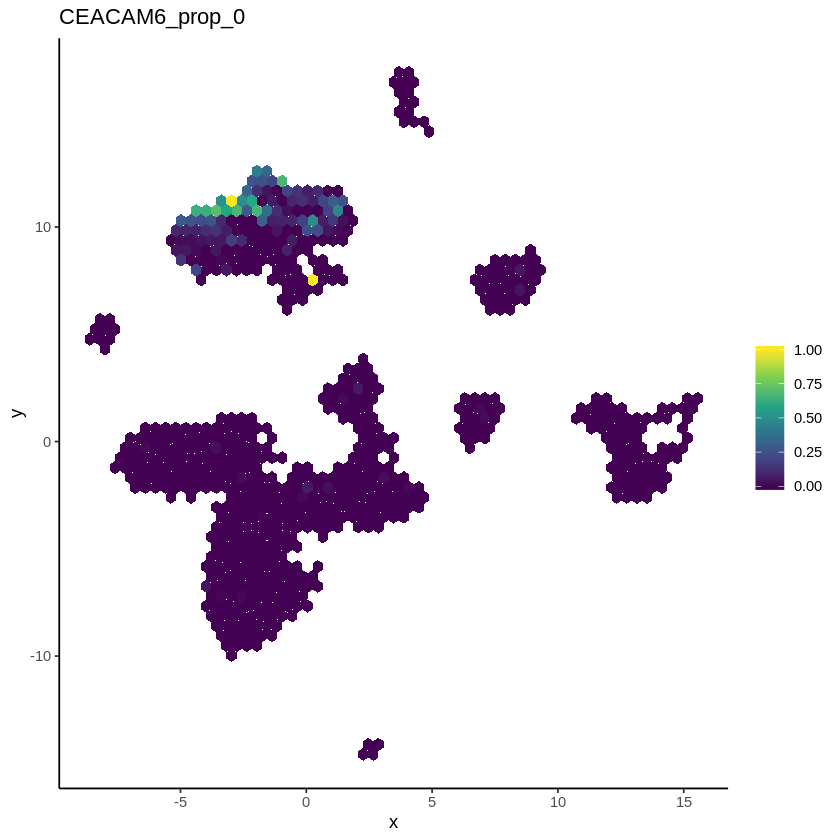

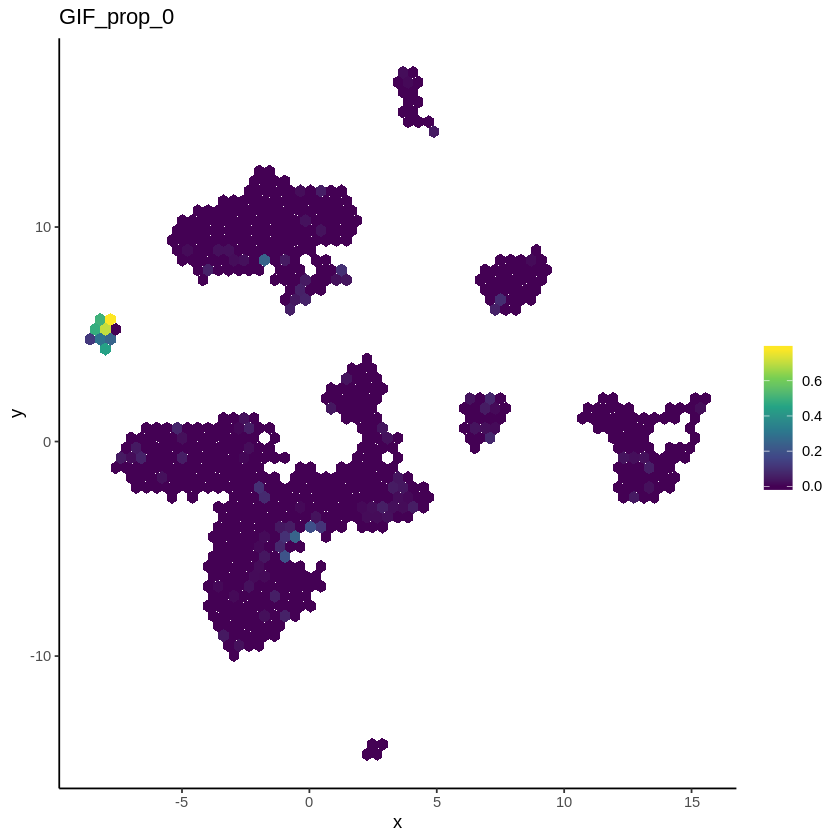

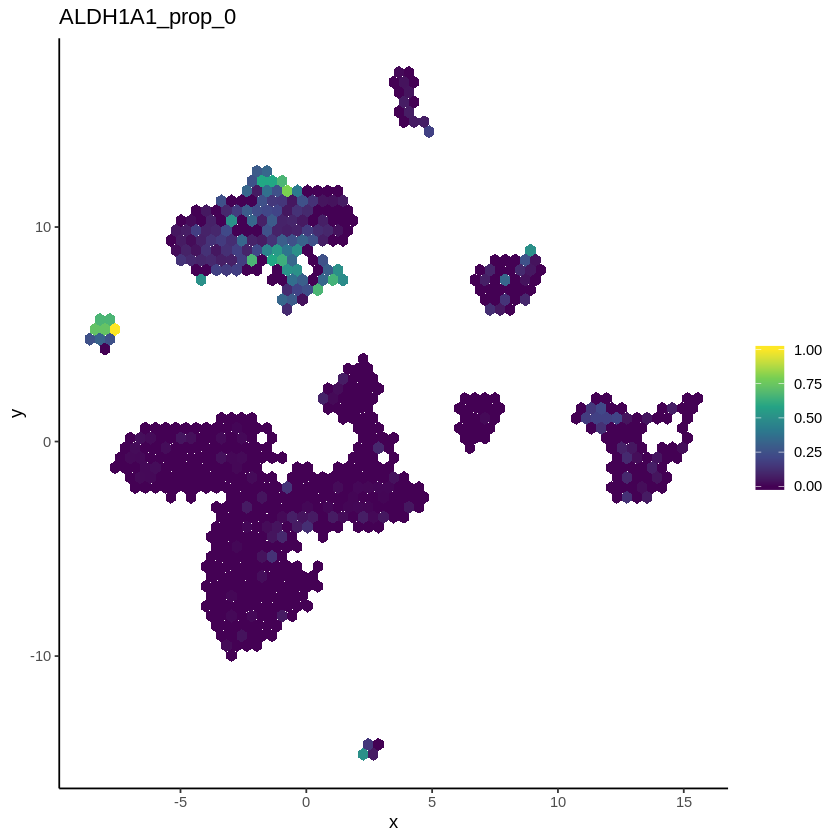

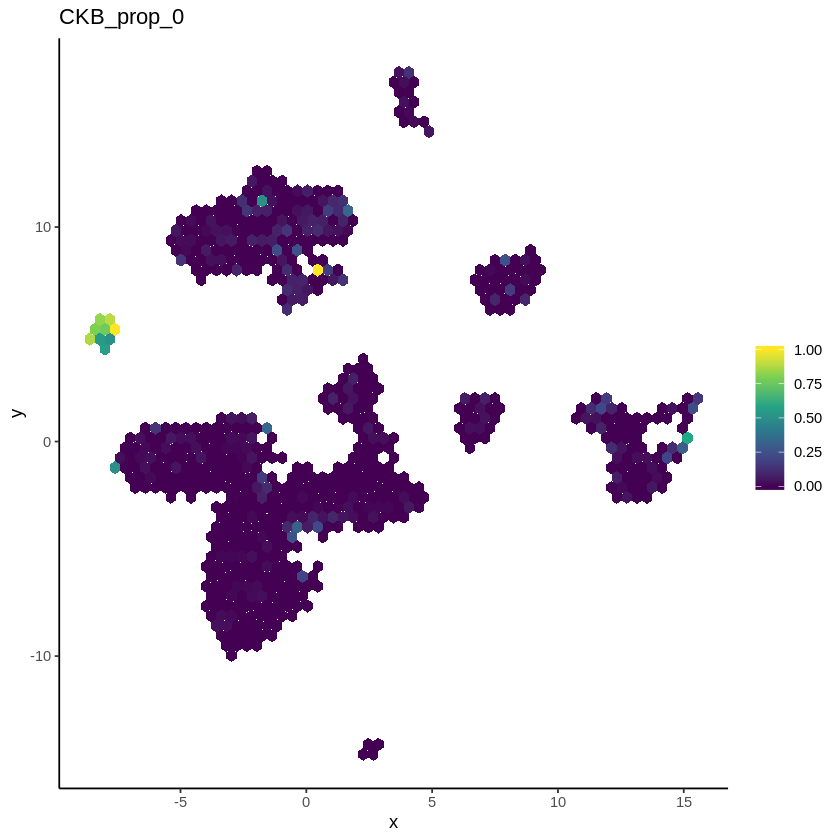

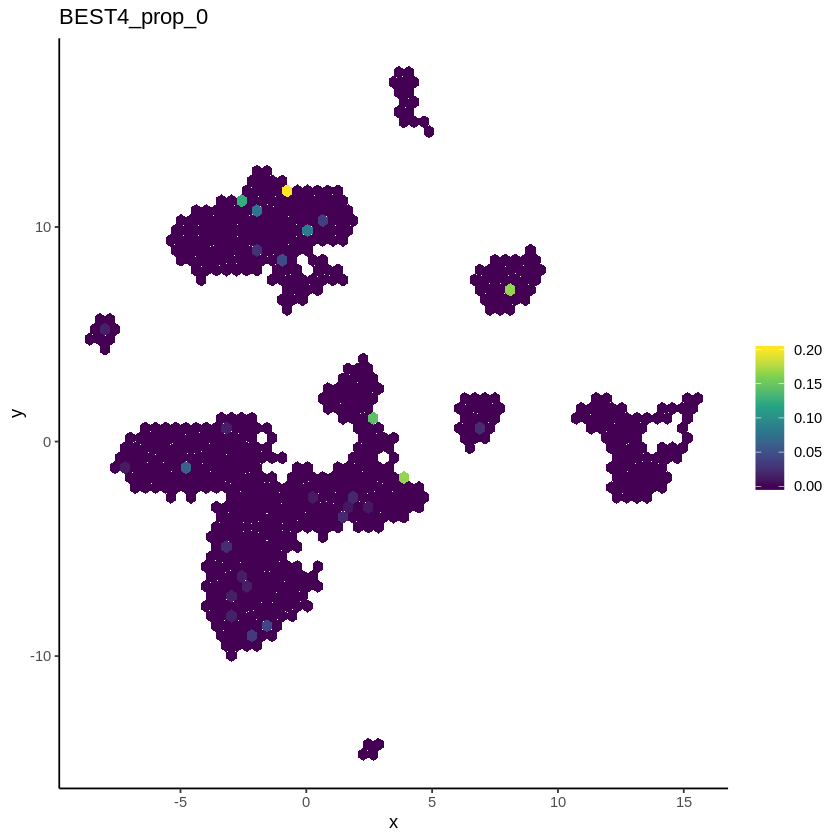

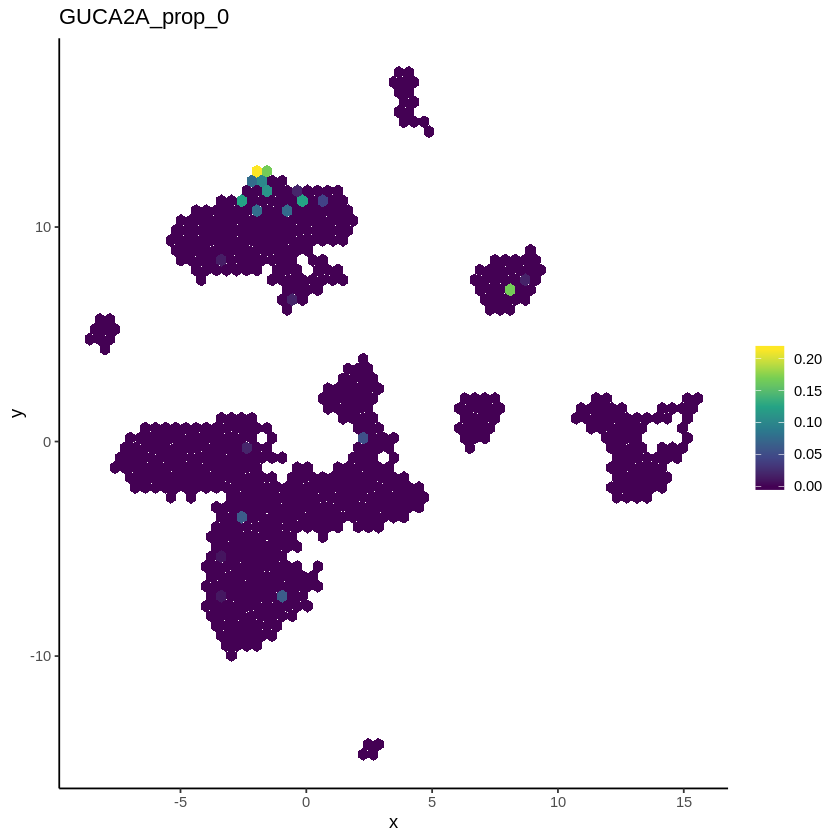

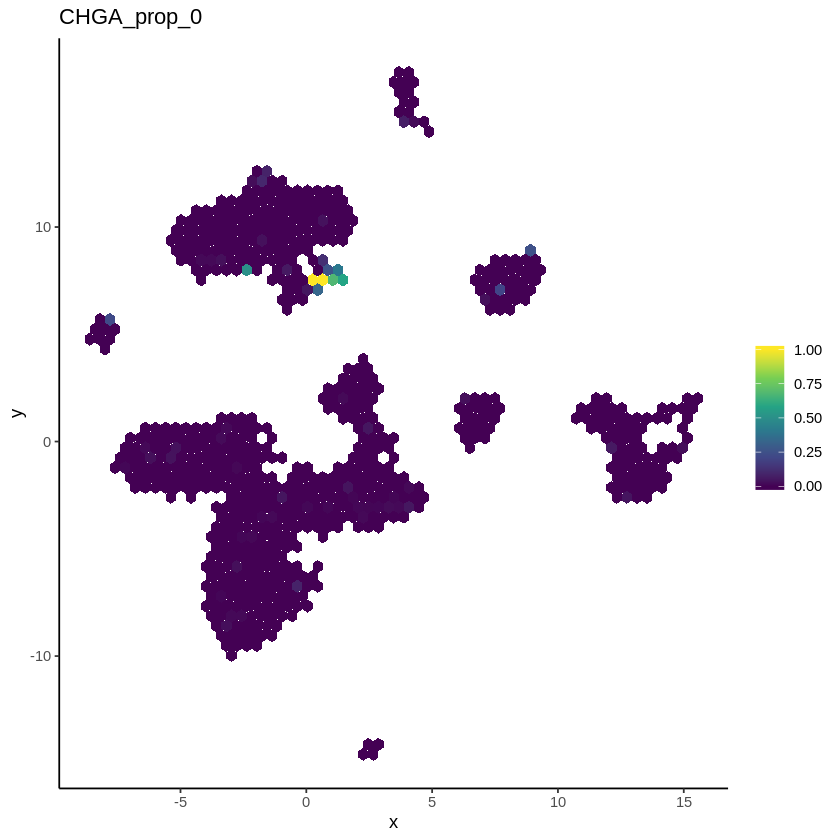

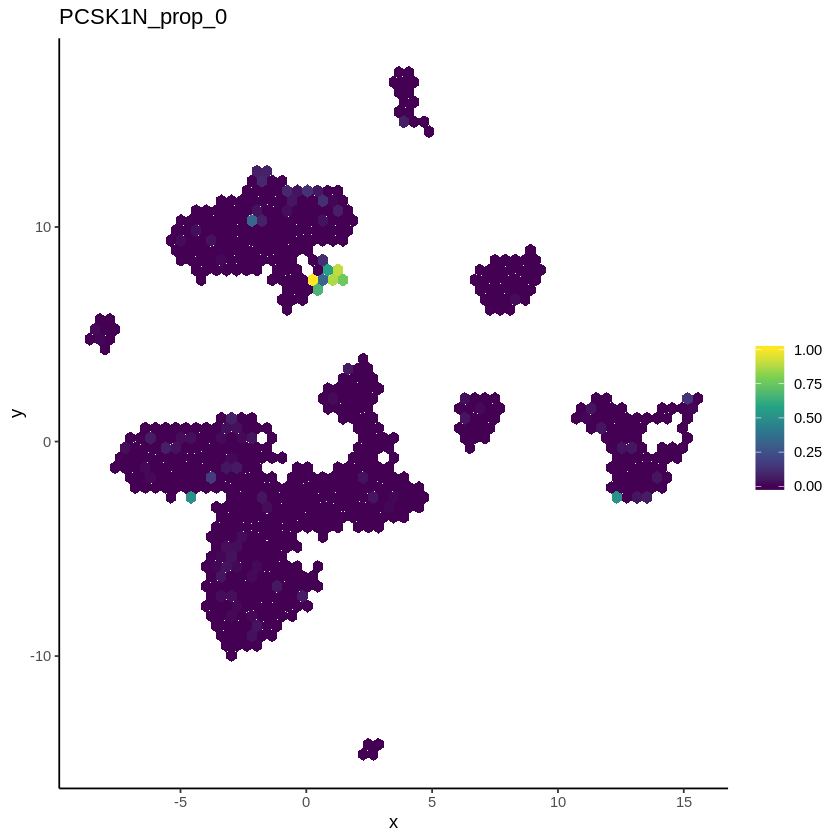

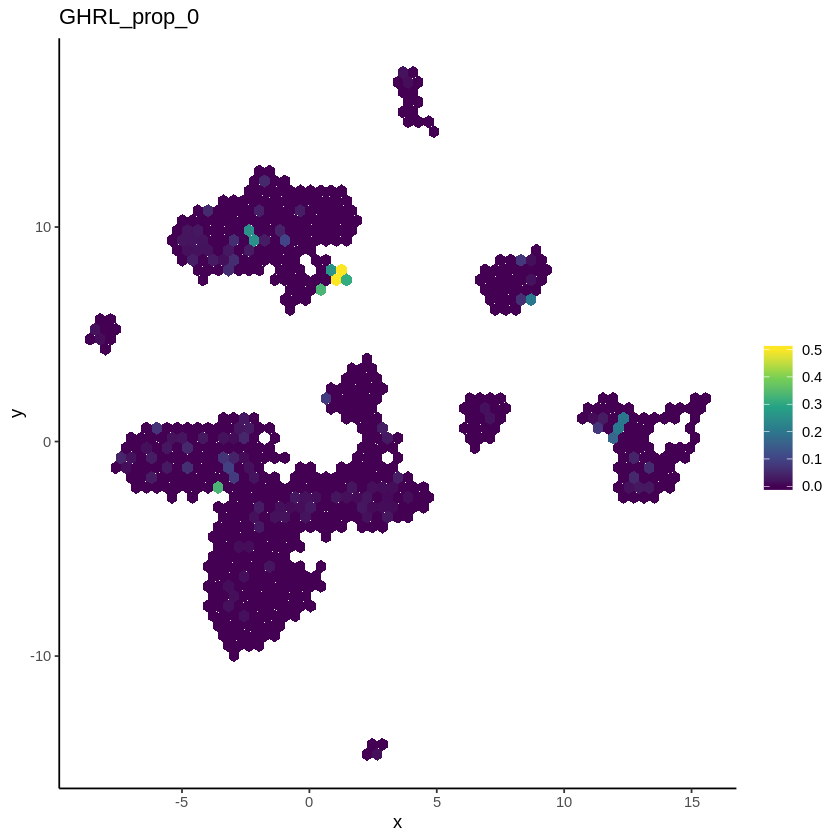

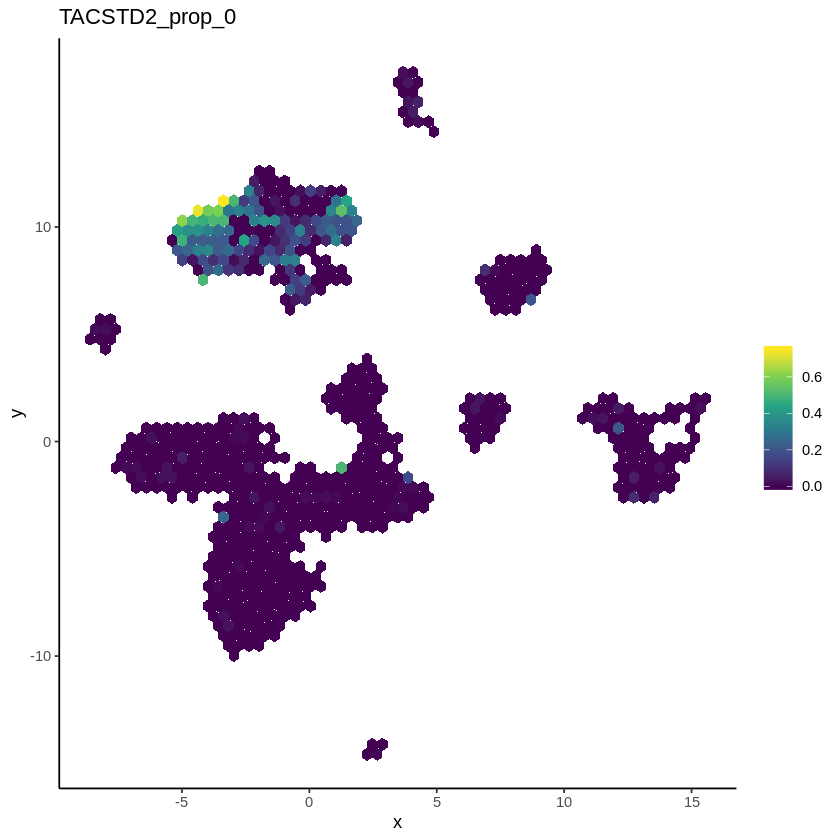

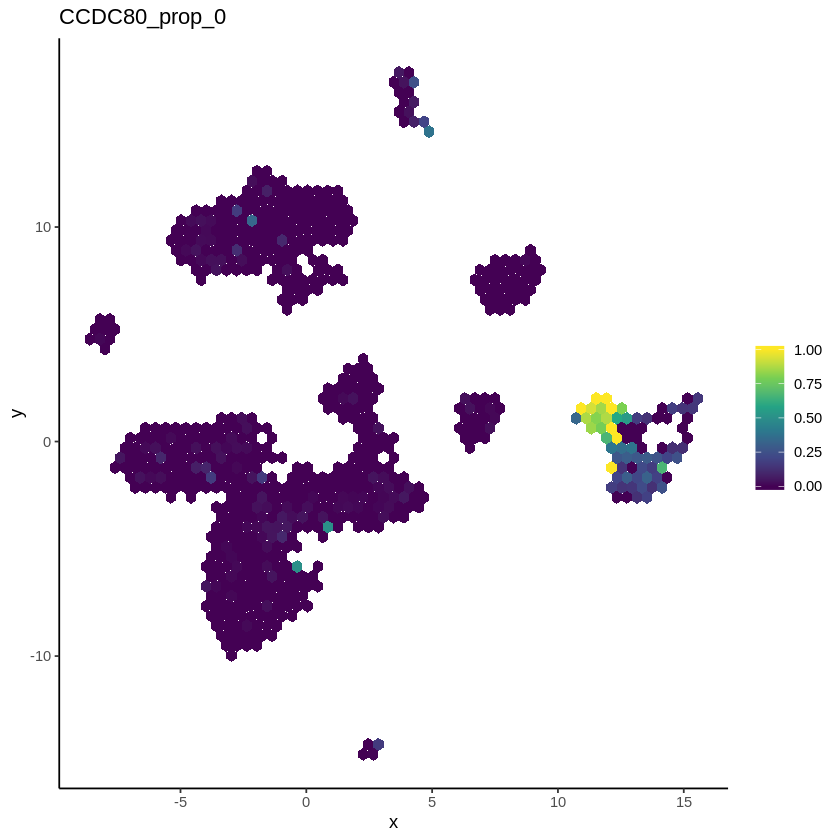

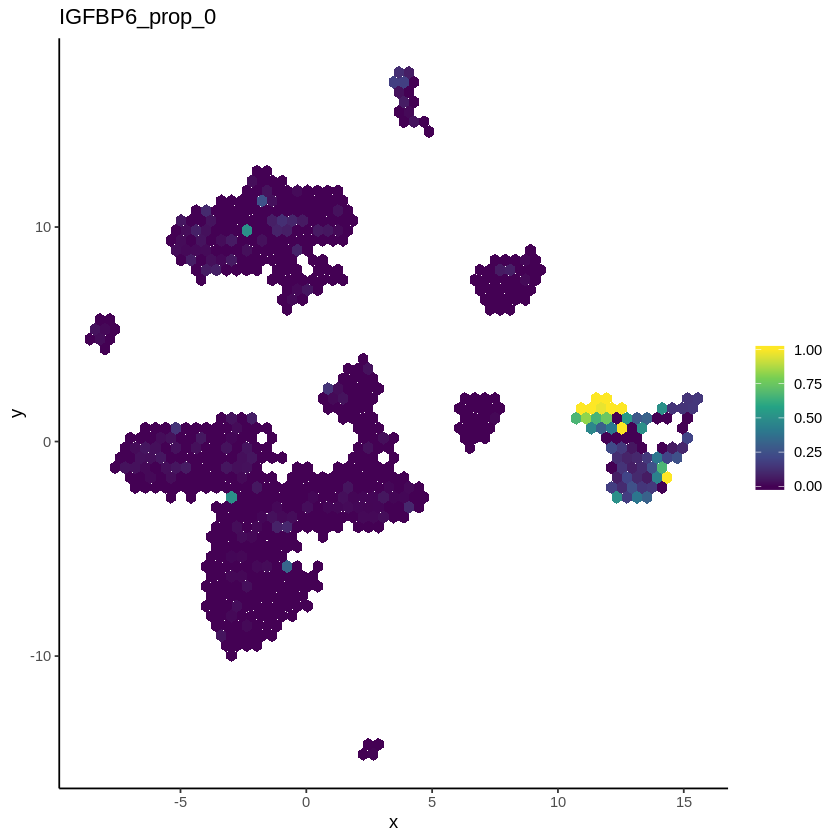

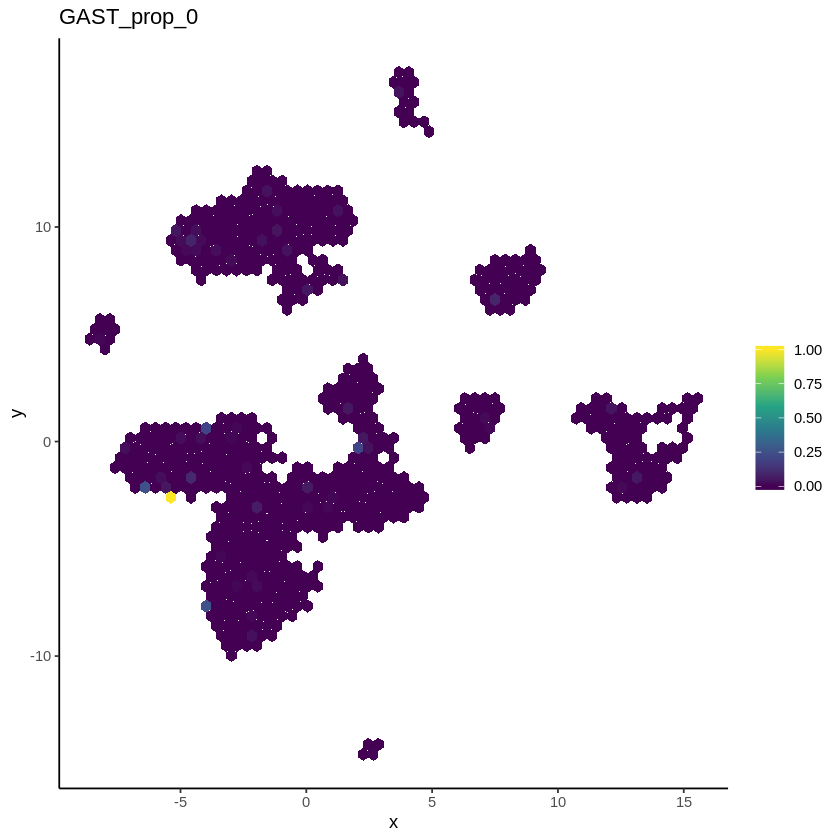

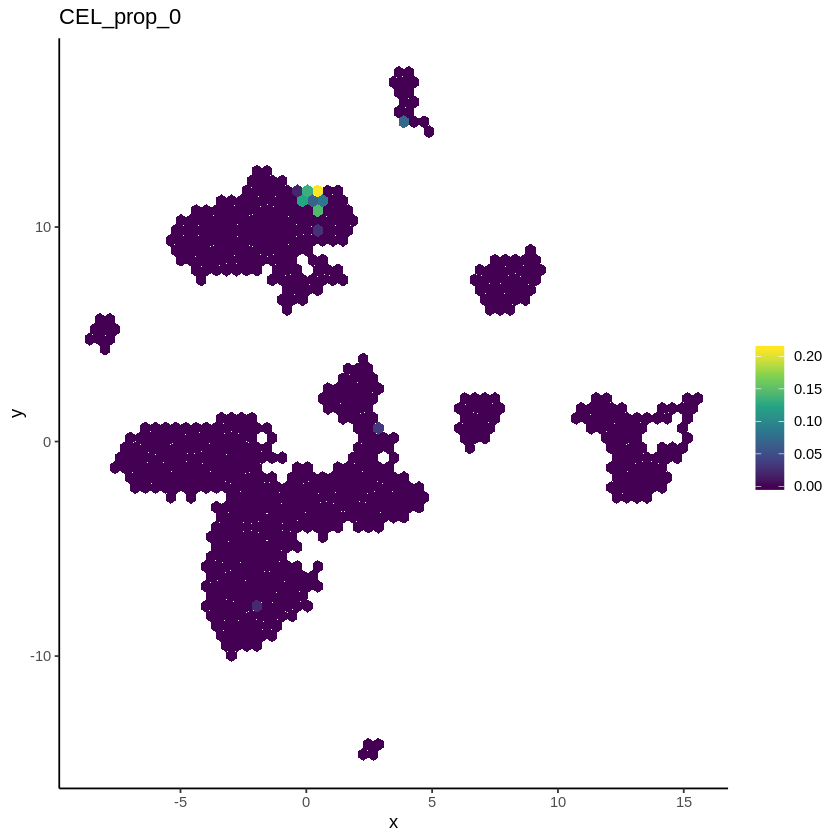

In [50]:
for (i in 1:length(epi_markers)){
    p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = epi_markers[i], action = "prop_0")
    plot(p1)
}

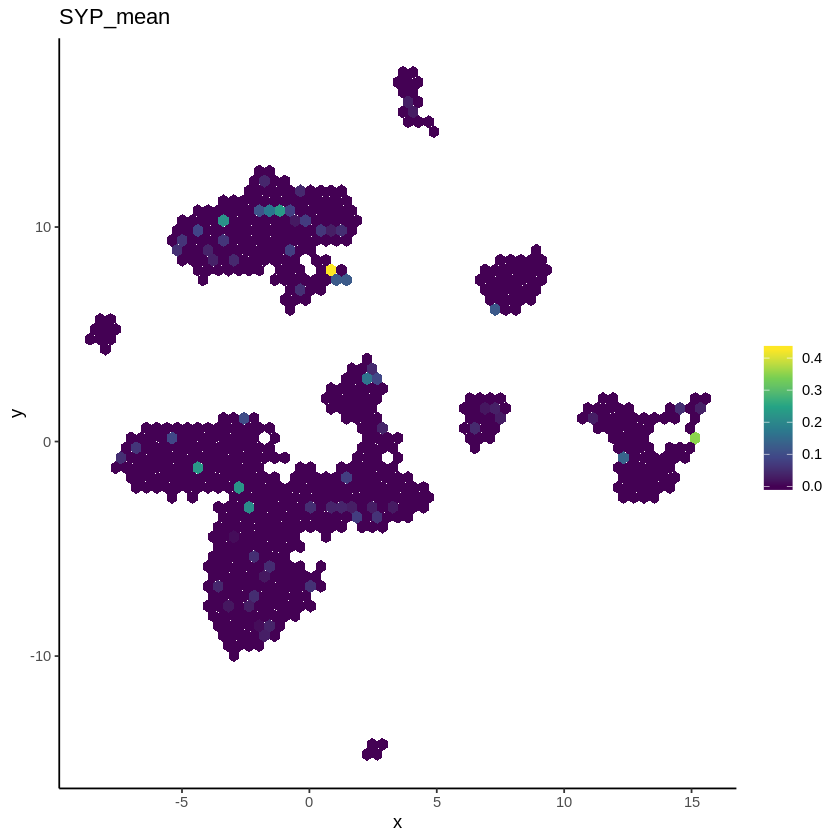

In [51]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'SYP', action = "mean")
    plot(p1)

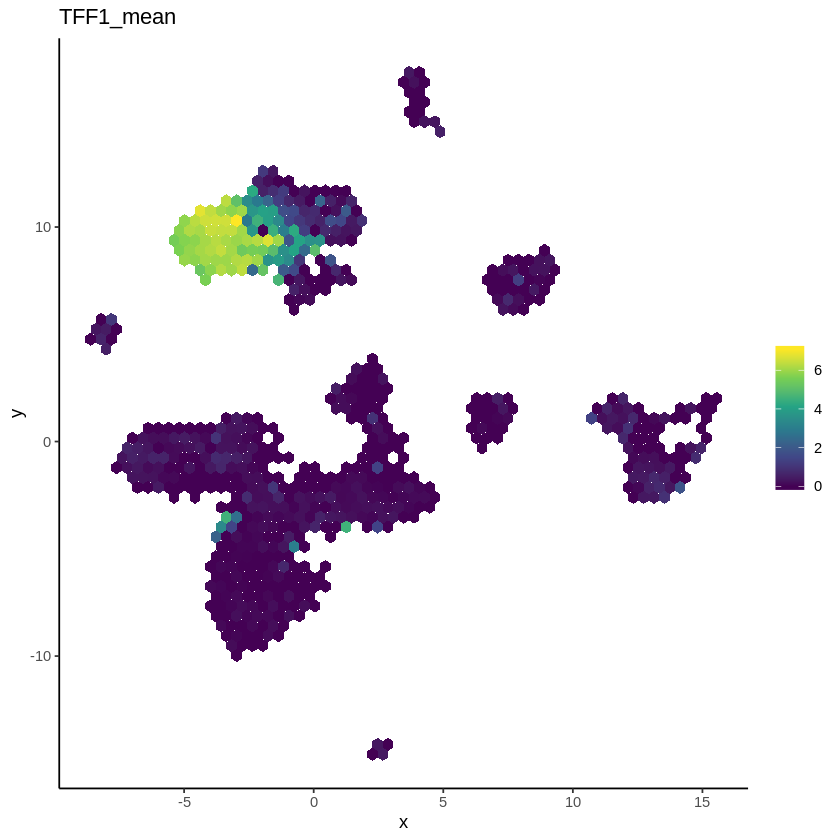

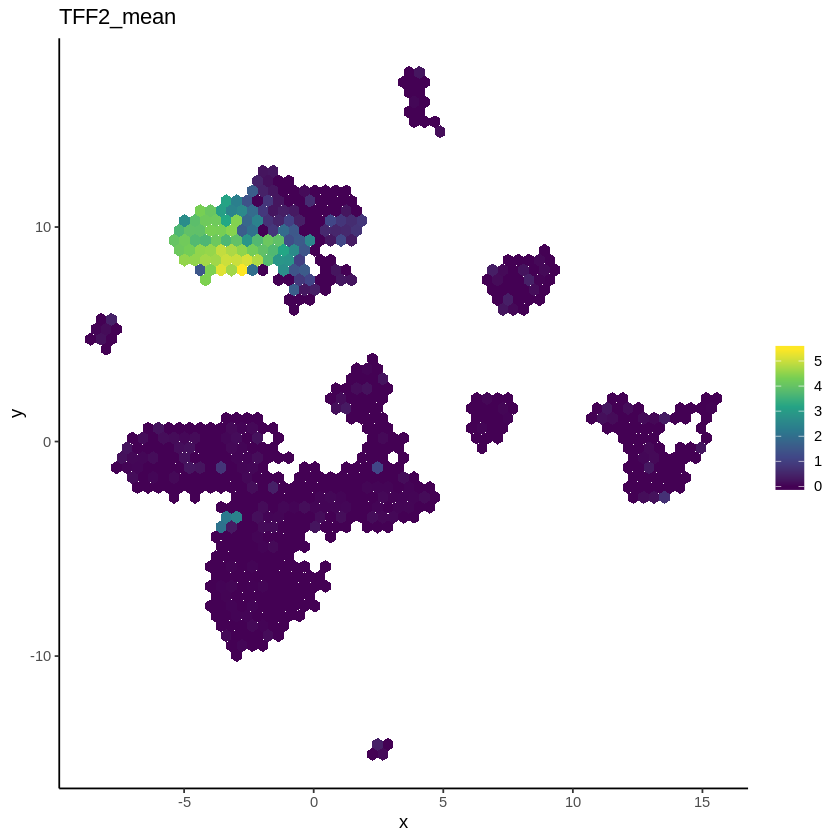

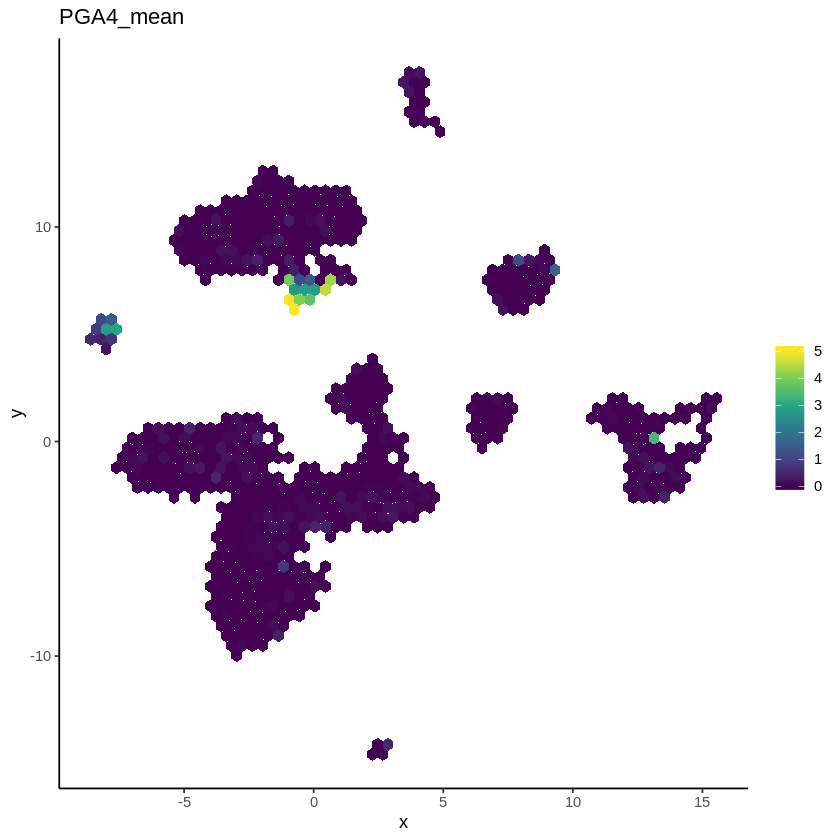

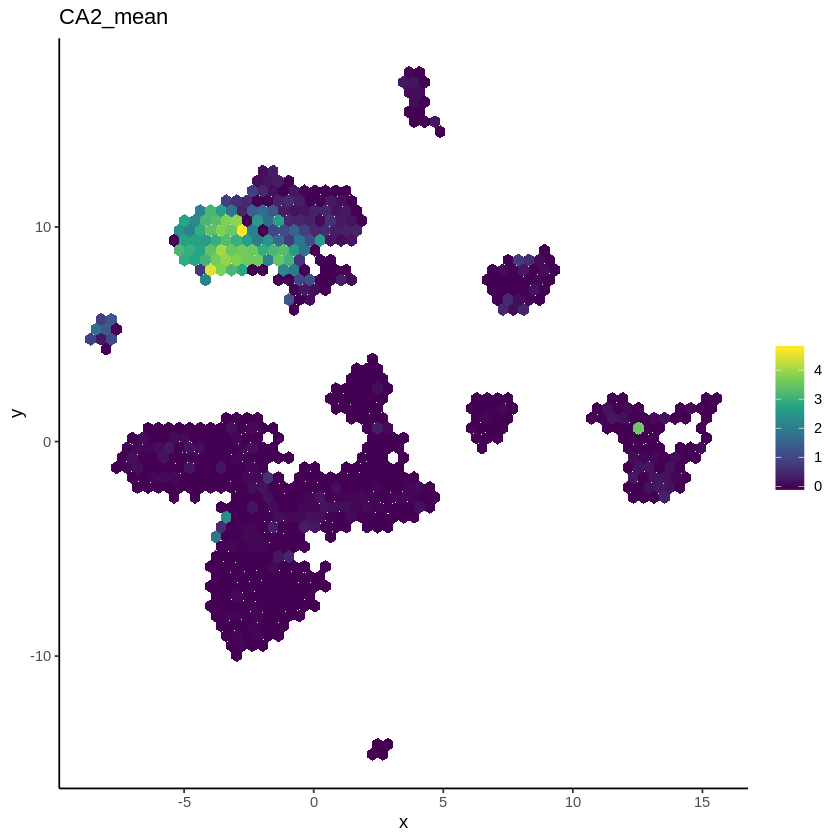

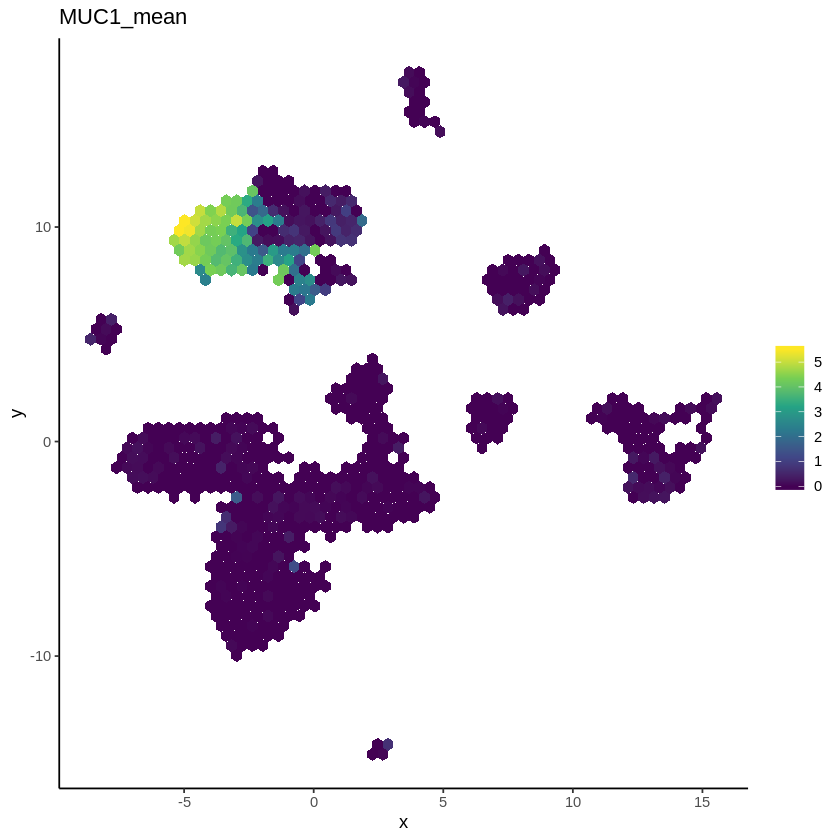

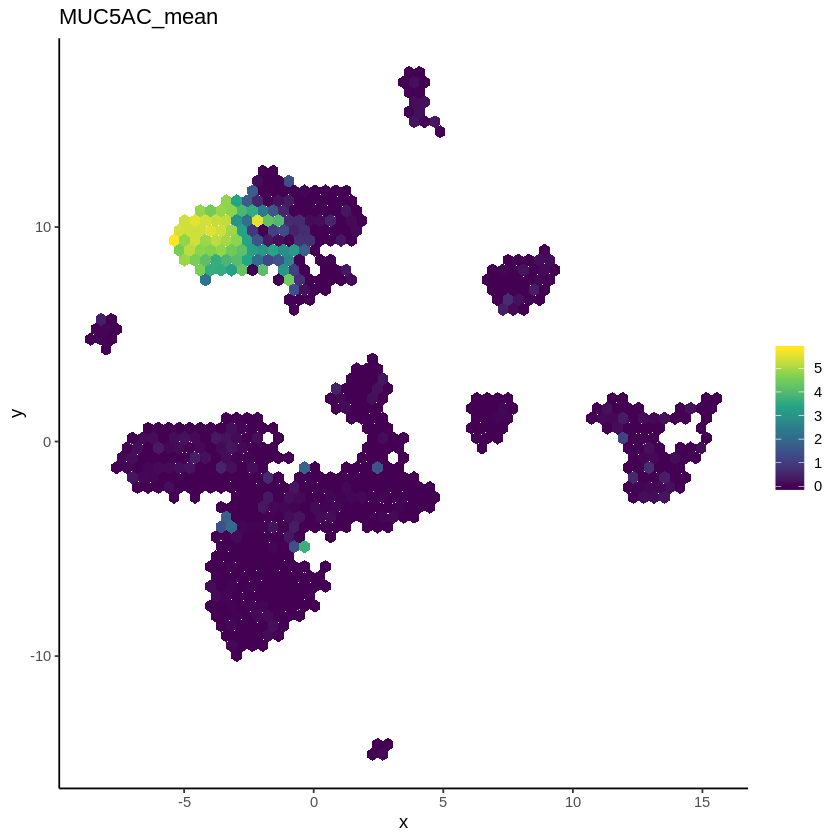

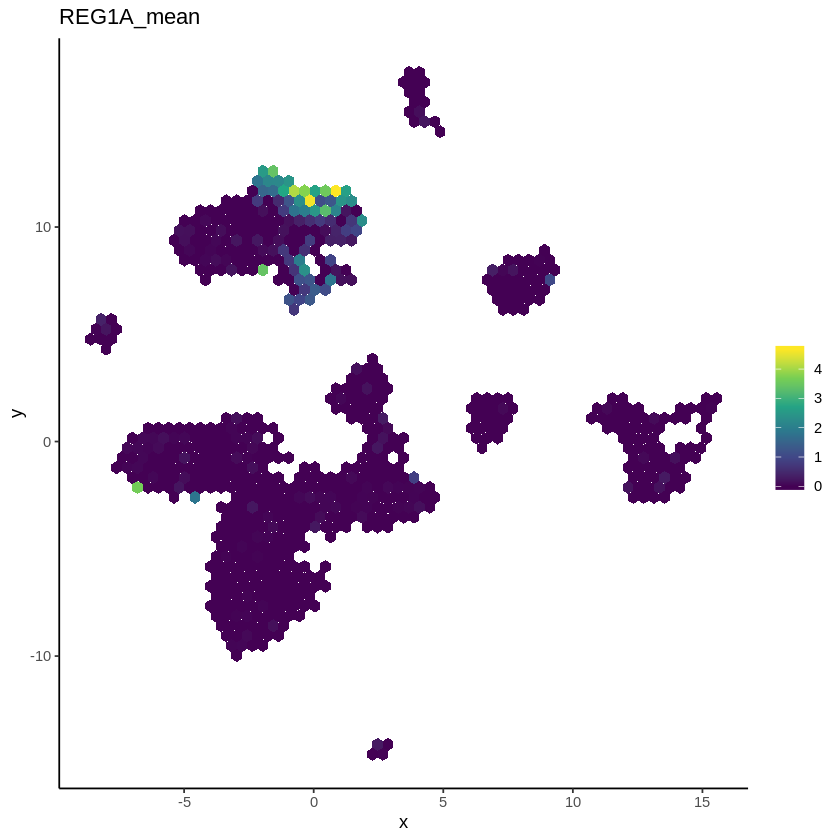

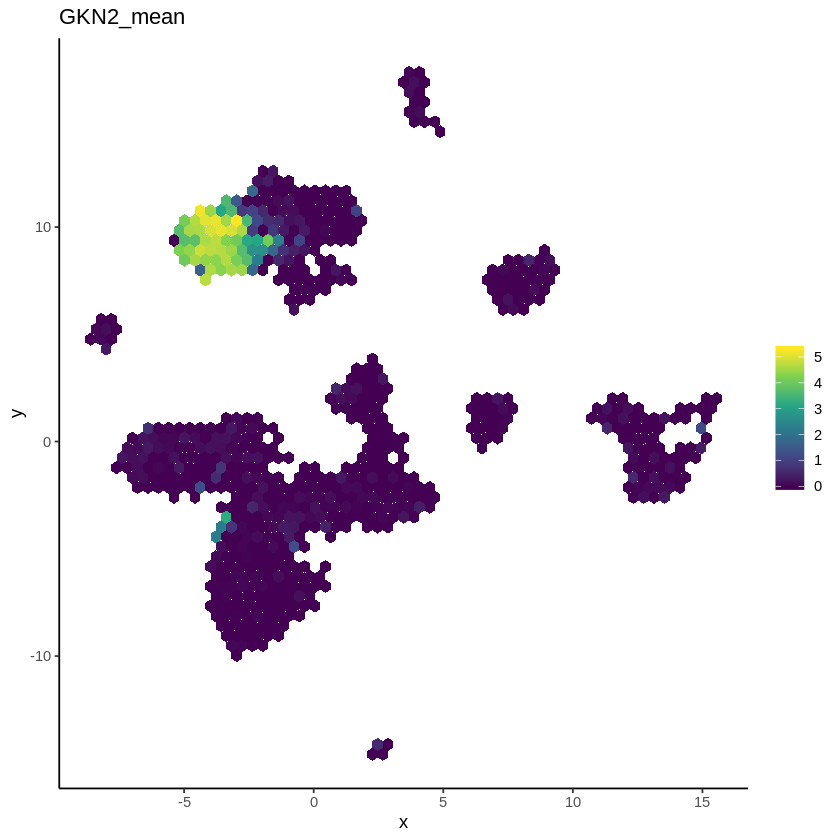

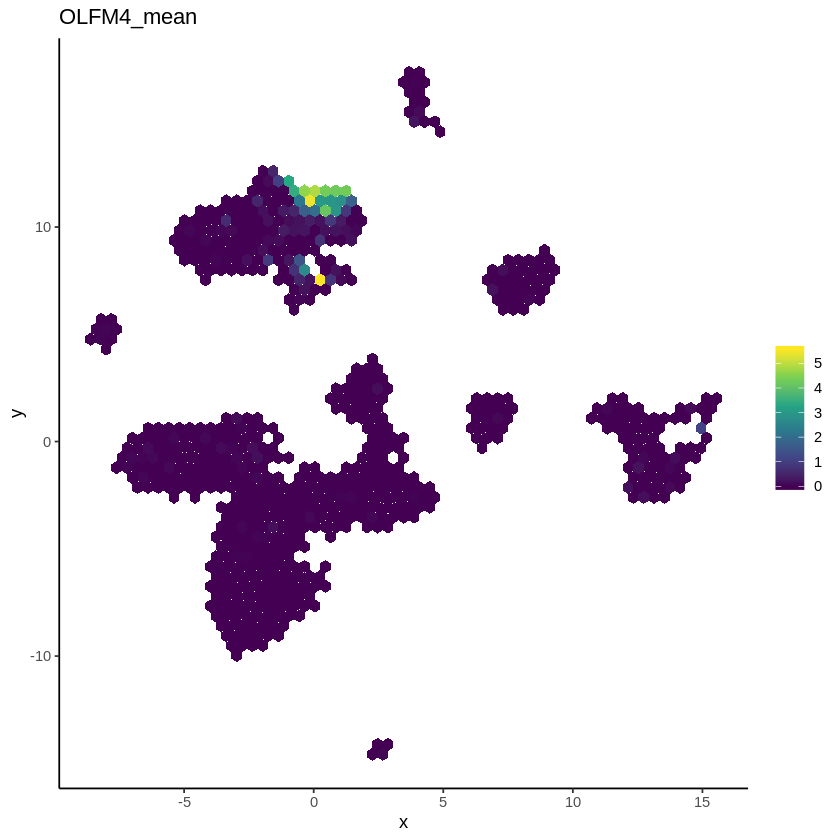

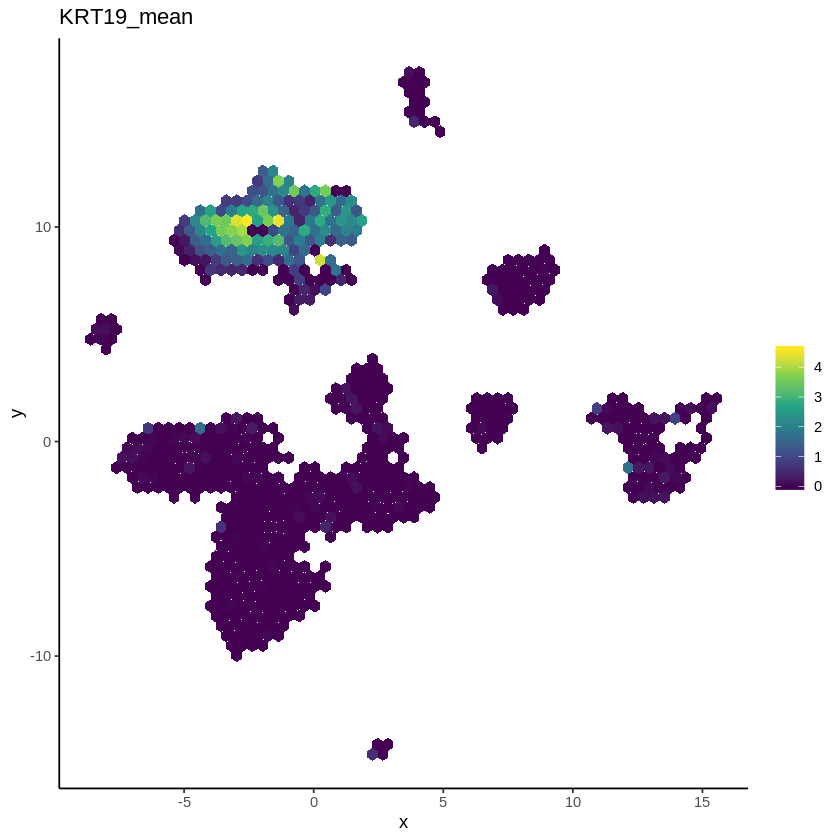

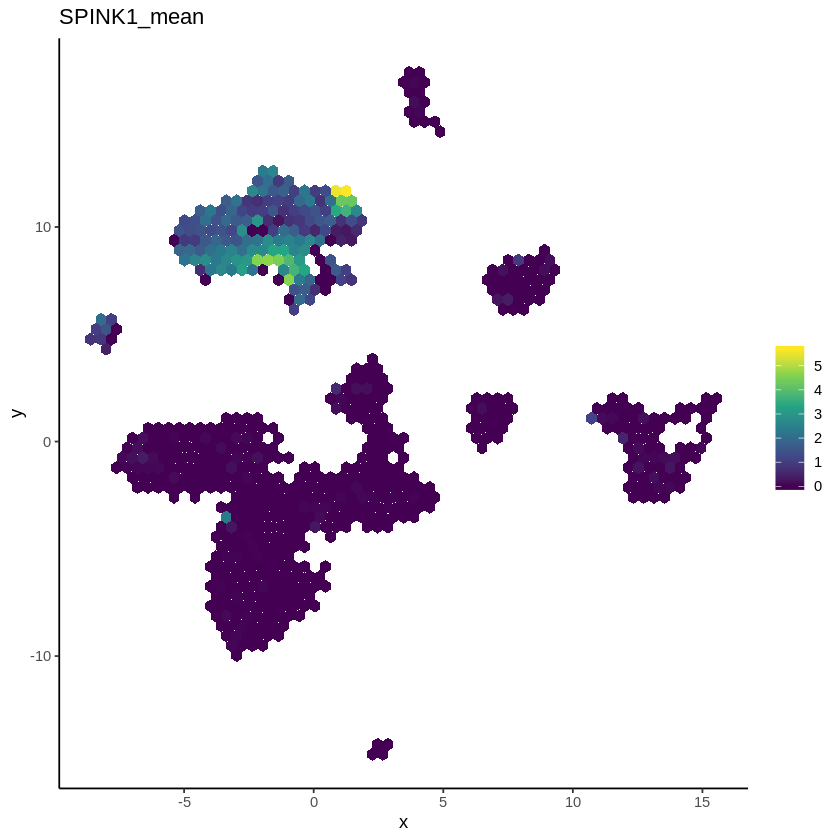

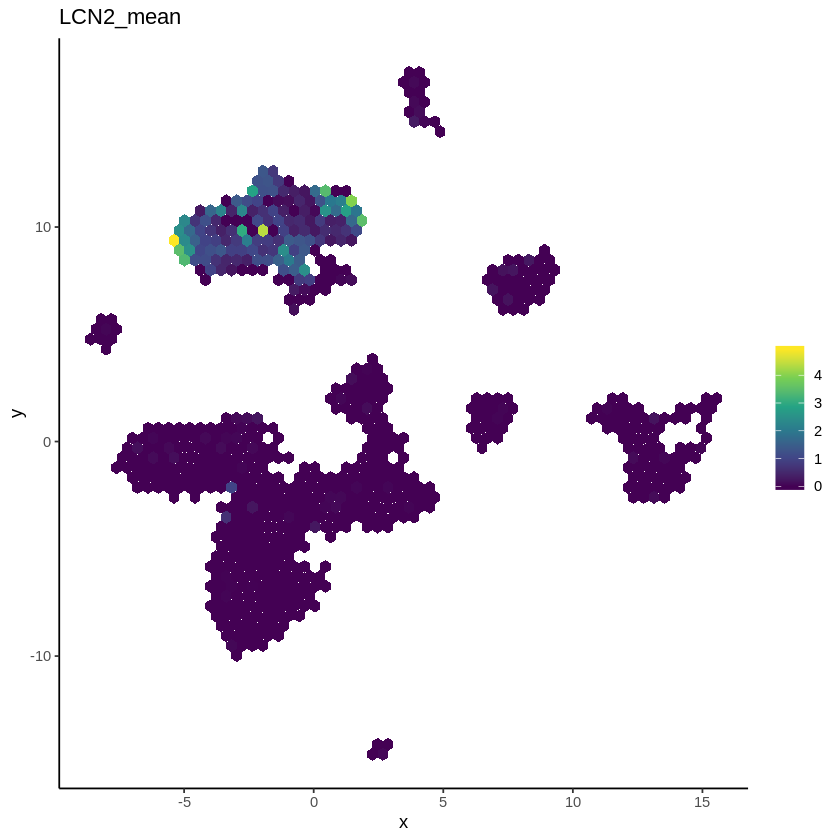

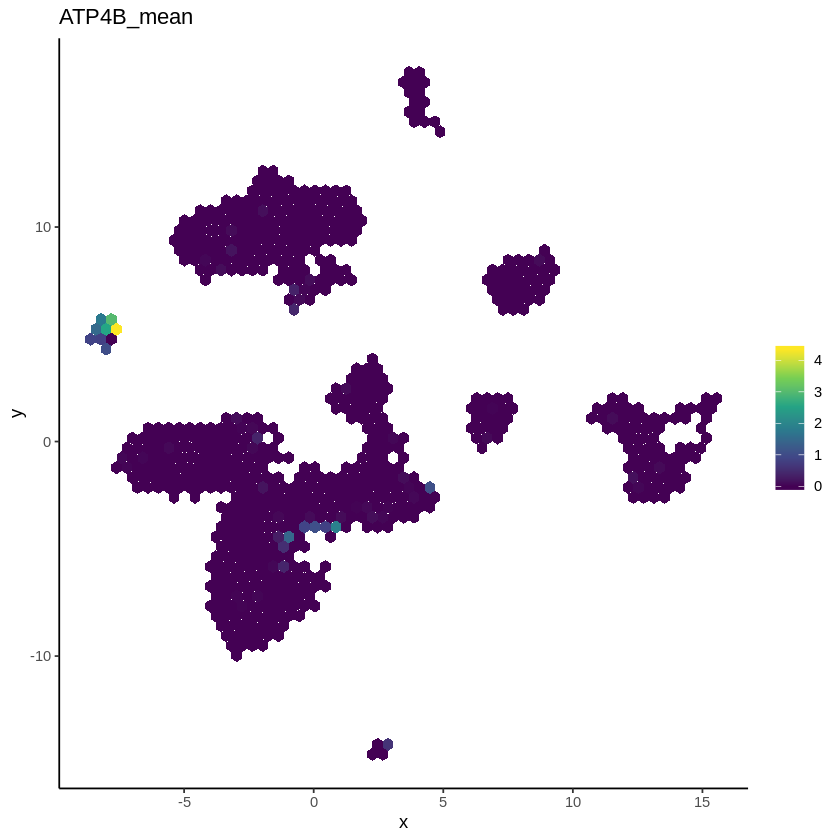

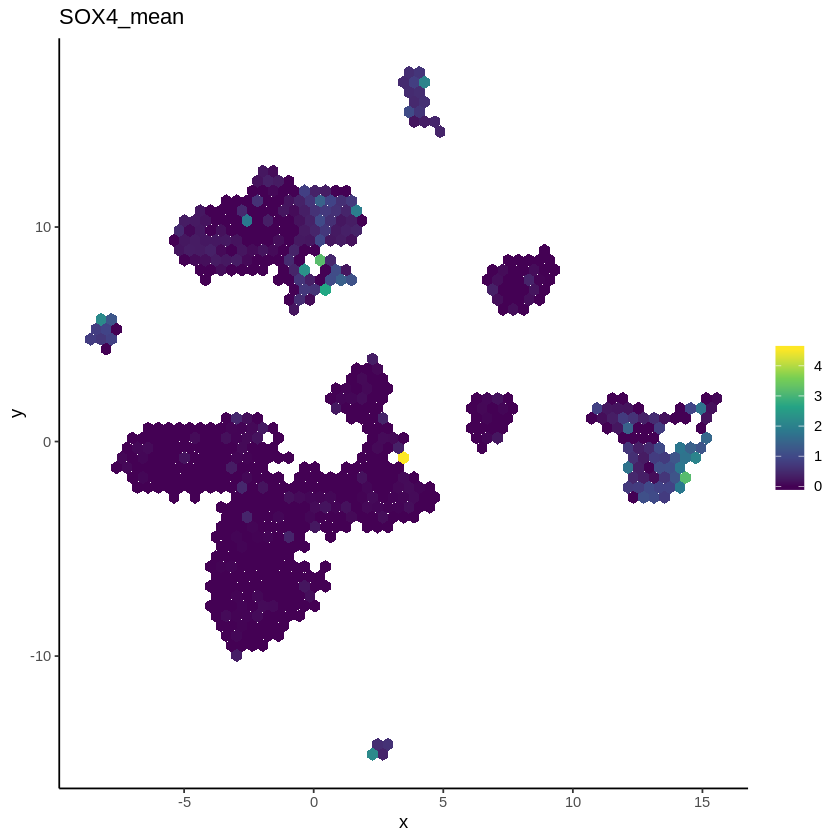

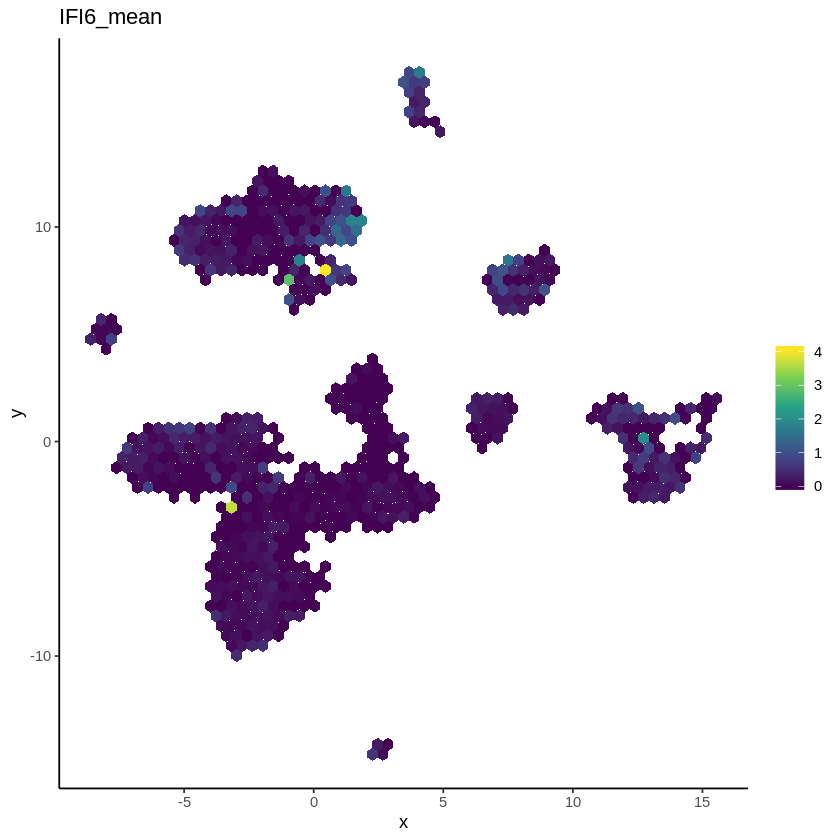

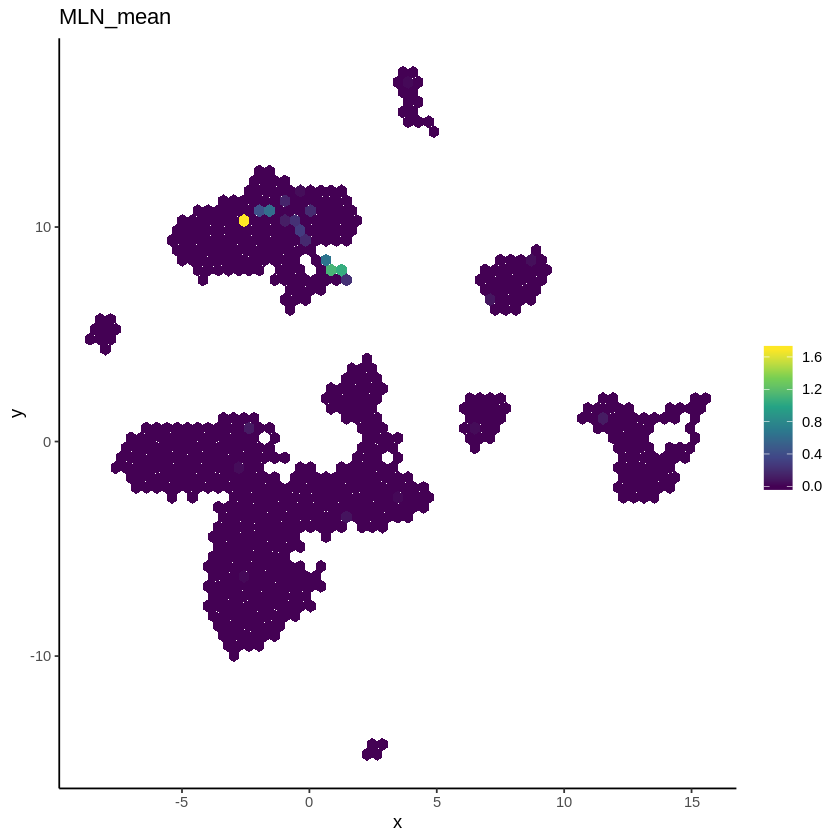

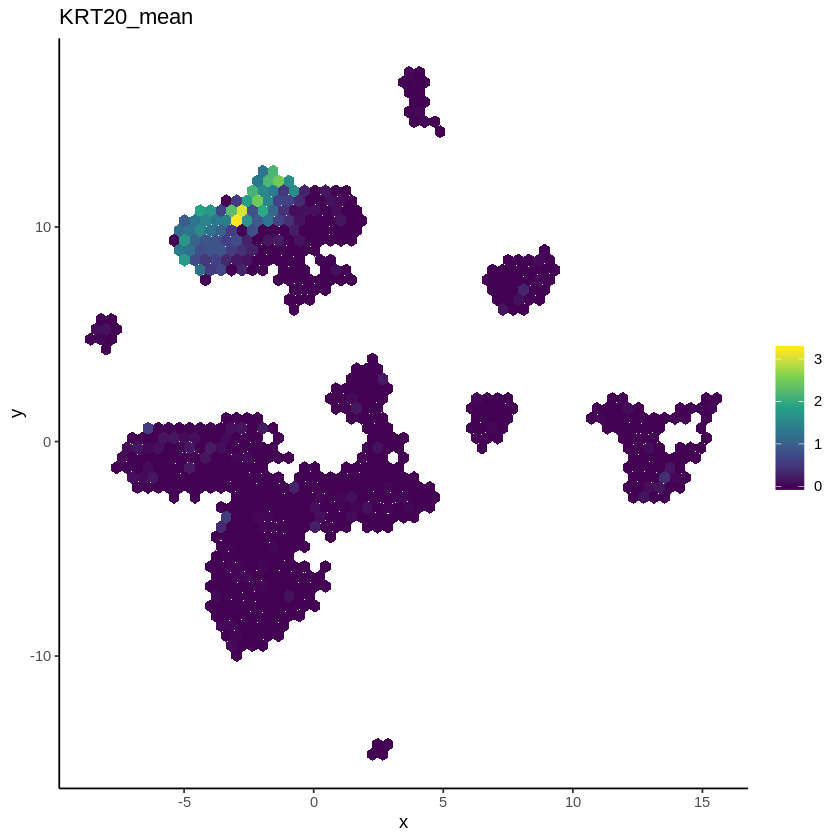

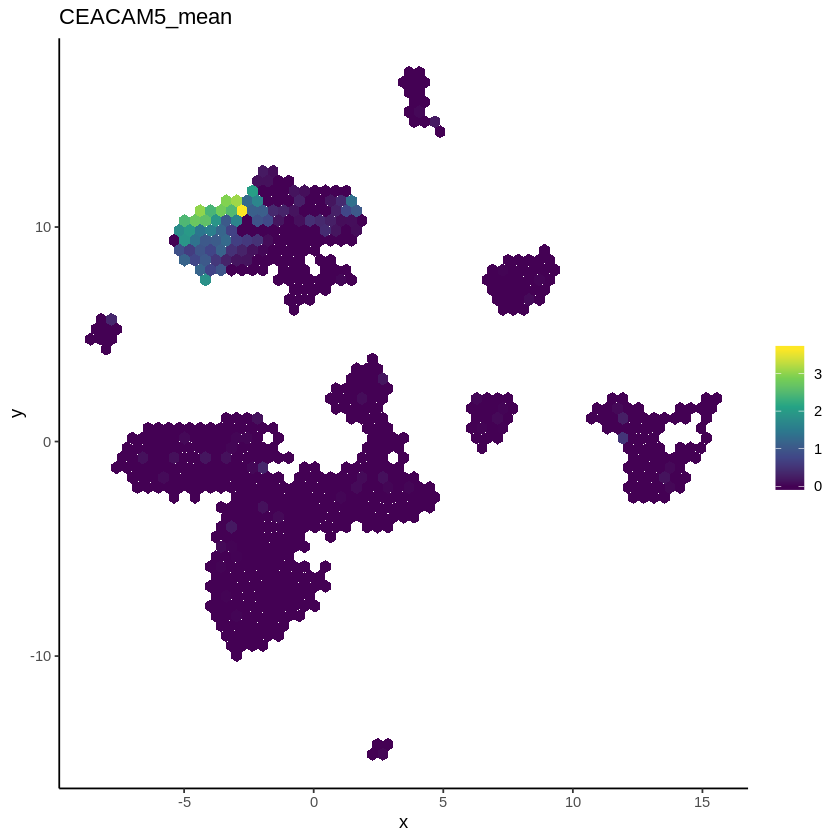

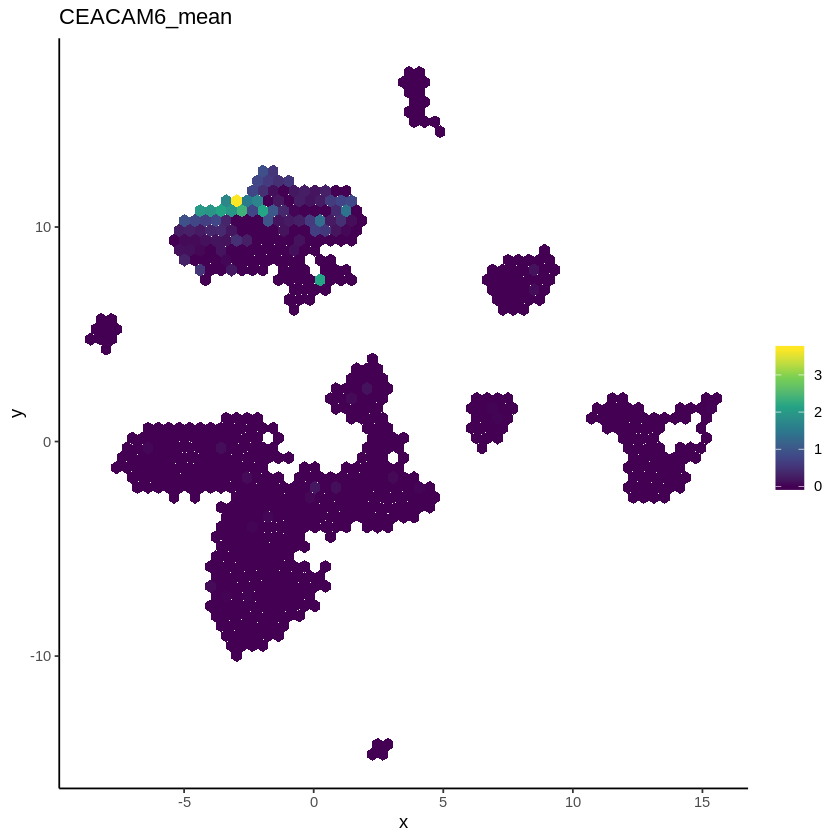

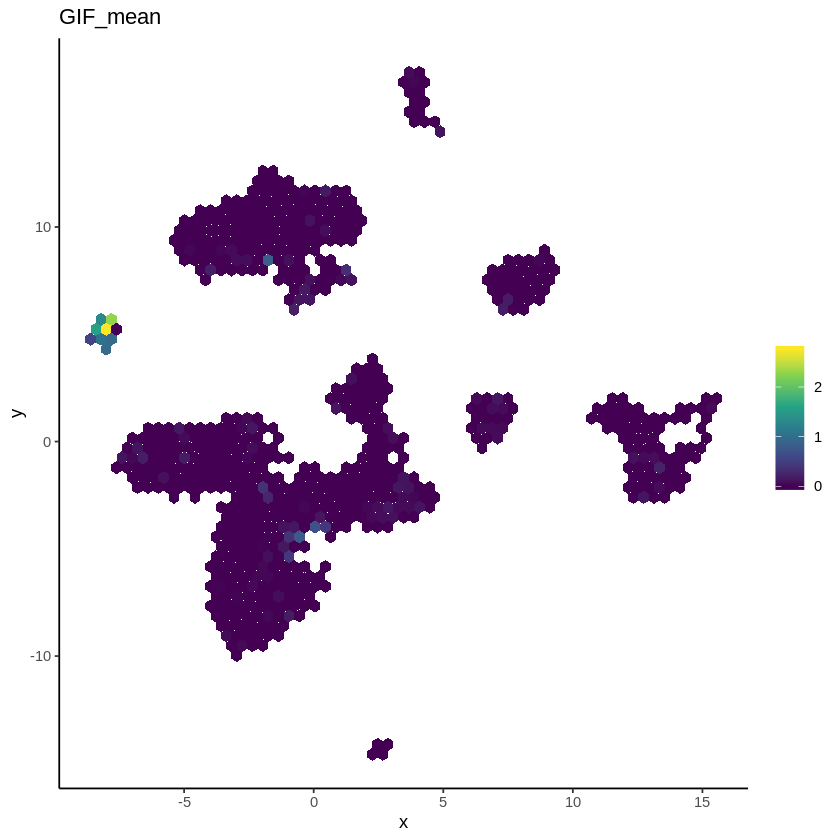

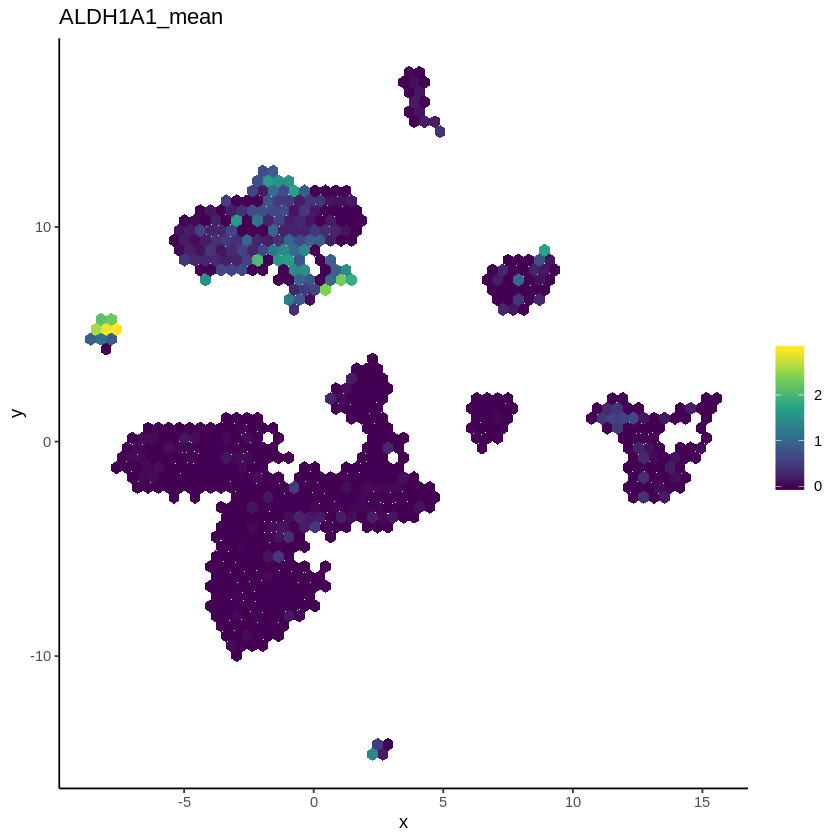

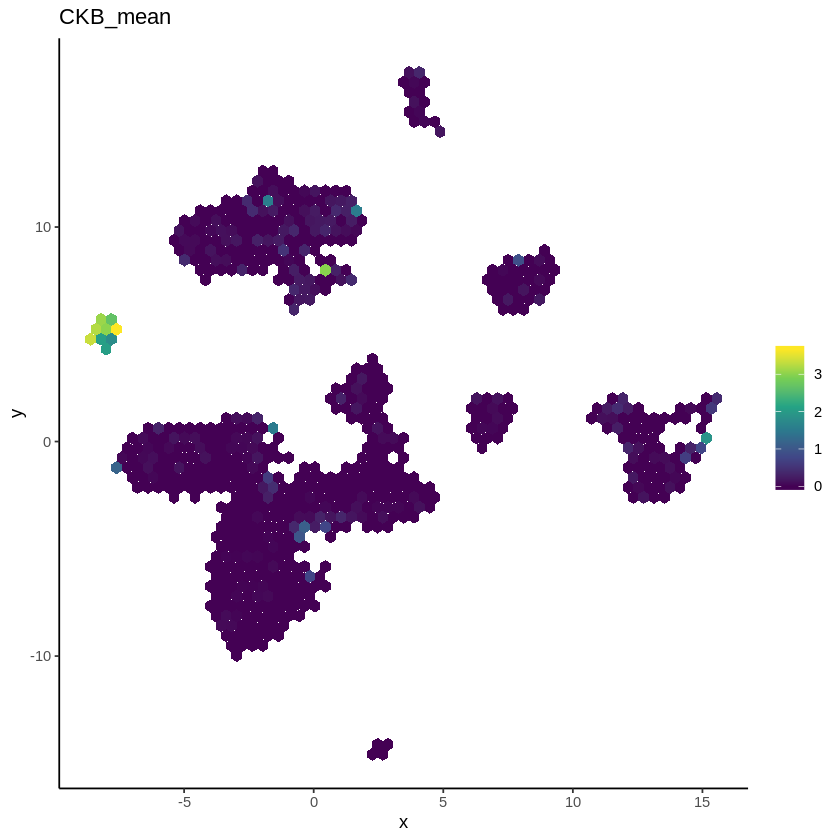

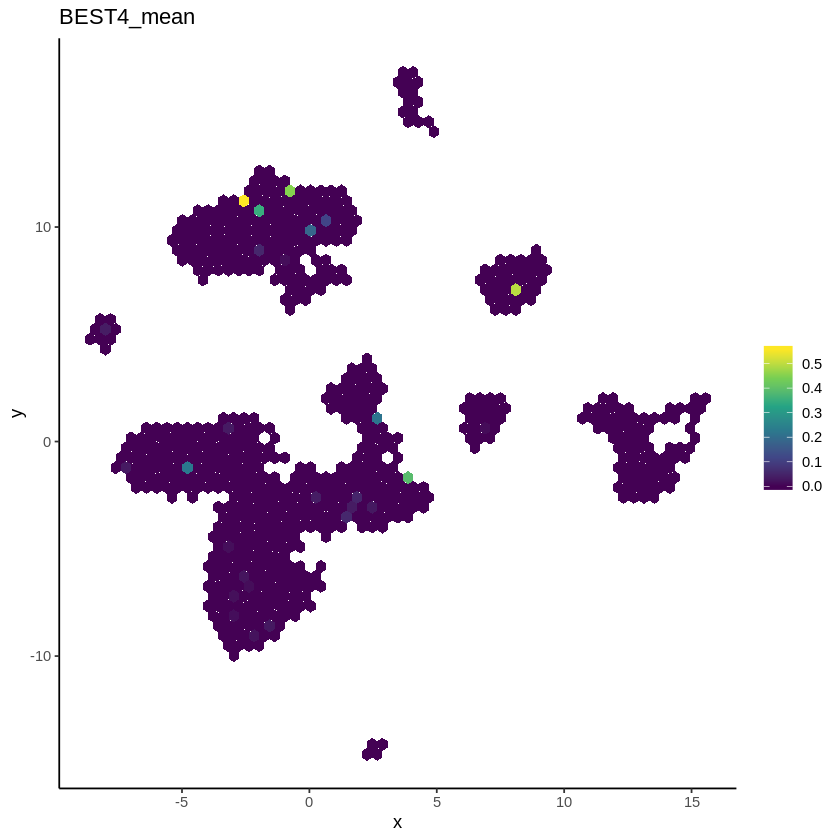

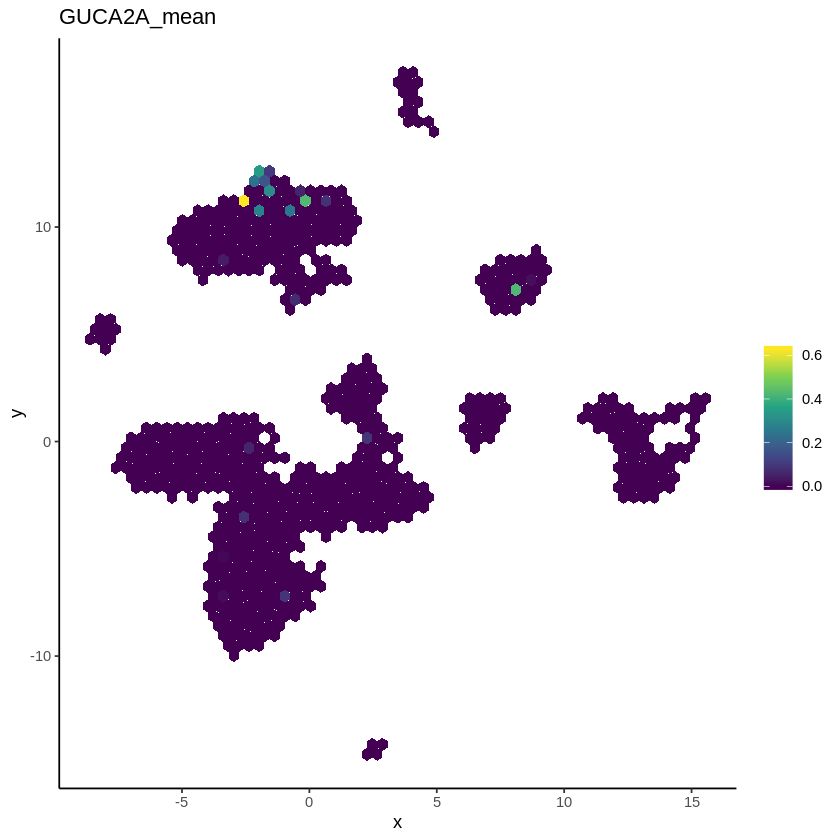

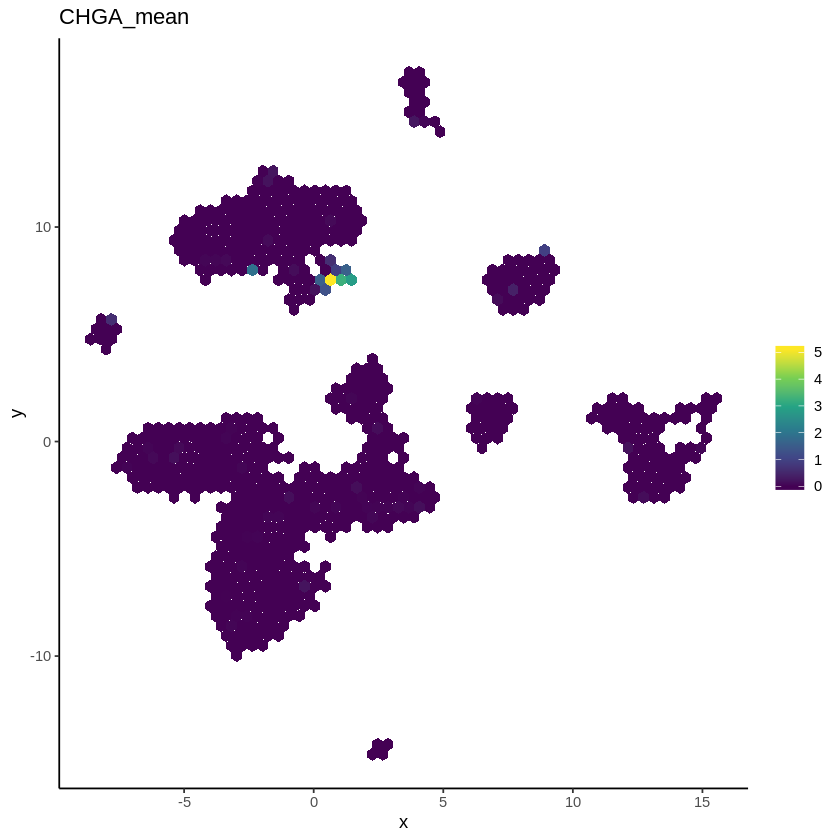

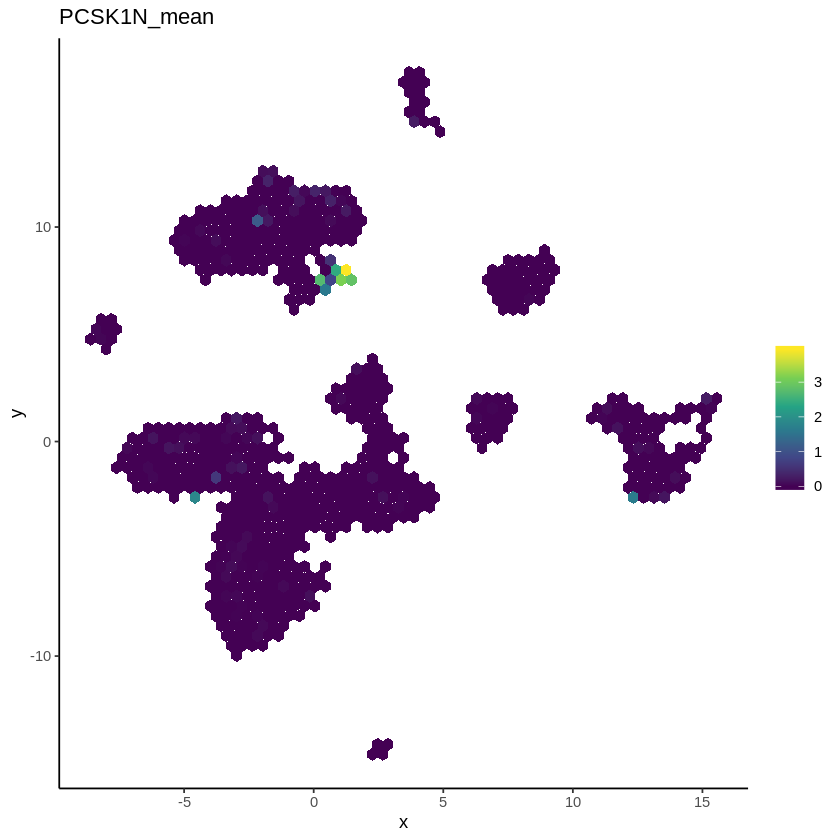

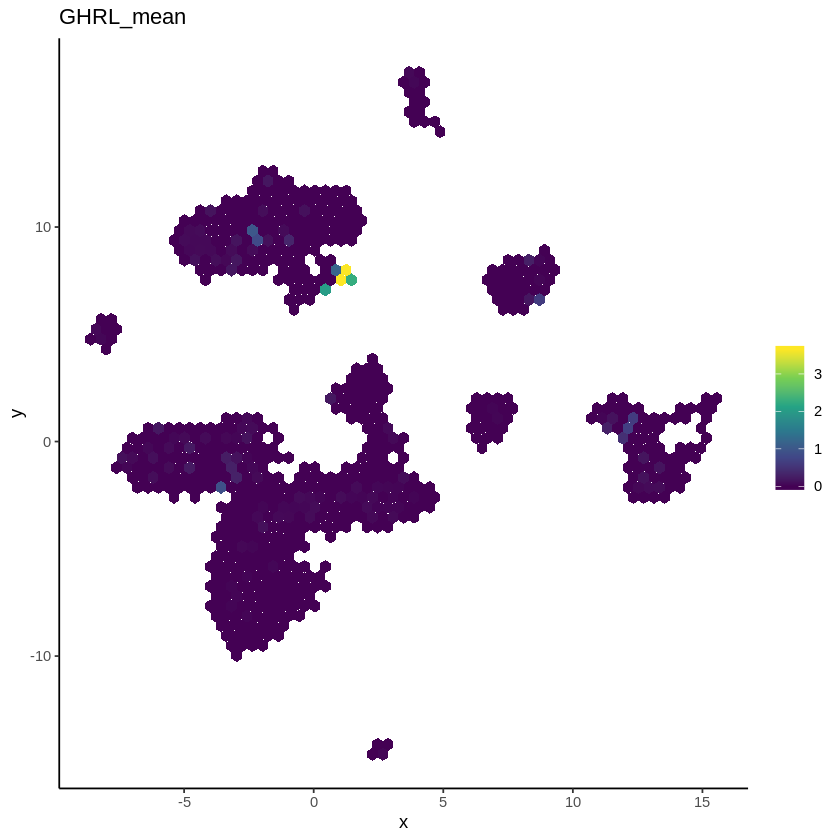

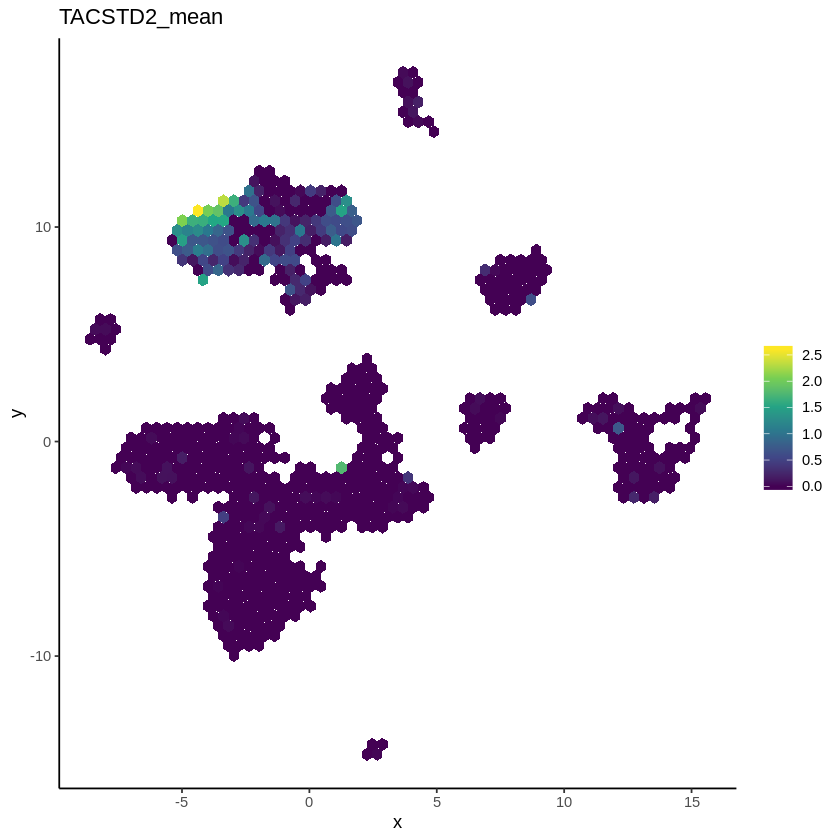

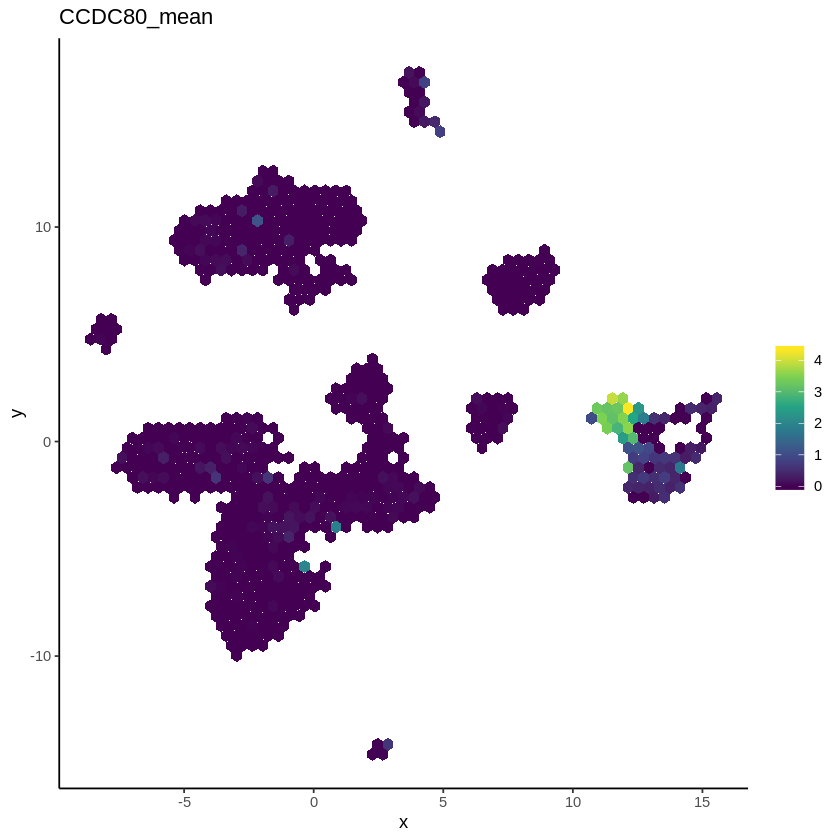

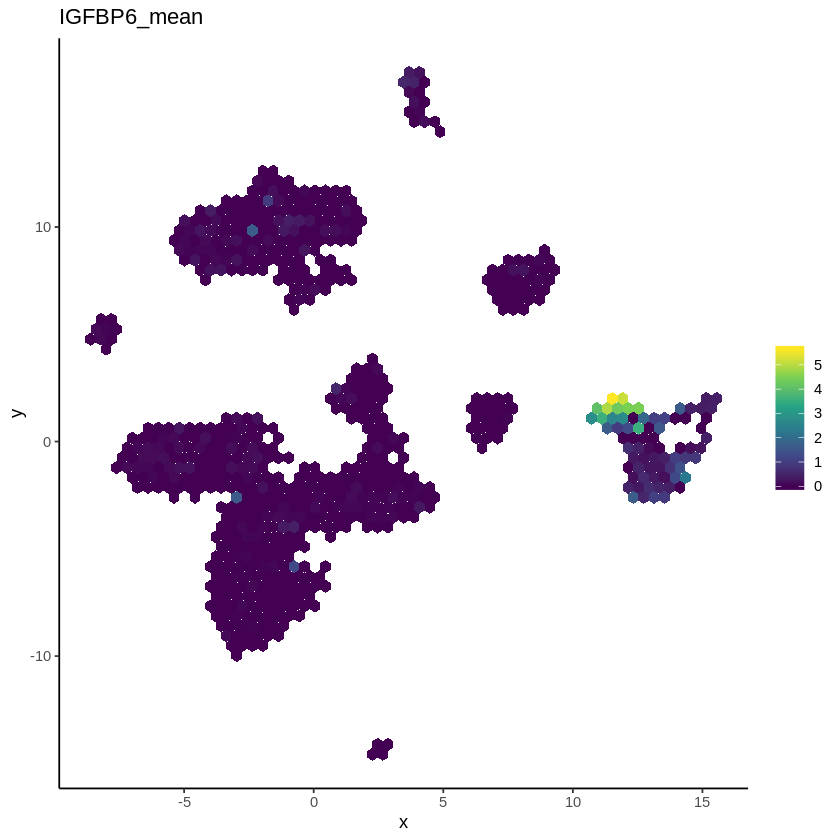

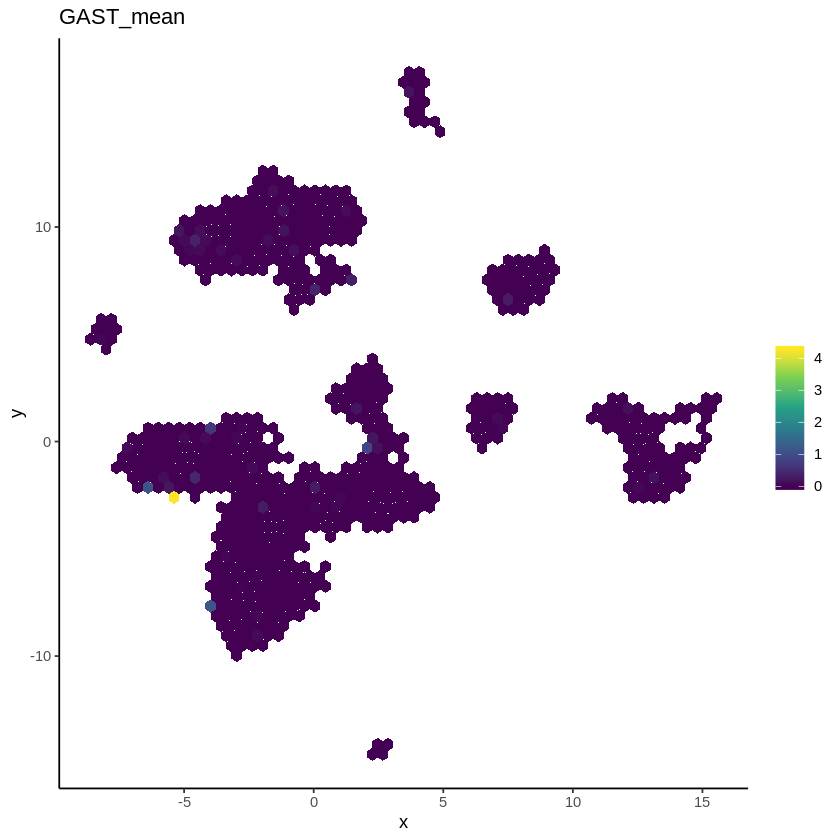

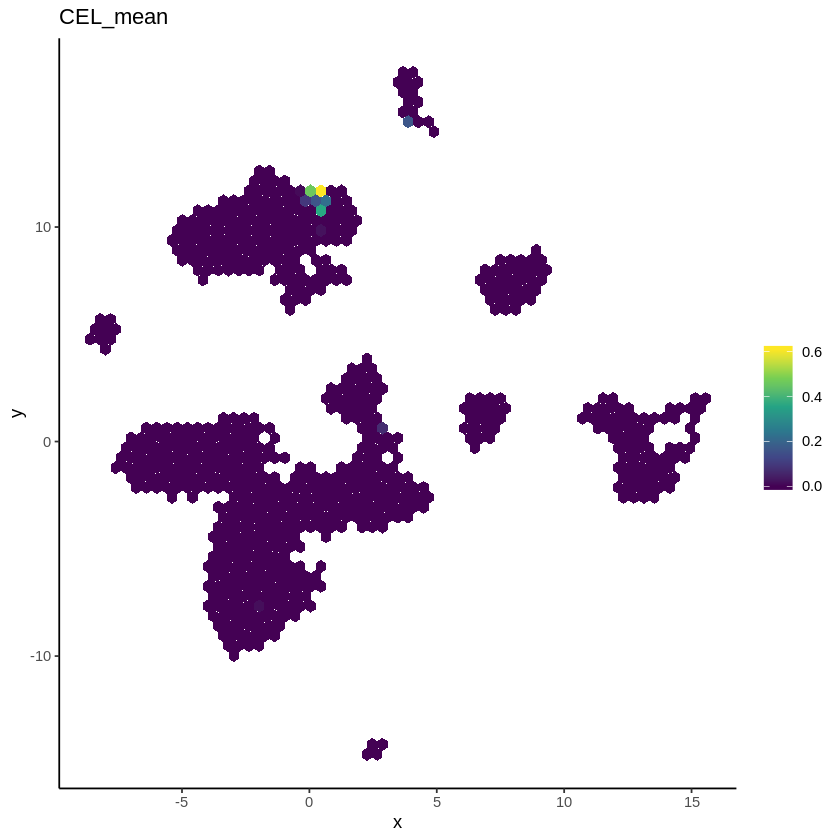

In [52]:
for (i in 1:length(epi_markers)){
    p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = epi_markers[i], action = "mean")
    plot(p1)
}

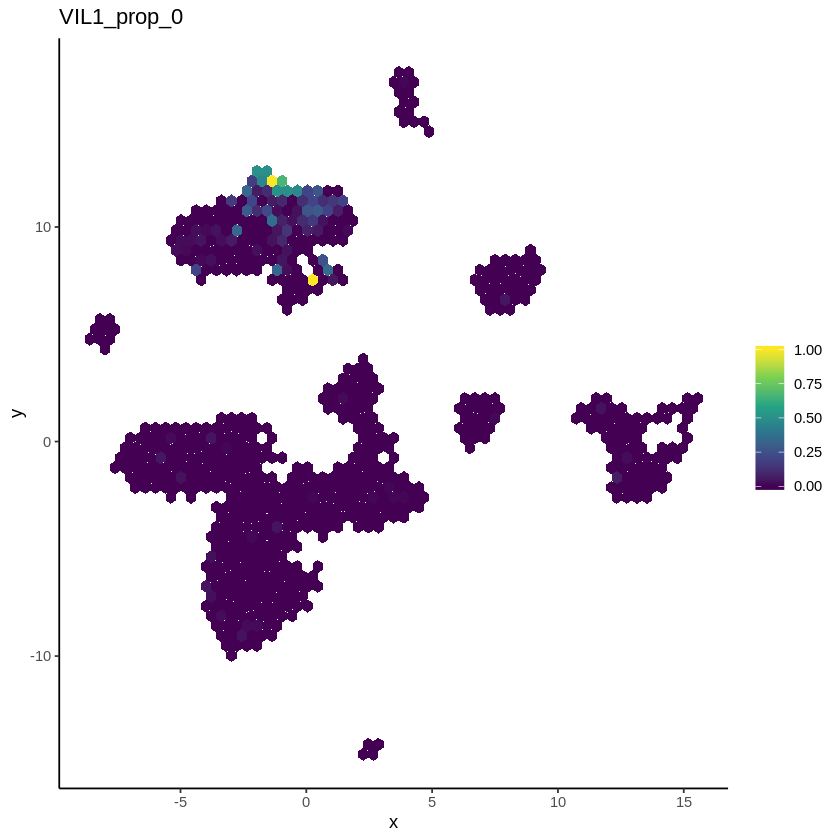

In [53]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'VIL1', action = "prop_0")
plot(p1)

In [54]:
neuroendocrine <- c("GAST","CCK","SCT","GIP","MLN","SST","HRH1")

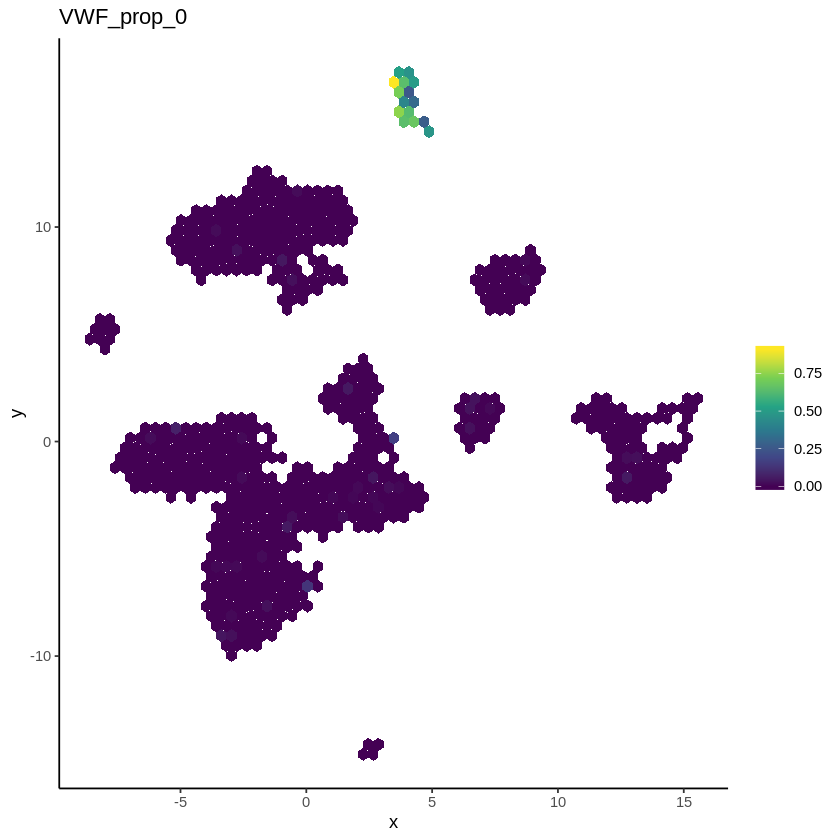

In [55]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'VWF', action = "prop_0")
plot(p1)

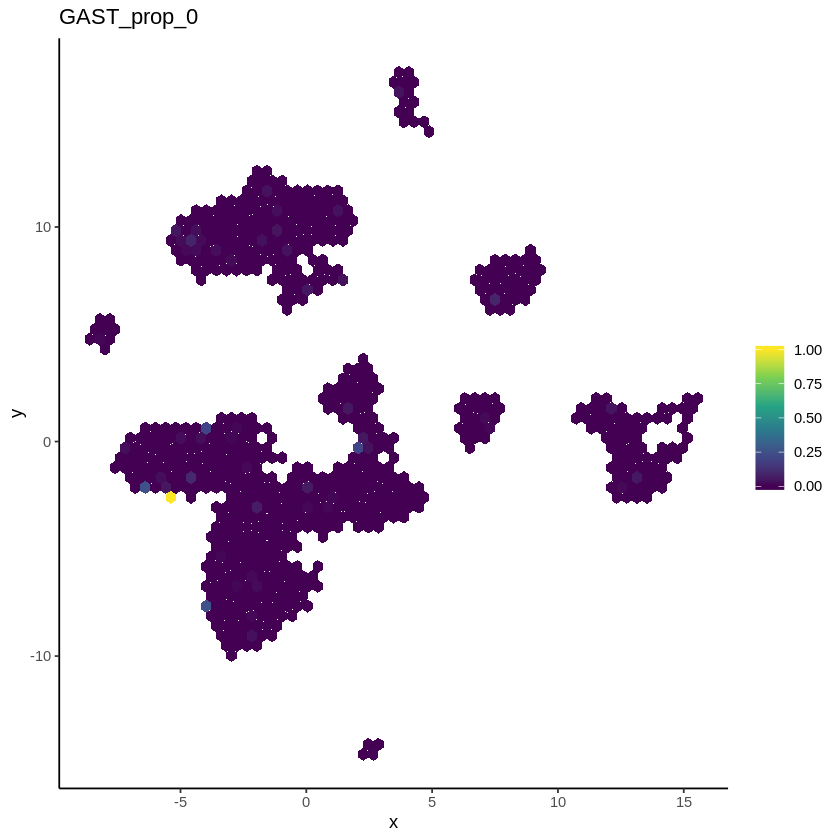

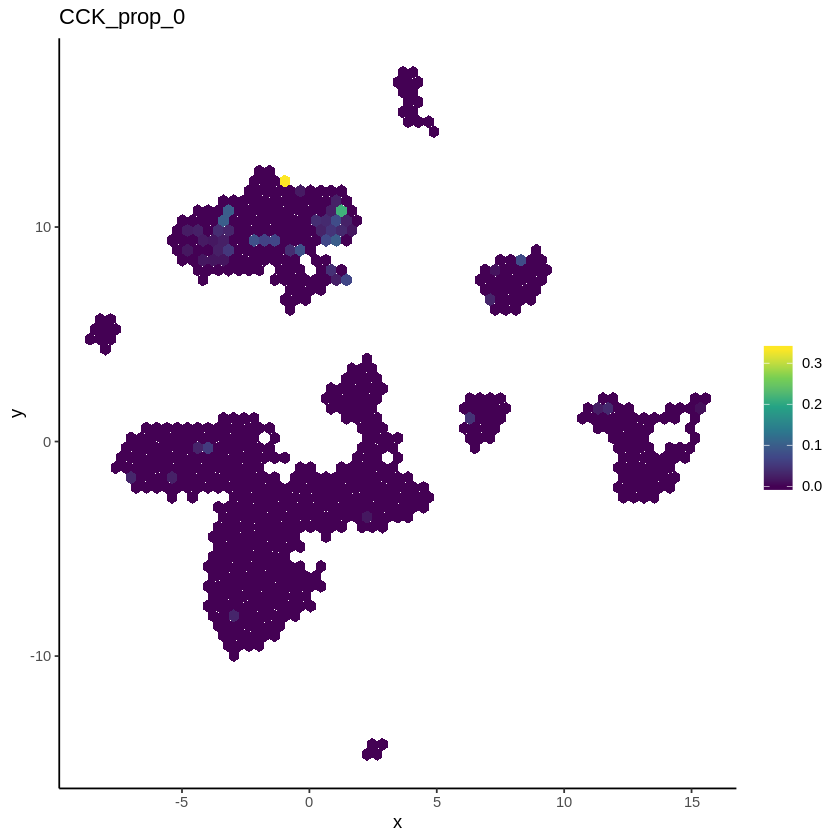

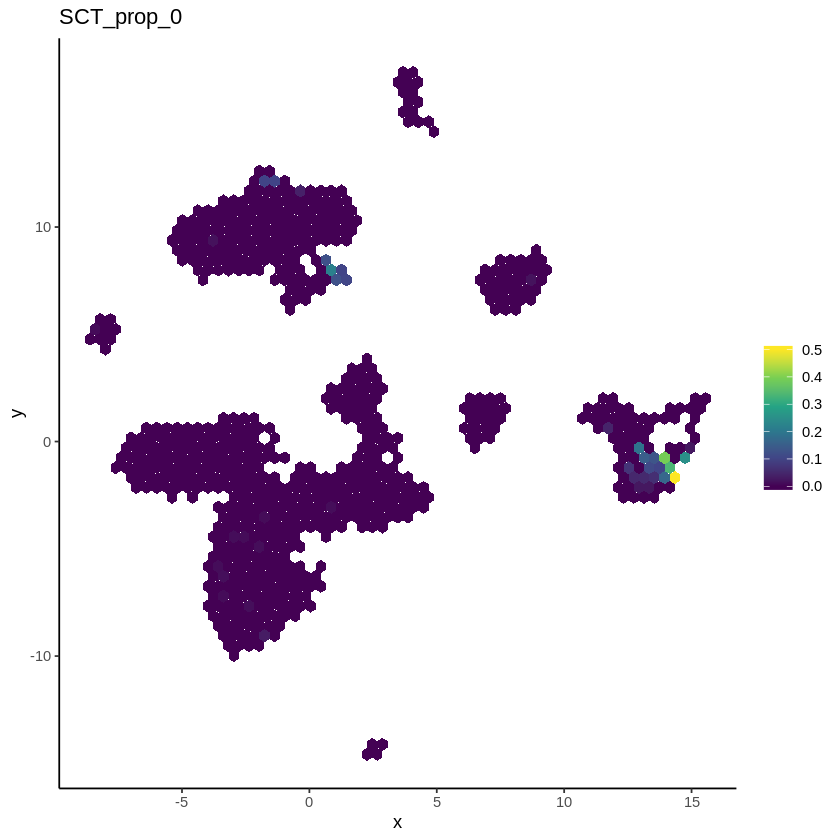

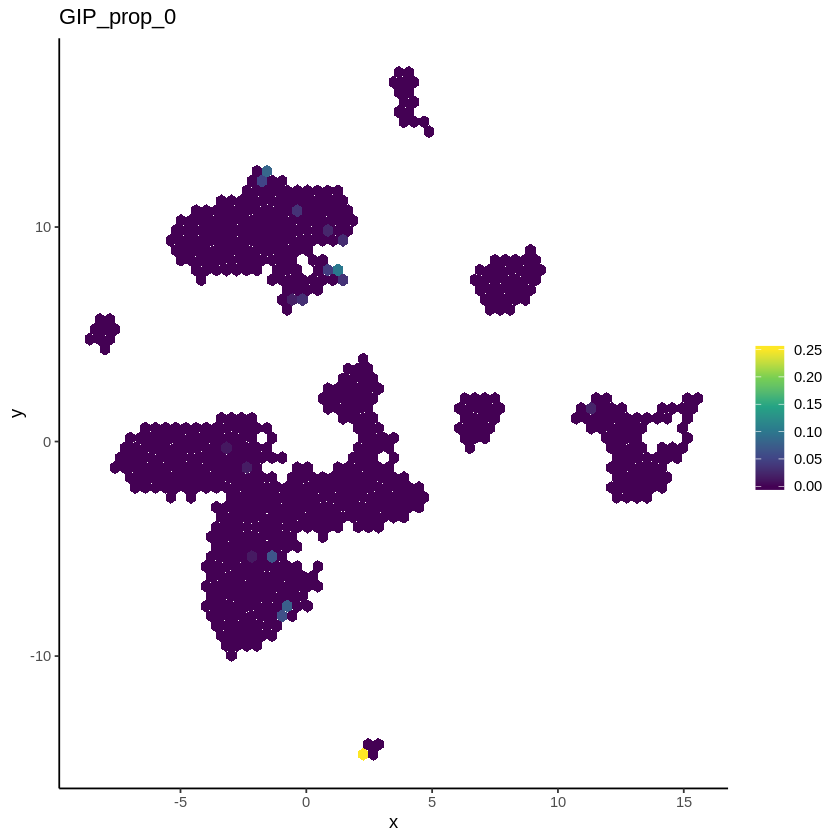

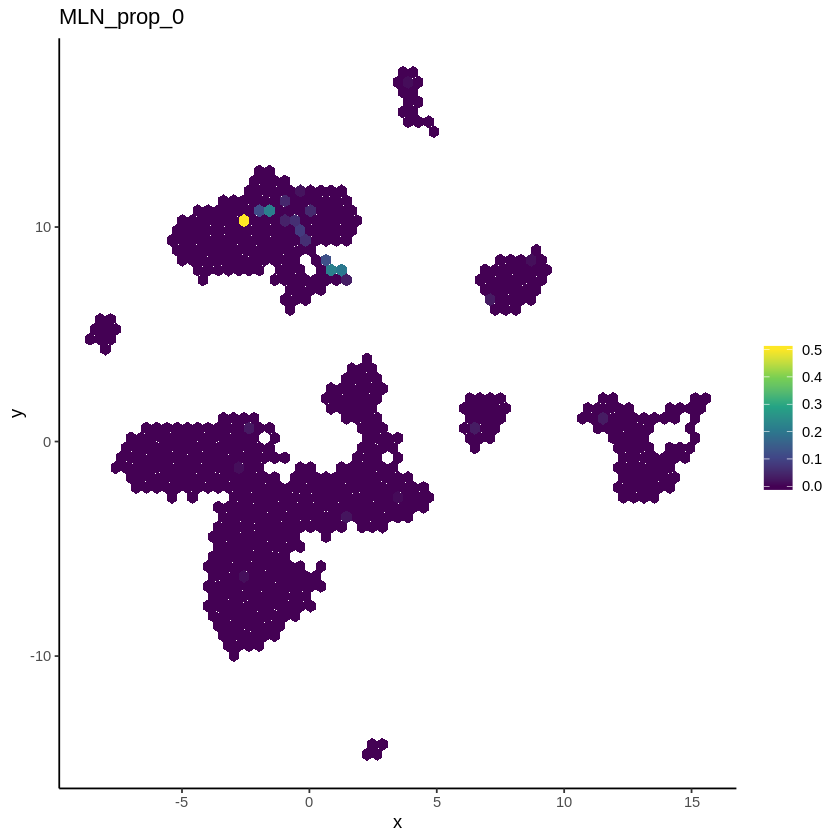

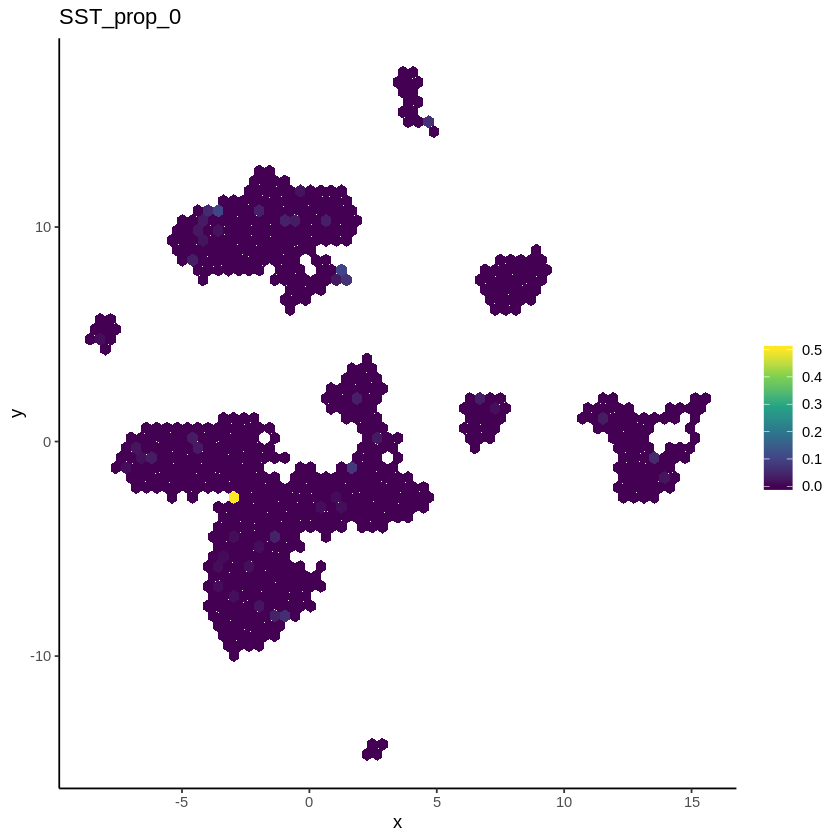

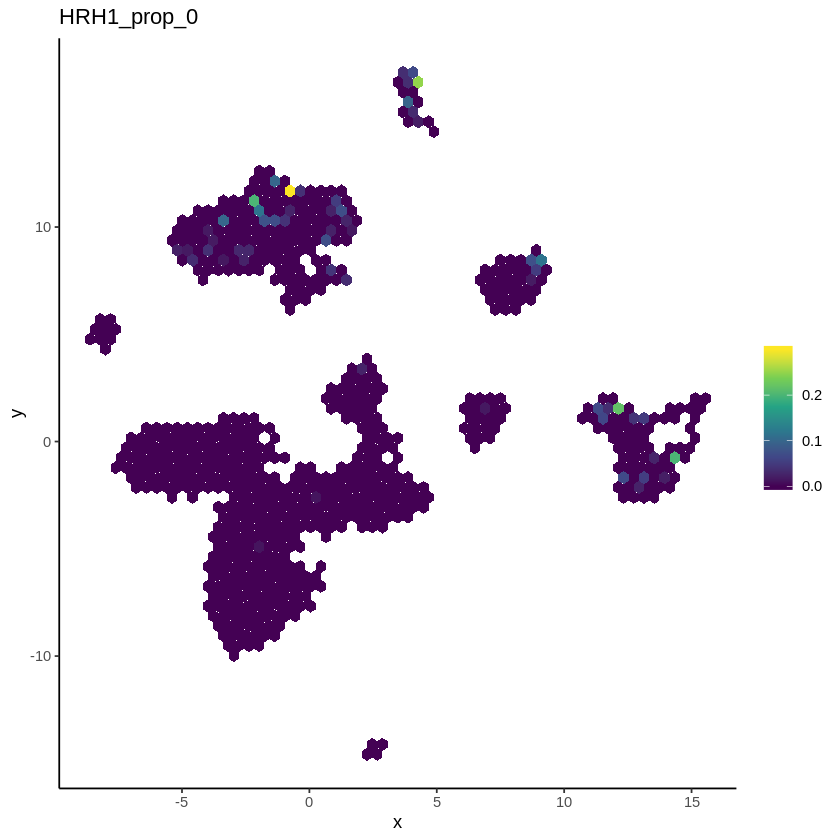

In [56]:
for (i in 1:length(neuroendocrine)){
    p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = neuroendocrine[i], action = "prop_0")
    plot(p1)
}

In [57]:
plasma.markers <- c('IGKC','IGHA1','JCHAIN','IGHA2','IGKV4-1')

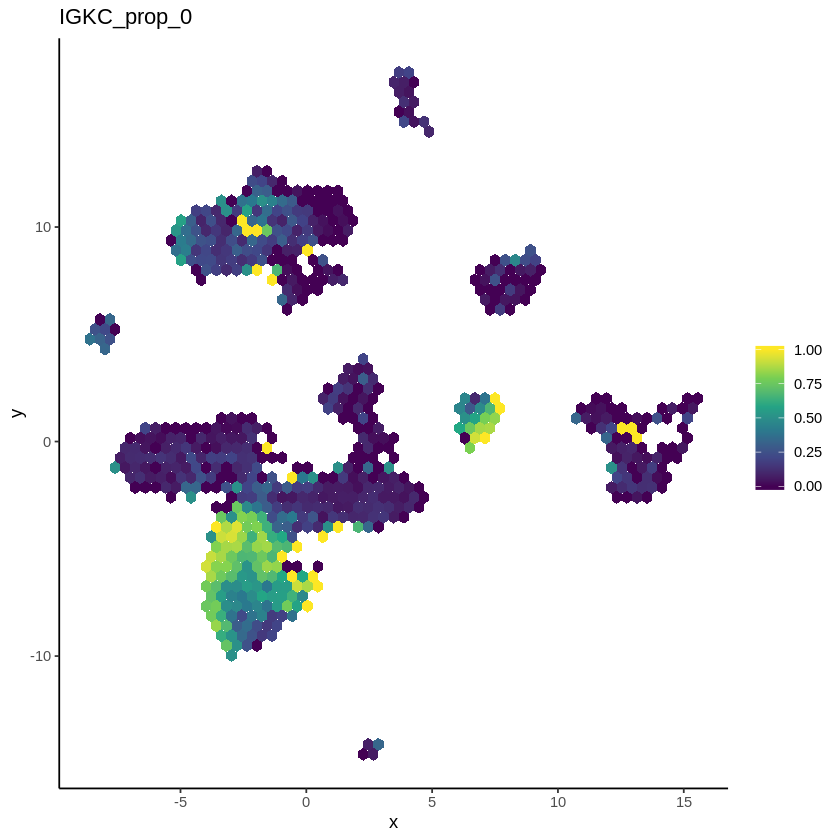

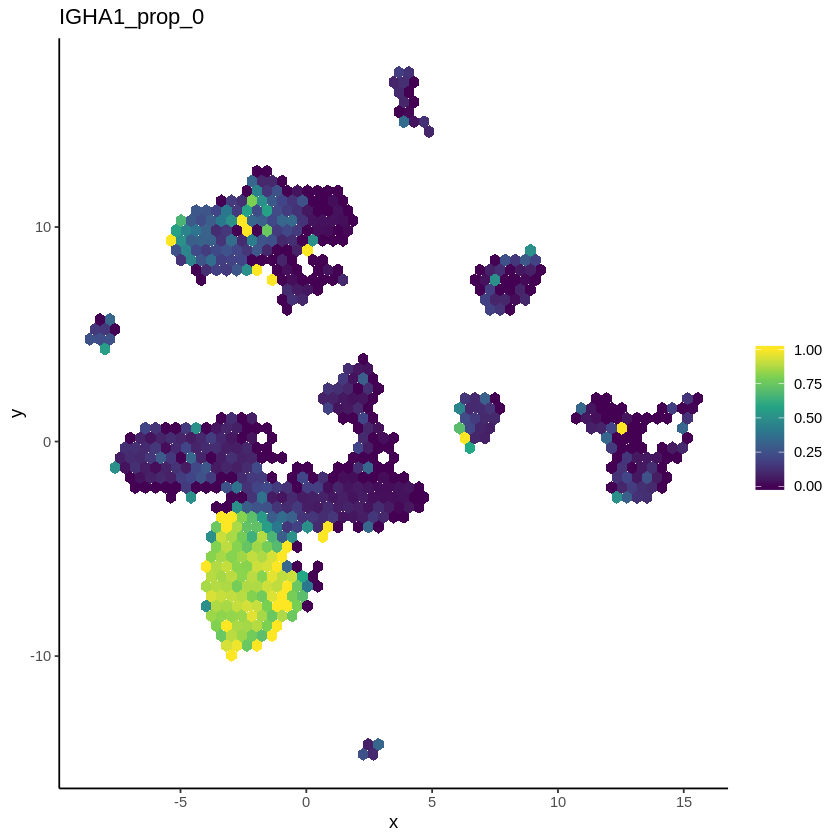

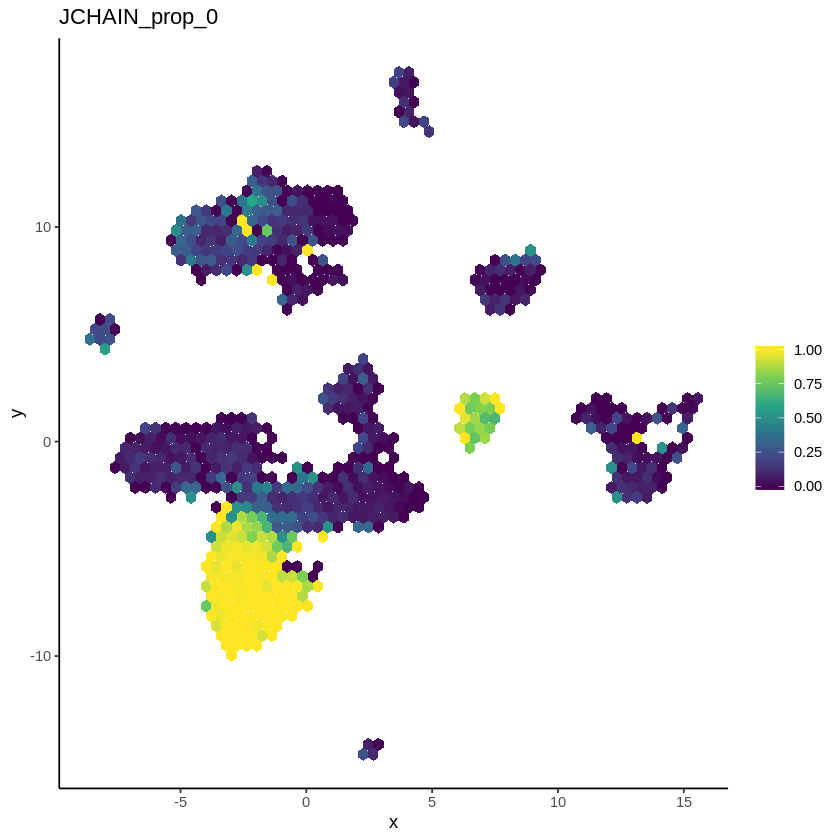

ERROR: Error in plot_hexbin_gene(data_schex, type = "logcounts", gene = plasma.markers[i], : Gene cannot be found.


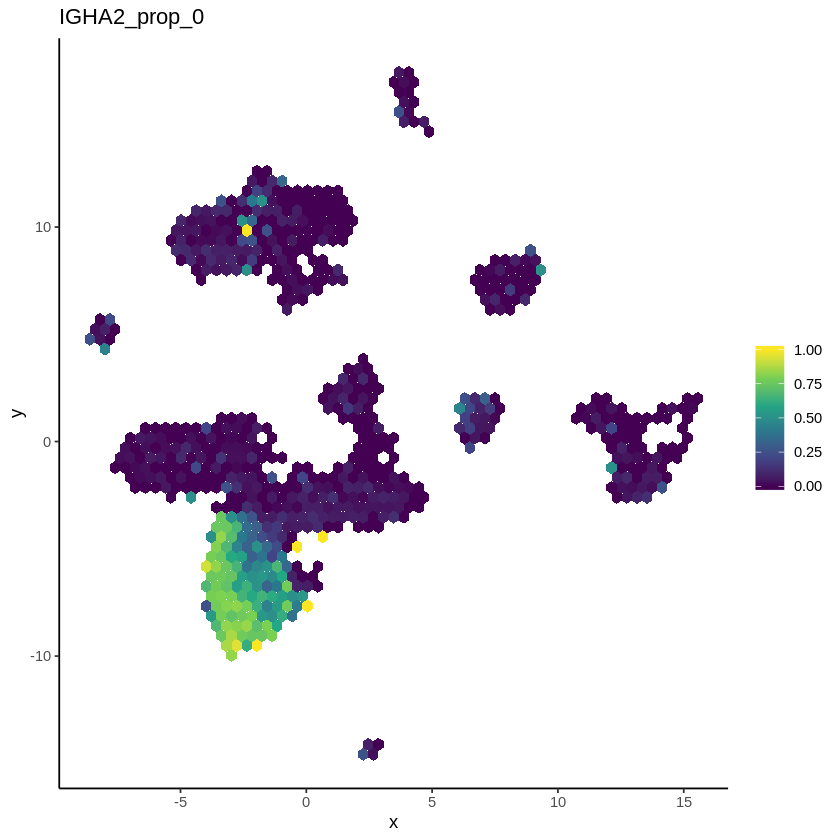

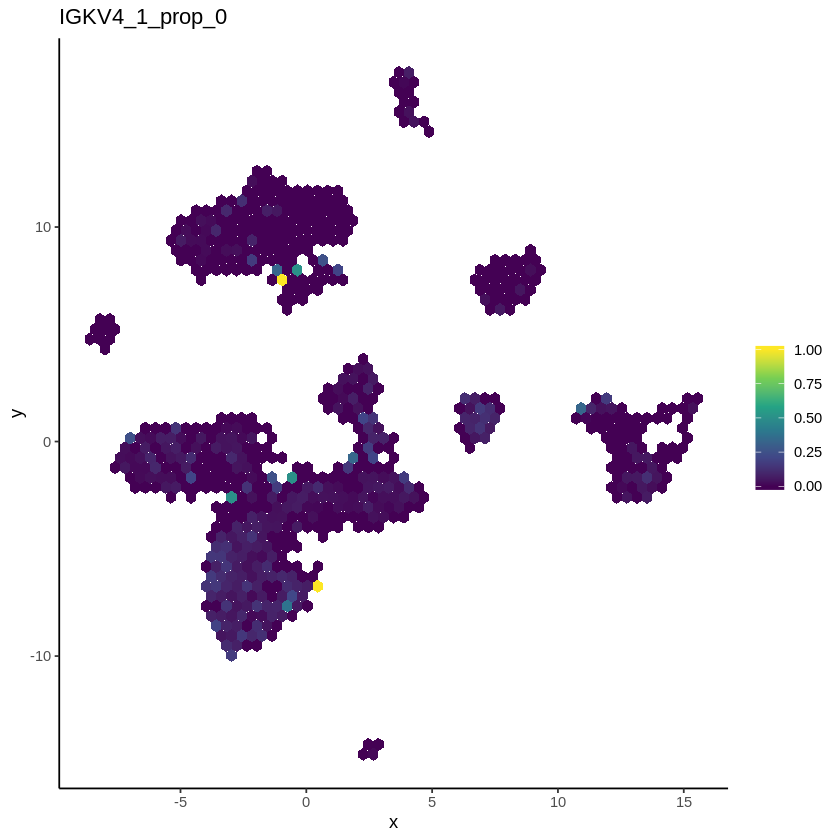

In [58]:
for (i in 1:length(neuroendocrine)){
    p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = plasma.markers[i], action = "prop_0")
    plot(p1)
}

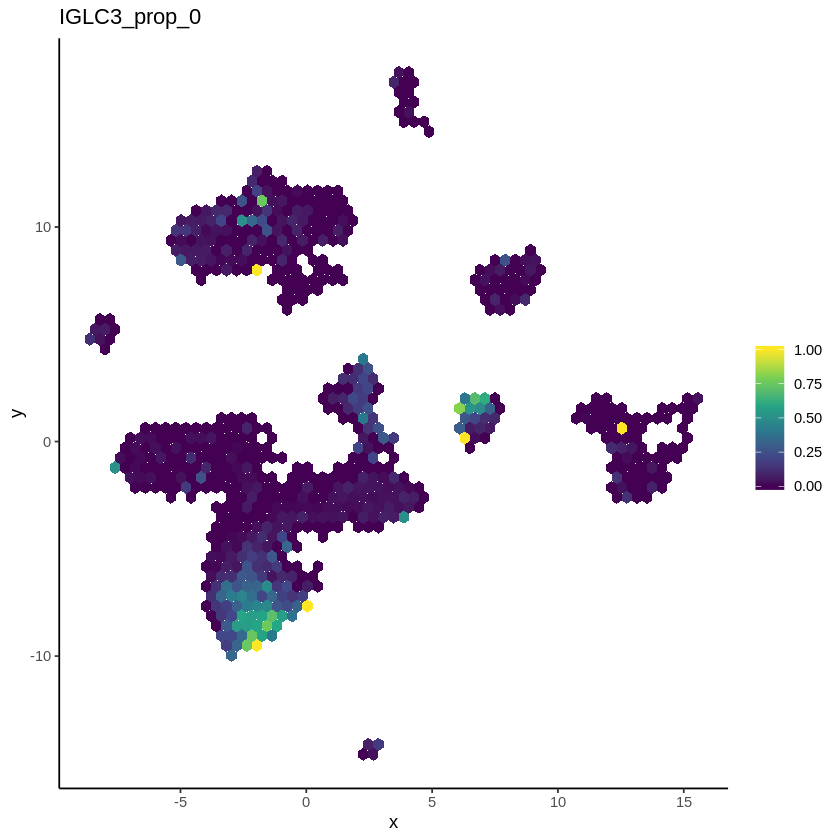

In [60]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'IGLC3', action = "prop_0")
plot(p1)

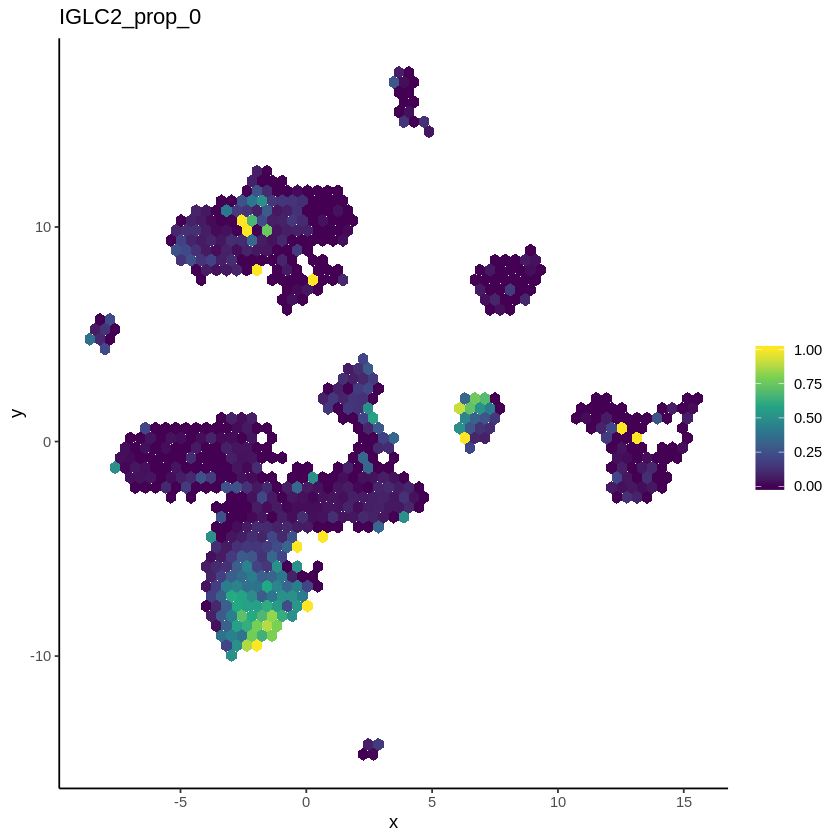

In [61]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'IGLC2', action = "prop_0")
plot(p1)

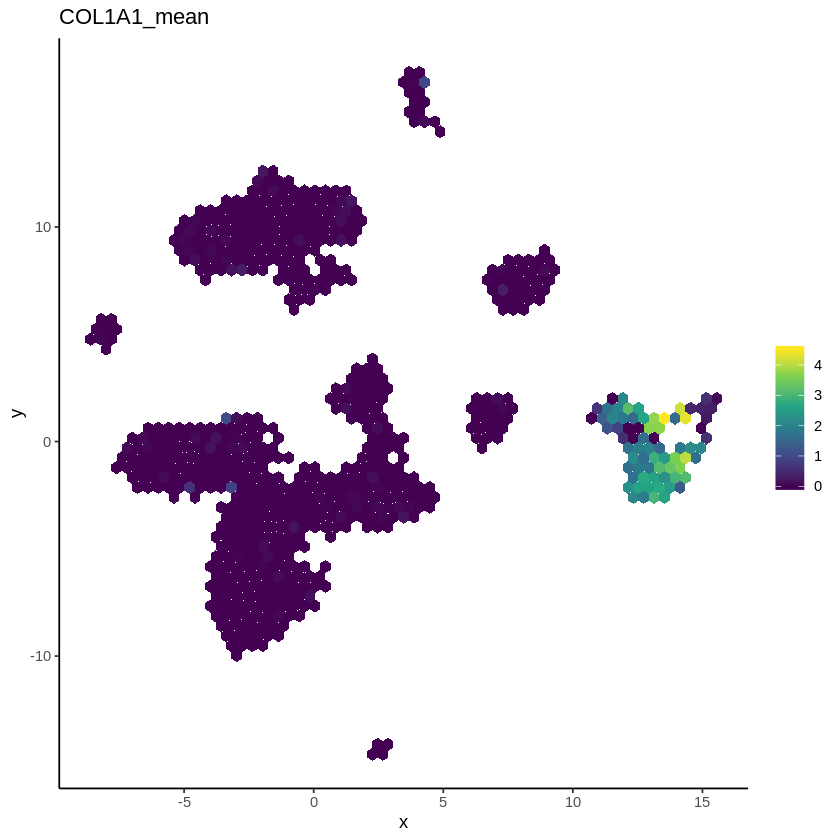

In [62]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'COL1A1', action = "mean")
plot(p1)

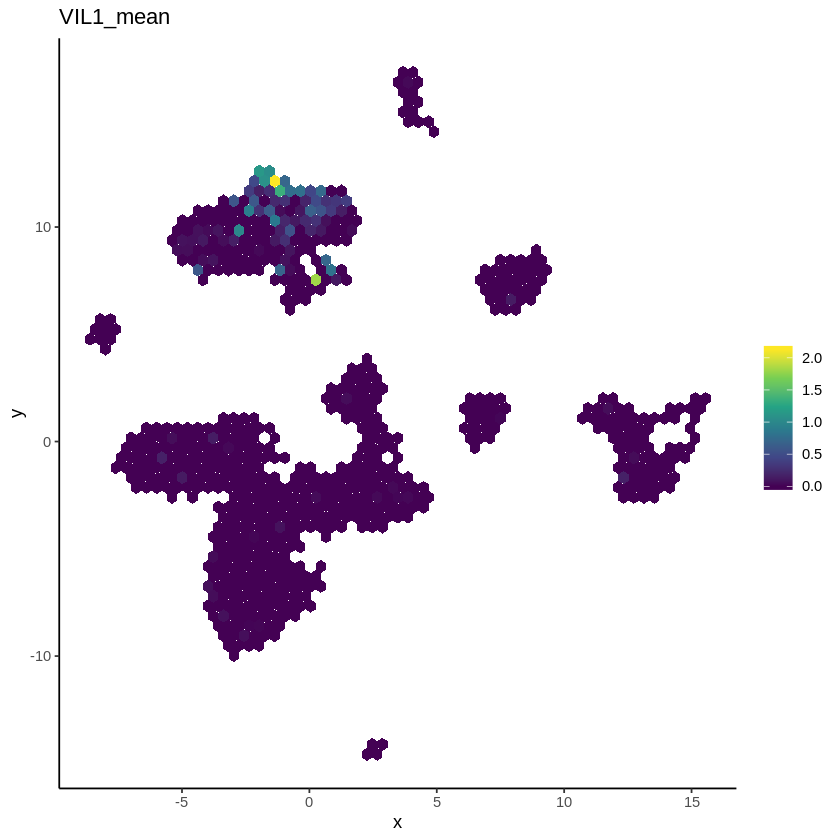

In [63]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'VIL1', action = "mean")
plot(p1)

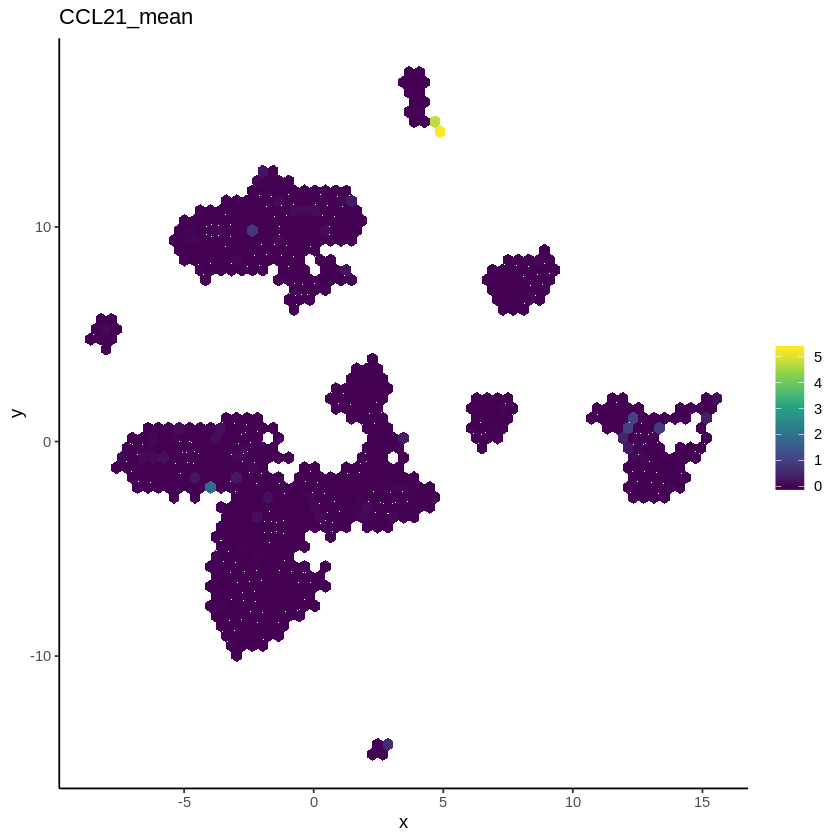

In [64]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'CCL21', action = "mean")
plot(p1)

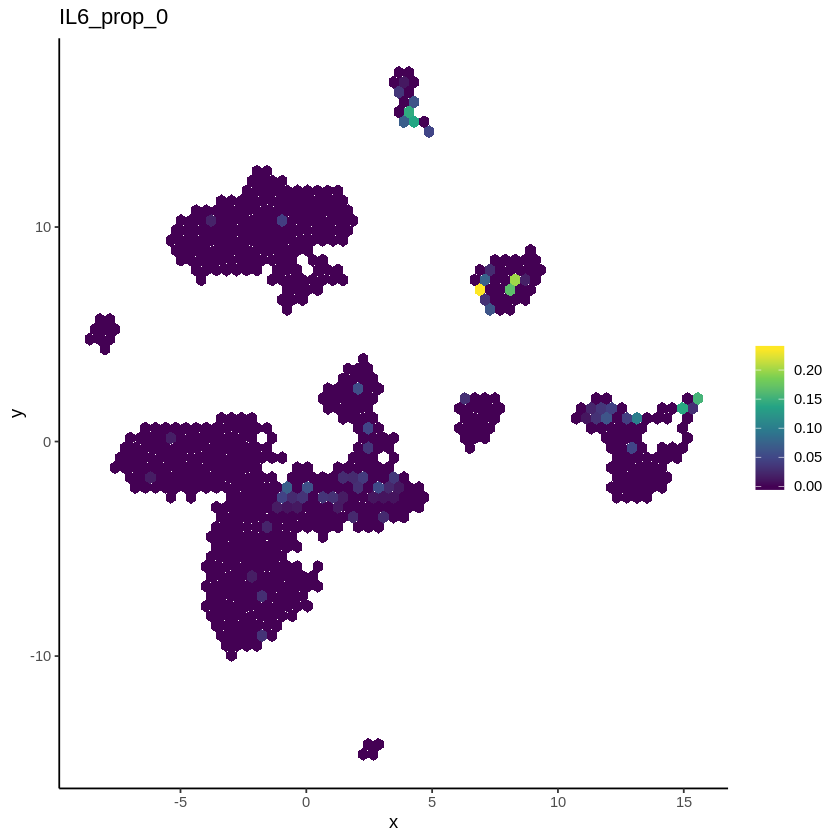

In [65]:
p1 <- plot_hexbin_gene(data_schex,type = "logcounts", gene = 'IL6', action = "prop_0")
plot(p1)

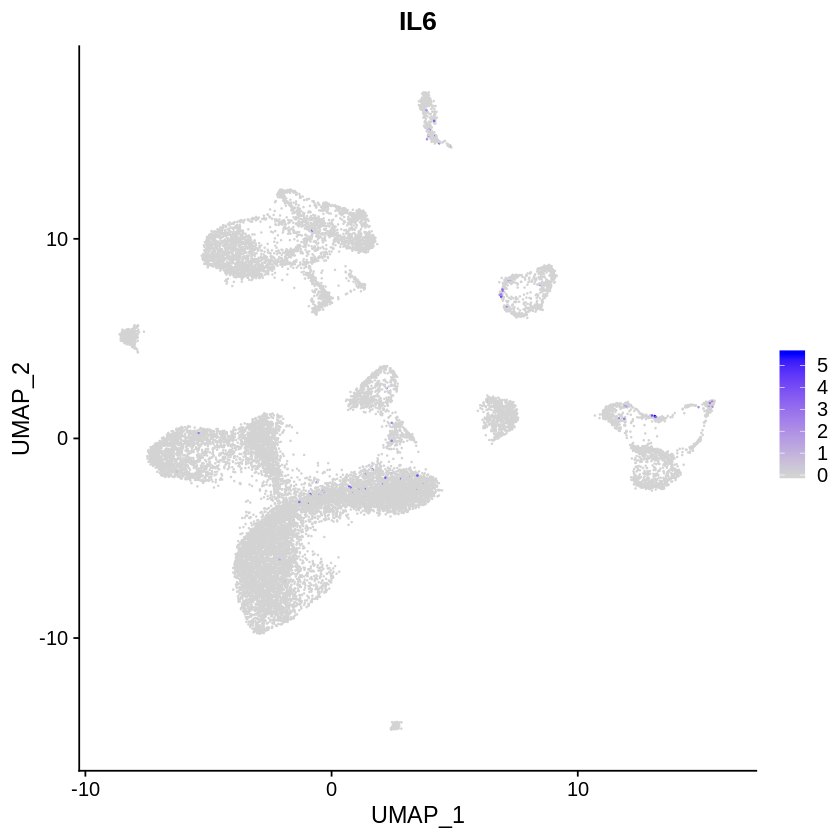

In [66]:
p1 <- FeaturePlot(data.integrated, features = 'IL6')
plot(p1)

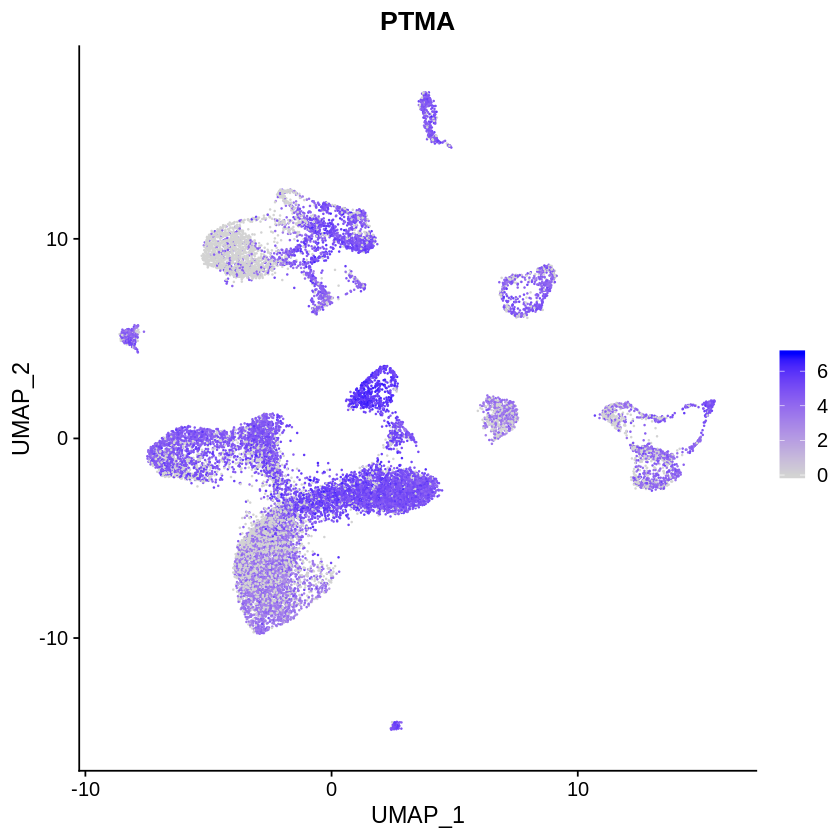

In [67]:
FeaturePlot(data.integrated, features = 'PTMA')

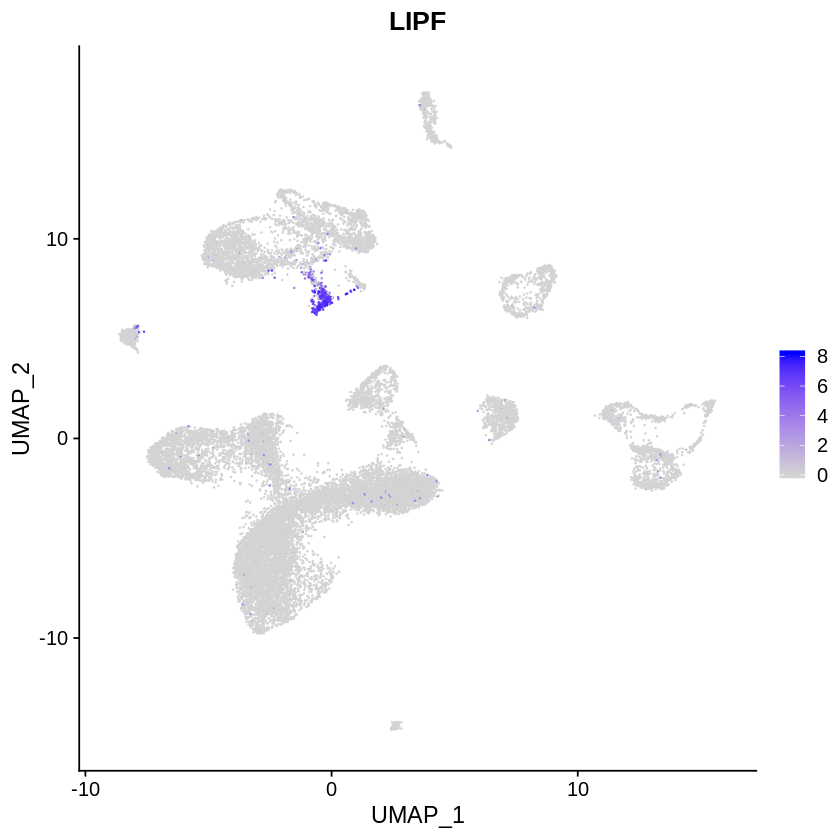

In [68]:
FeaturePlot(data.integrated, features = 'LIPF')

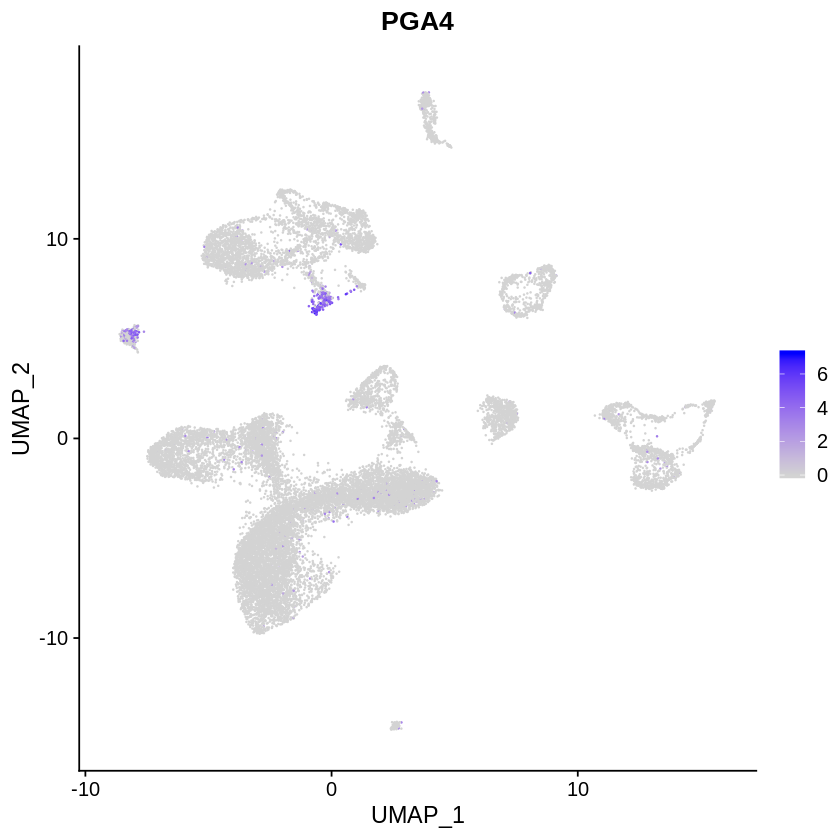

In [69]:
FeaturePlot(data.integrated, features = 'PGA4')

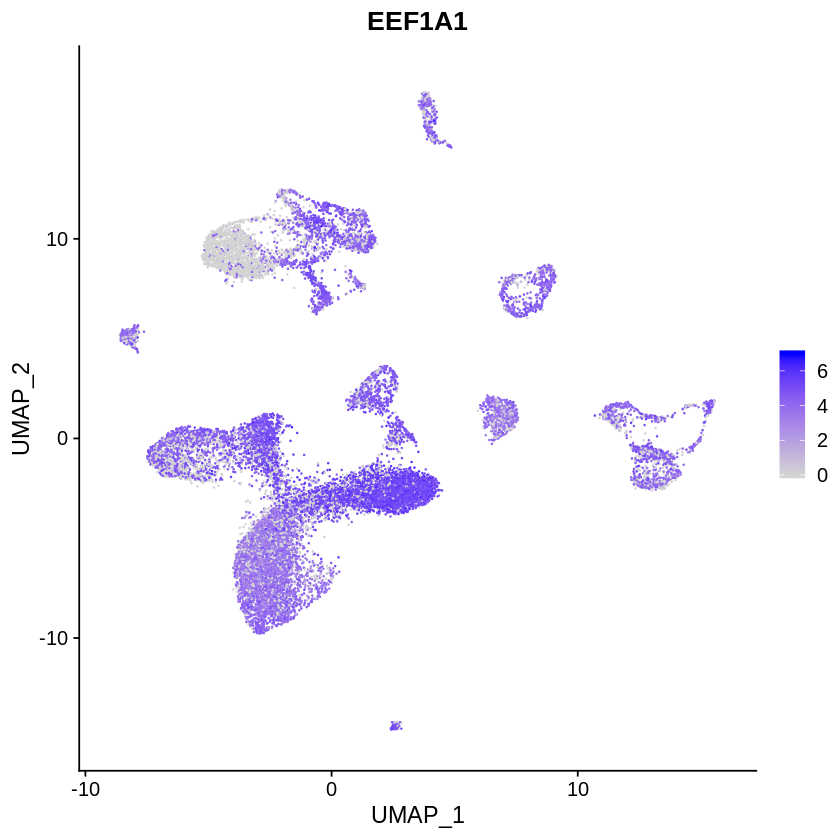

In [70]:
FeaturePlot(data.integrated, features = 'EEF1A1')

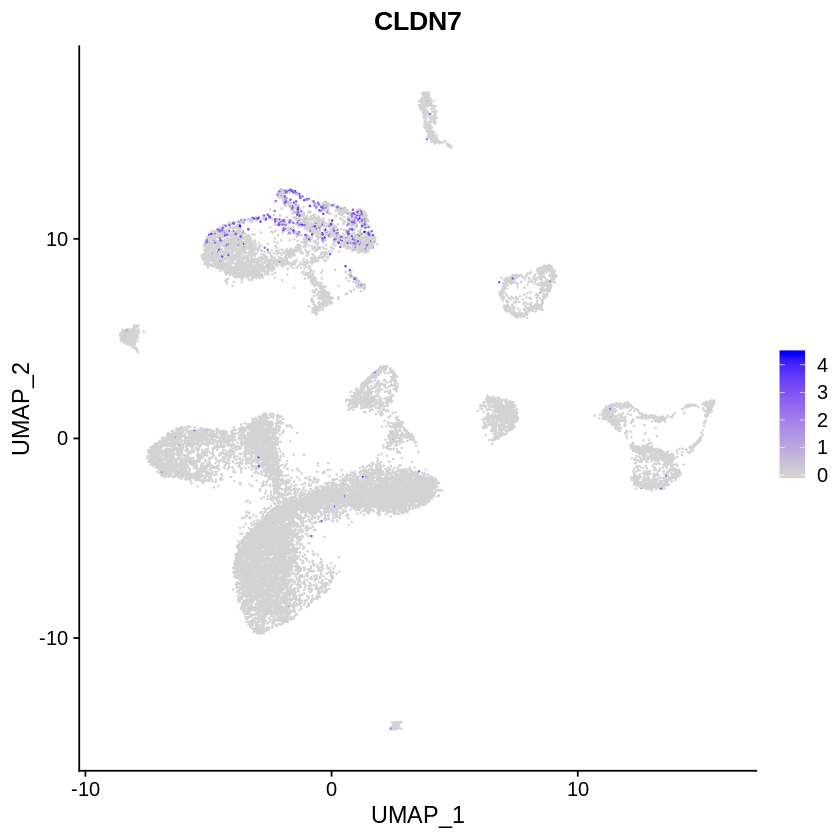

In [71]:
FeaturePlot(data.integrated, features = 'CLDN7')

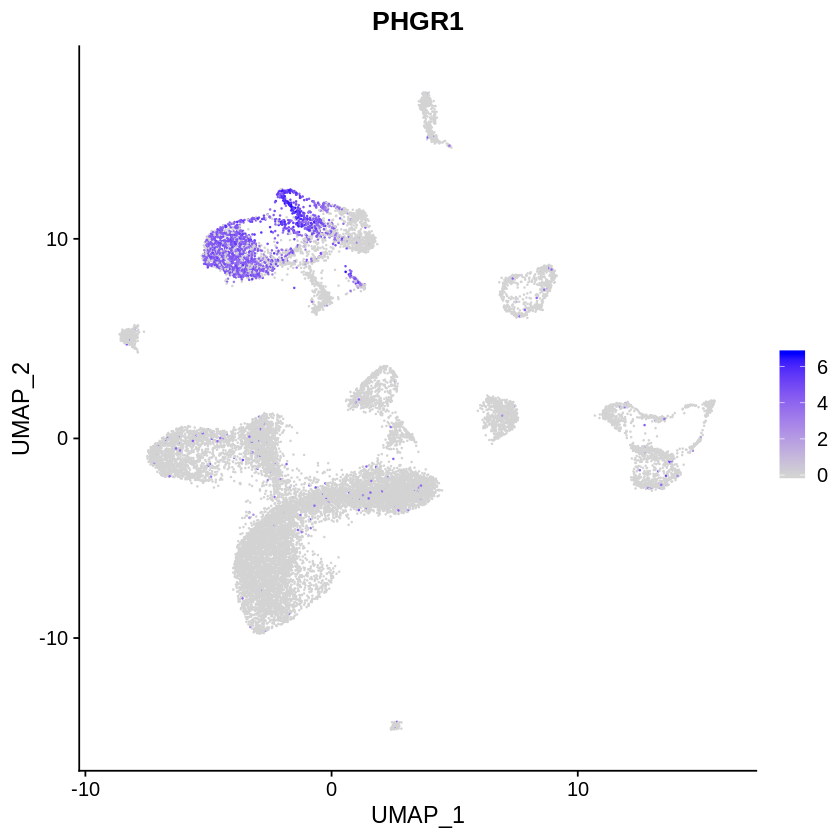

In [72]:
FeaturePlot(data.integrated, features = 'PHGR1')

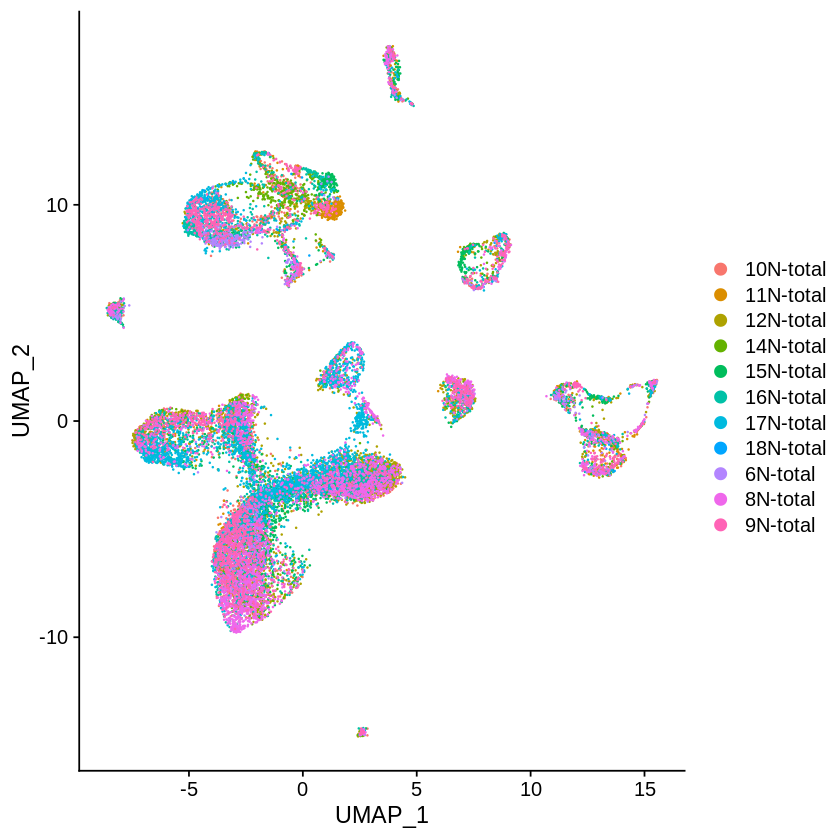

In [73]:
DimPlot(data.integrated, group.by='orig.ident')

In [74]:
cluster6_14 <- FindMarkers(data.integrated, ident.1 = 6, ident.2=14, only.pos=TRUE)

In [75]:
cluster6_14

p_val        avg_logFC pct.1 pct.2 p_val_adj   
S100A6   3.027895e-88 2.0628456 0.795 0.360 1.015496e-83
S100A10  9.098721e-50 2.4137439 0.536 0.147 3.051529e-45
TXN      7.084789e-44 2.1364808 0.569 0.259 2.376096e-39
S100A11  3.471485e-31 1.7069633 0.491 0.224 1.164267e-26
PHGR1    2.155334e-26 3.2775548 0.294 0.035 7.228559e-22
HSP90AA1 9.148688e-26 1.6277267 0.454 0.211 3.068287e-21
IFI27    3.379205e-25 1.7327044 0.410 0.155 1.133318e-20
CALM2    6.700850e-23 1.4420859 0.425 0.195 2.247331e-18
PSMA7    1.193784e-22 1.6741735 0.339 0.099 4.003713e-18
CLDN7    2.527460e-22 1.6024730 0.218 0.003 8.476597e-18
GSTP1    6.976607e-22 1.4544679 0.433 0.219 2.339815e-17
PRDX1    3.499538e-20 1.6876574 0.342 0.125 1.173675e-15
PSMB3    8.917043e-20 1.7769886 0.259 0.048 2.990598e-15
SOD1     1.135925e-19 1.6117954 0.339 0.123 3.809666e-15
LGALS4   2.173037e-19 1.7954677 0.306 0.093 7.287931e-15
TMSB10   8.379924e-19 0.6535434 0.693 0.579 2.810459e-14
GAPDH    1.164870e-18 1.1859705 0.491 0.323 3.906740e-14
NDUFB9   3.998286e-18 1.4059552 0.331 0.128 1.340945e-13
B2M      4.053804e-18 0.8322843 0.616 0.483 1.359565e-13
KRT18    6.480704e-18 1.2858162 0.466 0.299 2.173499e-13
ACTB     7.178099e-18 0.6833483 0.594 0.453 2.407391e-13
JPT1     1.506968e-17 1.5099150 0.313 0.115 5.054070e-13
KRT19    1.620557e-17 1.5418166 0.426 0.243 5.435024e-13
CLDN4    2.721582e-17 1.5867282 0.186 0.011 9.127641e-13
COX7A2   5.693638e-17 1.2309014 0.443 0.285 1.909532e-12
ATP5MF   7.060176e-17 1.5181527 0.346 0.163 2.367842e-12
ANXA2    1.263012e-16 1.3644995 0.372 0.187 4.235890e-12
CKS2     2.597027e-16 1.7773000 0.188 0.019 8.709909e-12
REG4     1.407496e-15 2.3790983 0.169 0.011 4.720461e-11
PRSS3    1.173107e-14 1.5407854 0.206 0.043 3.934366e-10
⋮        ⋮            ⋮         ⋮     ⋮     ⋮           
ATP5PO   0.8522587    0.4284556 0.214 0.237 1           
DNPH1    0.8522828    0.4827346 0.108 0.112 1           
FIS1     0.8538530    0.3283326 0.138 0.144 1           
RAB11A   0.8606103    0.4154733 0.153 0.171 1           
GTF3C6   0.8694392    0.3803049 0.119 0.123 1           
DDX21    0.8746628    0.4323700 0.184 0.211 1           
PDCD5    0.8789156    0.3252259 0.129 0.133 1           
SRSF3    0.8943031    0.3903286 0.199 0.227 1           
RAB2A    0.9047883    0.4364136 0.166 0.187 1           
PRDX3    0.9161570    0.4225704 0.178 0.195 1           
GHITM    0.9246953    0.3422711 0.111 0.120 1           
RAB13    0.9296311    0.3671624 0.105 0.109 1           
ESD      0.9361143    0.3201165 0.124 0.133 1           
EZR      0.9384675    0.3743282 0.168 0.181 1           
MIDN     0.9510994    0.2648652 0.103 0.107 1           
BLOC1S1  0.9519809    0.5436821 0.132 0.147 1           
SSR2     0.9584494    0.2951894 0.125 0.133 1           
DYNLRB1  0.9620324    0.4746202 0.121 0.128 1           
TATDN1   0.9671061    0.3146392 0.099 0.104 1           
FCGRT    0.9696815    0.2871382 0.106 0.112 1           
TMEM167A 0.9756479    0.4795172 0.119 0.131 1           
ATP6V0E1 0.9760676    0.3482743 0.141 0.152 1           
UQCR10   0.9770557    0.4277466 0.265 0.307 1           
FHL2     0.9834828    0.3641434 0.108 0.115 1           
TMEM14A  0.9856177    0.4809638 0.118 0.125 1           
BRK1     0.9858453    0.3601229 0.164 0.181 1           
HLA-DRA  0.9860035    0.4991257 0.147 0.163 1           
XRCC5    0.9934042    0.3763885 0.095 0.101 1           
EIF1     0.9942052    0.7916395 0.309 0.373 1           
HIGD2A   0.9963246    0.4716508 0.115 0.123 1

In [76]:
cluster6 <- FindMarkers(data.integrated, ident.1=6,ident.2 = 3, only.pos=TRUE)

In [77]:
cluster6

p_val         avg_logFC pct.1 pct.2 p_val_adj    
PTMA     2.007642e-250 1.843486  0.795 0.203 6.733228e-246
EEF1A1   1.672859e-227 1.942748  0.724 0.163 5.610433e-223
S100A10  3.325822e-216 2.916382  0.536 0.035 1.115414e-211
TXN      1.697264e-199 2.559058  0.569 0.076 5.692283e-195
FTL      2.108258e-185 2.282048  0.565 0.084 7.070675e-181
FTH1     5.931098e-182 2.033966  0.597 0.112 1.989172e-177
TMSB10   3.289596e-178 1.676333  0.693 0.213 1.103265e-173
TPT1     1.743286e-171 1.485758  0.728 0.259 5.846634e-167
GAPDH    3.175516e-156 2.073369  0.491 0.065 1.065005e-151
FAU      1.769984e-154 1.648381  0.576 0.121 5.936173e-150
HSP90AA1 9.331415e-151 2.320435  0.454 0.055 3.129570e-146
UQCRH    2.573894e-139 2.143336  0.411 0.039 8.632325e-135
EEF1B2   9.237005e-139 2.290999  0.398 0.033 3.097907e-134
PPIA     1.577802e-135 2.028578  0.486 0.100 5.291632e-131
H3F3A    2.273967e-124 1.549292  0.553 0.165 7.626432e-120
COX7A2   1.977160e-119 1.849752  0.443 0.085 6.630999e-115
COX4I1   5.327772e-119 1.819979  0.426 0.071 1.786828e-114
COX6C    5.247582e-118 1.972987  0.380 0.047 1.759934e-113
NACA     1.689882e-114 2.001820  0.370 0.044 5.667525e-110
NDUFA4   4.893359e-111 1.923120  0.372 0.050 1.641135e-106
HSP90AB1 9.209799e-111 2.069857  0.357 0.043 3.088782e-106
HINT1    1.152661e-109 1.966735  0.359 0.043 3.865795e-105
EIF3E    5.293432e-109 2.096365  0.330 0.029 1.775311e-104
CHCHD2   1.244699e-104 1.792484  0.373 0.059 4.174470e-100
SOD1     1.295161e-103 1.939252  0.339 0.041  4.343712e-99
ATP5MF   6.496233e-102 1.844233  0.346 0.047  2.178707e-97
PSMA7    8.227988e-102 1.759896  0.339 0.041  2.759503e-97
IFITM3    2.011313e-99 2.215114  0.261 0.008  6.745541e-95
UBA52     9.401877e-97 1.344894  0.478 0.130  3.153201e-92
NDUFB9    3.921906e-96 1.647128  0.331 0.044  1.315329e-91
⋮        ⋮             ⋮         ⋮     ⋮     ⋮            
ARL6IP1  1.202089e-05  0.3653948 0.250 0.186 0.4031565    
ISG15    1.252898e-05  0.2669048 0.142 0.089 0.4201971    
GSTK1    1.828755e-05  0.3841858 0.106 0.063 0.6133277    
VPS28    2.941257e-05  0.3146743 0.133 0.085 0.9864388    
RER1     3.040592e-05  0.2652373 0.112 0.067 1.0000000    
AGR2     3.499161e-05  0.3113331 0.508 0.482 1.0000000    
ETFB     3.887760e-05  0.2931490 0.160 0.107 1.0000000    
MCL1     4.483802e-05  0.4126123 0.115 0.072 1.0000000    
MT1E     5.133700e-05  0.4107682 0.216 0.161 1.0000000    
VAPA     8.831141e-05  0.4117287 0.133 0.089 1.0000000    
UBE2D3   1.371633e-04  0.3331253 0.132 0.089 1.0000000    
MDK      1.496098e-04  0.2718238 0.172 0.121 1.0000000    
SLPI     2.224960e-04  0.5892935 0.247 0.207 1.0000000    
ITGB1    2.531672e-04  0.2574442 0.121 0.079 1.0000000    
HNRNPR   3.542261e-04  0.2528261 0.120 0.080 1.0000000    
HEBP2    5.143308e-04  0.2536179 0.120 0.081 1.0000000    
SSU72    5.239944e-04  0.2720939 0.103 0.067 1.0000000    
AGPAT2   7.128804e-04  0.2653159 0.133 0.093 1.0000000    
SBDS     7.771984e-04  0.3022239 0.130 0.091 1.0000000    
SELENOS  8.523086e-04  0.3358184 0.111 0.076 1.0000000    
CD55     9.732792e-04  0.3290761 0.118 0.082 1.0000000    
IER3     9.748231e-04  0.3247502 0.237 0.189 1.0000000    
UFM1     1.966517e-03  0.3219038 0.113 0.079 1.0000000    
TAX1BP1  2.182957e-03  0.2715212 0.142 0.105 1.0000000    
BZW1     2.561683e-03  0.2898603 0.111 0.079 1.0000000    
OAT      3.310100e-03  0.3645253 0.108 0.079 1.0000000    
TMEM50A  4.608974e-03  0.2761832 0.125 0.093 1.0000000    
PPP1CB   1.388457e-02  0.3086436 0.119 0.093 1.0000000    
PIGR     8.865155e-02  0.2852898 0.173 0.205 1.0000000    
JUP      5.834014e-01  0.3350404 0.103 0.097 1.0000000

In [78]:
monocyte <- FindMarkers(data.integrated, ident.1=9,ident.2 = NULL, only.pos=TRUE)

In [79]:
monocyte

p_val        avg_logFC pct.1 pct.2 p_val_adj   
APOC1      0            3.990947  0.423 0.010 0           
TYROBP     0            3.443066  0.827 0.019 0           
C1QB       0            3.296745  0.505 0.007 0           
C1QA       0            3.257790  0.495 0.008 0           
S100A9     0            3.206682  0.276 0.005 0           
S100A8     0            3.174140  0.168 0.002 0           
APOE       0            3.150558  0.434 0.019 0           
SPP1       0            3.110751  0.159 0.003 0           
CXCL8      0            3.101503  0.220 0.006 0           
FCER1G     0            2.948484  0.678 0.009 0           
AIF1       0            2.837085  0.643 0.013 0           
FTL        0            2.603985  0.963 0.441 0           
MS4A6A     0            2.562729  0.546 0.005 0           
LST1       0            2.498638  0.550 0.015 0           
PSAP       0            2.489008  0.697 0.099 0           
NPC2       0            2.458737  0.671 0.120 0           
CST3       0            2.436887  0.667 0.109 0           
C1QC       0            2.435313  0.369 0.004 0           
CTSB       0            2.332916  0.545 0.041 0           
CCL18      0            2.258475  0.157 0.001 0           
AC020656.1 0            2.223855  0.338 0.029 0           
LYZ        0            2.210254  0.660 0.098 0           
LGMN       0            2.208499  0.393 0.030 0           
MS4A7      0            2.122987  0.457 0.010 0           
CTSD       0            2.110998  0.538 0.074 0           
SAT1       0            2.109302  0.760 0.145 0           
CTSS       0            2.023019  0.609 0.075 0           
FTH1       0            1.989337  0.921 0.313 0           
CTSC       0            1.959773  0.484 0.058 0           
FGL2       0            1.921834  0.441 0.024 0           
⋮          ⋮            ⋮         ⋮     ⋮     ⋮           
NENF       1.303687e-09 0.3753560 0.141 0.076 4.372305e-05
PAPSS1     1.591598e-09 0.2577036 0.103 0.049 5.337902e-05
CNIH4      1.647766e-09 0.2578126 0.104 0.049 5.526276e-05
CALM3      1.771665e-09 0.2962423 0.127 0.065 5.941808e-05
CANX       1.777773e-09 0.3351490 0.197 0.118 5.962295e-05
PPA1       2.554378e-09 0.4623042 0.131 0.069 8.566874e-05
MGST3      2.923760e-09 0.3562522 0.130 0.068 9.805705e-05
FOSB       4.282471e-09 0.4520735 0.173 0.103 1.436255e-04
ADIPOR1    8.539628e-09 0.3002099 0.107 0.054 2.864021e-04
ISG15      1.000330e-08 0.3884320 0.106 0.052 3.354905e-04
TMBIM4     1.038406e-08 0.3343775 0.221 0.142 3.482605e-04
MCTS1      1.650586e-08 0.2844944 0.106 0.053 5.535735e-04
PSMA2      3.693430e-08 0.2622734 0.154 0.089 1.238702e-03
ANAPC11    3.797254e-08 0.3195055 0.122 0.065 1.273523e-03
GOLIM4     5.632407e-08 0.2675291 0.117 0.062 1.888997e-03
NDUFV2     7.692511e-08 0.2816875 0.104 0.054 2.579914e-03
RAB1A      2.204054e-07 0.2526251 0.141 0.082 7.391958e-03
CSF2RB     2.703735e-07 0.4171775 0.107 0.059 9.067787e-03
AHNAK      4.126539e-07 0.3096059 0.178 0.113 1.383959e-02
OSTC       1.100367e-06 0.3812116 0.196 0.132 3.690411e-02
COX5A      1.608750e-06 0.2518949 0.151 0.093 5.395425e-02
LMNA       1.666657e-06 0.4437901 0.138 0.084 5.589635e-02
SSBP1      3.316499e-06 0.2895062 0.114 0.066 1.112287e-01
RPN2       8.571156e-06 0.2917273 0.130 0.081 2.874594e-01
PRELID1    1.927158e-05 0.2950486 0.133 0.086 6.463302e-01
SEC14L1    2.683396e-05 0.3034848 0.115 0.072 8.999572e-01
CFLAR      9.317136e-05 0.2614645 0.154 0.105 1.000000e+00
CISD2      5.168596e-04 0.3111328 0.122 0.084 1.000000e+00
MAN1A1     9.520266e-04 0.2985818 0.111 0.076 1.000000e+00
HSPA1B     1.012276e-03 0.2986603 0.143 0.103 1.000000e+00

In [80]:
cluster18 <- FindMarkers(data.integrated, ident.1=18,ident.2 = 2, only.pos=TRUE)

In [81]:
cluster18

p_val         avg_logFC pct.1 pct.2 p_val_adj    
TPSB2       0.000000e+00 5.749421  0.954 0.000  0.000000e+00
TPSAB1      0.000000e+00 5.102495  0.947 0.001  0.000000e+00
CPA3        0.000000e+00 4.522369  0.914 0.000  0.000000e+00
MS4A2       0.000000e+00 3.722723  0.750 0.002  0.000000e+00
KIT         0.000000e+00 3.507011  0.704 0.000  0.000000e+00
SLC18A2     0.000000e+00 3.125092  0.618 0.000  0.000000e+00
RGS13      2.896002e-253 3.070623  0.605 0.008 9.712610e-249
HPGDS      4.085242e-246 2.819509  0.507 0.001 1.370109e-241
ANXA1      6.384843e-241 3.018968  0.526 0.003 2.141349e-236
ALOX5AP    3.350683e-219 2.804030  0.520 0.006 1.123752e-214
GATA2      8.823815e-203 2.443747  0.428 0.001 2.959331e-198
AL157895.1 7.662640e-163 2.201661  0.336 0.000 2.569896e-158
LTC4S      9.322094e-158 2.642836  0.474 0.015 3.126444e-153
CLU        1.816750e-156 2.196992  0.336 0.001 6.093015e-152
VWA5A      3.131448e-155 2.460483  0.382 0.005 1.050225e-150
IL1RL1     8.799025e-154 2.348628  0.342 0.002 2.951017e-149
FCER1G     8.415594e-137 2.291055  0.296 0.001 2.822422e-132
FTH1       7.113464e-136 3.609290  0.888 0.171 2.385714e-131
ZEB2       7.860545e-124 2.148493  0.322 0.006 2.636270e-119
CADPS      5.567110e-118 2.157884  0.270 0.002 1.867097e-113
FOXP1      7.293214e-118 2.365858  0.441 0.024 2.445998e-113
BHLHE40    1.751622e-111 2.020836  0.283 0.005 5.874589e-107
CD9        2.368172e-110 2.595401  0.421 0.024 7.942374e-106
AREG       2.751722e-108 2.795073  0.368 0.016 9.228724e-104
HPGD       1.930722e-106 2.525488  0.276 0.005 6.475255e-102
MAOB       2.125679e-101 1.734451  0.230 0.002  7.129102e-97
S100A4     2.234141e-100 2.838365  0.441 0.033  7.492862e-96
GCSAML      9.849326e-98 1.671437  0.197 0.000  3.303267e-93
LAPTM5      1.176440e-97 2.014993  0.276 0.007  3.945545e-93
CAPG        5.484793e-94 2.017512  0.289 0.010  1.839490e-89
⋮          ⋮             ⋮         ⋮     ⋮     ⋮            
HIPK2      0.8318906     0.6718708 0.099 0.103 1            
SNRPD2     0.8342867     1.0122507 0.112 0.119 1            
AC114760.2 0.8376164     0.6549244 0.164 0.199 1            
PTGES3     0.8402571     0.7052145 0.118 0.140 1            
DYNLL1     0.8450744     0.8500968 0.112 0.132 1            
EIF3K      0.8456300     0.9557343 0.132 0.144 1            
PCBP2      0.8474148     0.9171927 0.178 0.221 1            
EPC1       0.8588943     0.8114544 0.112 0.119 1            
HLA-A      0.8651865     0.6825712 0.125 0.147 1            
AZIN1      0.8700323     0.8043528 0.092 0.106 1            
WDR74      0.8768312     0.7807125 0.118 0.128 1            
EMP3       0.8812064     1.0035900 0.224 0.270 1            
STK4       0.8825517     0.6478716 0.125 0.144 1            
MDM4       0.9045324     0.7244215 0.132 0.153 1            
GPX4       0.9090350     0.7357552 0.125 0.138 1            
YWHAE      0.9095630     0.9093858 0.125 0.138 1            
CIRBP      0.9121927     0.5535002 0.382 0.562 1            
LSM5       0.9123474     0.8664157 0.099 0.106 1            
SRSF9      0.9125696     0.5761812 0.092 0.104 1            
STK17B     0.9125824     0.6800742 0.197 0.240 1            
KTN1       0.9211569     0.9058341 0.112 0.123 1            
RHEB       0.9217166     0.6873804 0.099 0.106 1            
RSL24D1    0.9254847     0.9469074 0.158 0.181 1            
PSAP       0.9316939     0.6571574 0.112 0.128 1            
POMP       0.9367805     0.9266781 0.105 0.120 1            
RWDD1      0.9444172     0.5674113 0.099 0.110 1            
SNX3       0.9459652     0.8799058 0.105 0.115 1            
CANX       0.9509330     0.9120304 0.171 0.207 1            
RBM25      0.9756657     0.4516208 0.099 0.106 1            
CSF2RB     0.9836413     0.9632611 0.158 0.184 1

In [82]:
fibroblasts <- subset(data.integrated, idents = c(8,13,15))

endothelials <- subset(data.integrated, idents = 11)

macrophages <- subset(data.integrated, idents = 9)

epithelials <- subset(data.integrated, idents=c(3,6,12,14,17,19))

immunes <- subset(data.integrated, idents = c(0,1,2,4,5,7,10,16,18))

# ここから各細胞腫ごとに見ていく 

## fibroblasts

In [83]:
fibroblasts <- UMAP(fibroblasts)

In [84]:
caf.markers <- c('FGF5', 'CXCL5', 'IGFL2', 'MMP1', 'ADAM32', 'ADAM18', 'IGFL1', 'FGF8', 'FGF17', 'FGF19', 'FGF4', 'FGF23')

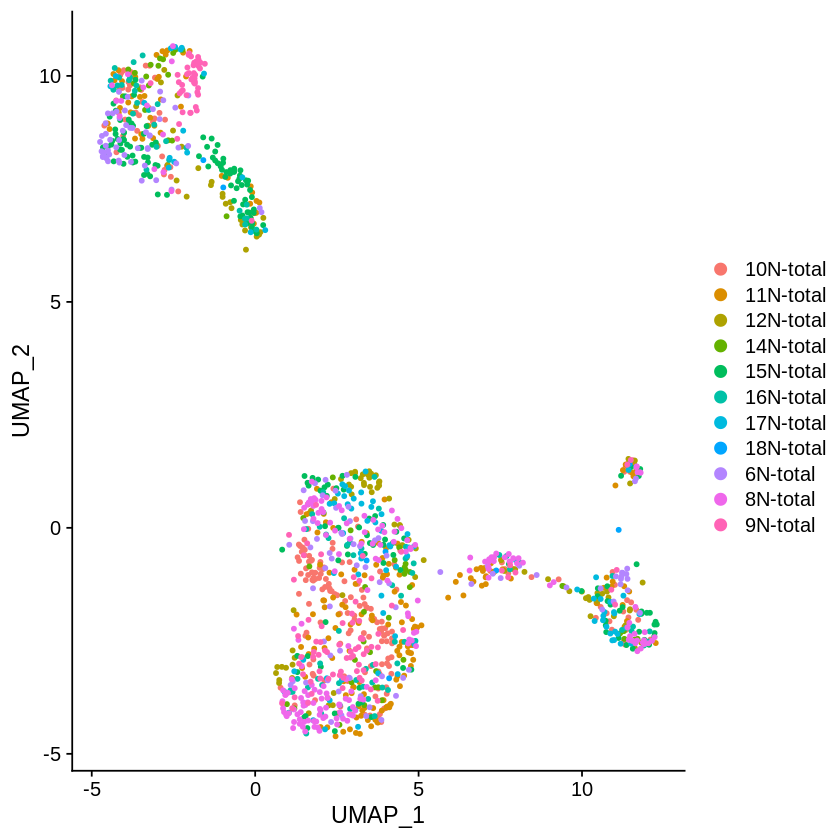

In [85]:
DimPlot(fibroblasts, group.by='orig.ident')

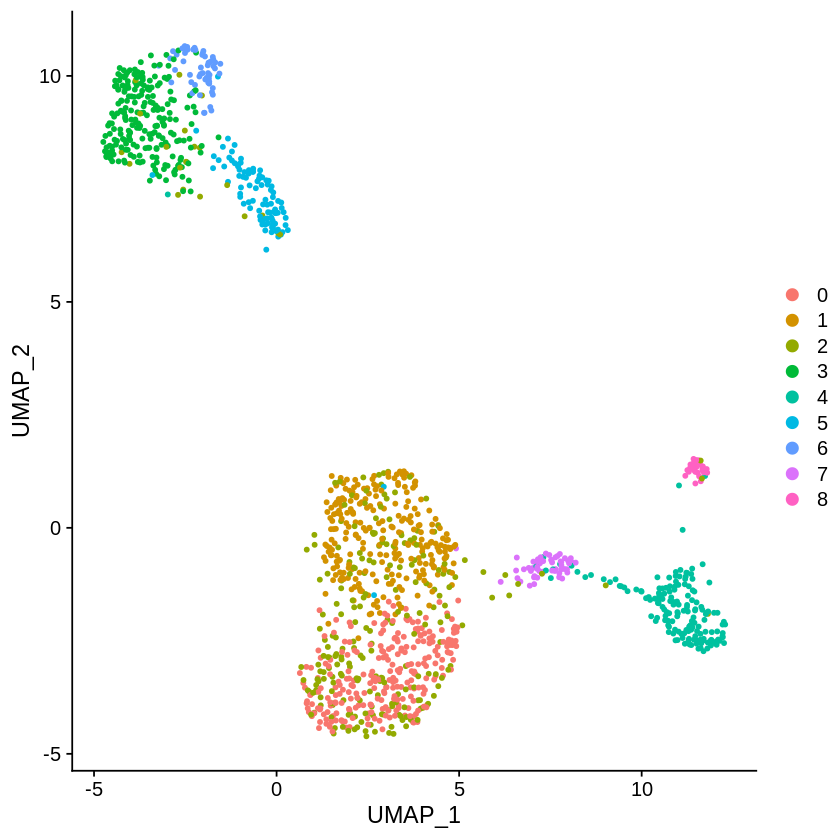

In [86]:
DimPlot(fibroblasts)

In [87]:
schex.fibroblasts <- make_hexbin(as.SingleCellExperiment(fibroblasts), nbins=60, dimension_reduction = 'UMAP')

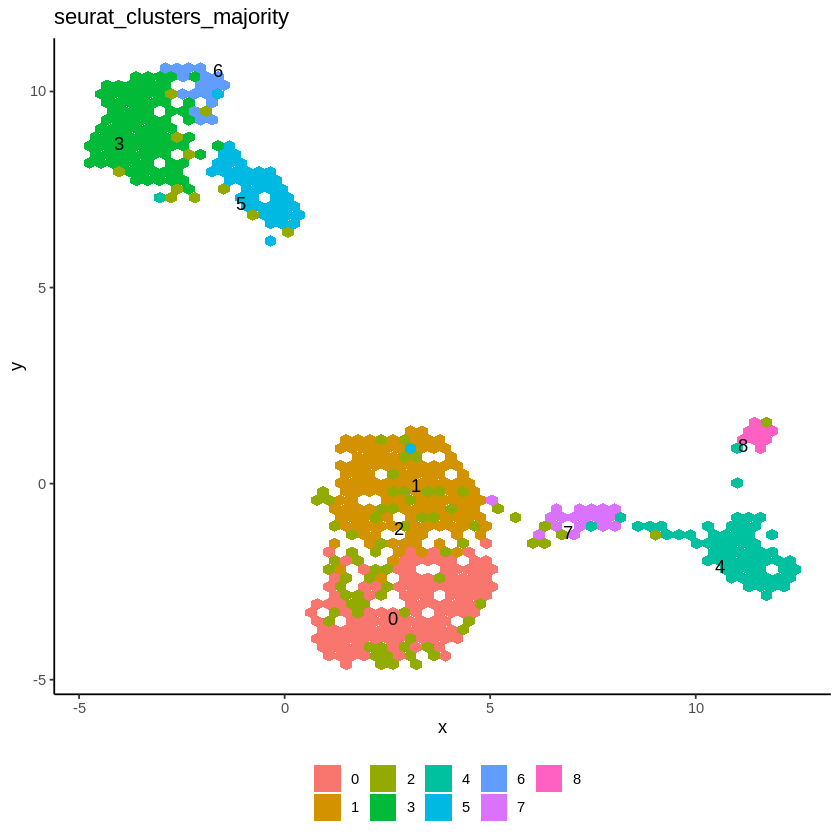

In [88]:
label_df <- make_hexbin_label(schex.fibroblasts, col = "seurat_clusters")
pp <- plot_hexbin_meta(schex.fibroblasts, col = "seurat_clusters", action = "majority")
pp + ggrepel::geom_label_repel(data = label_df, aes(x = x, y = y, label = label), colour = "black", 
    label.size = NA, fill = NA)

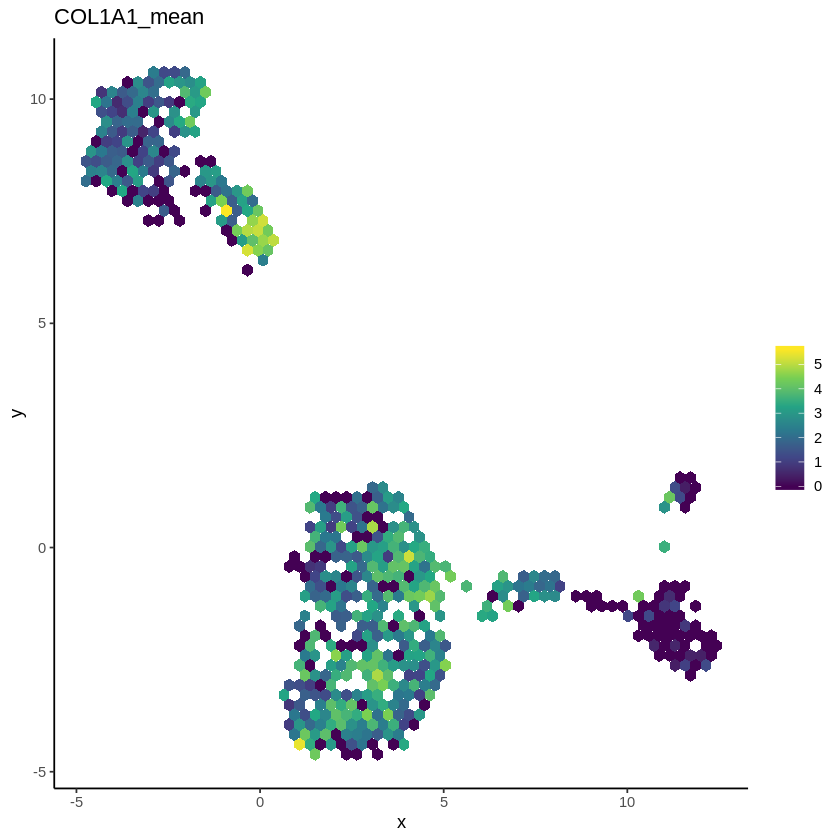

In [89]:
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'COL1A1', action = "mean")
plot(p1)

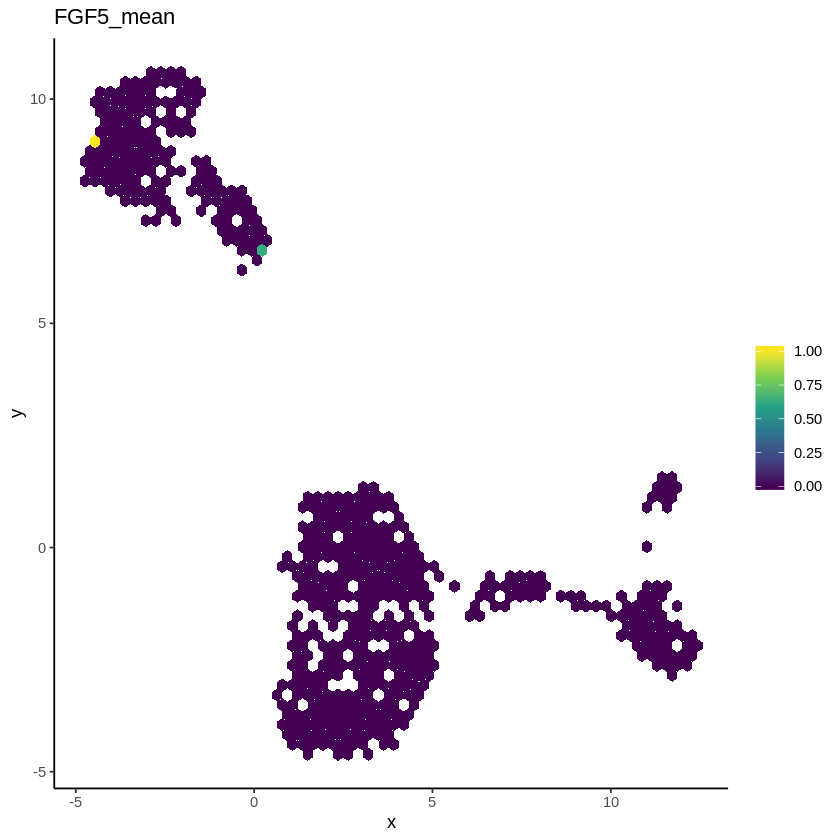

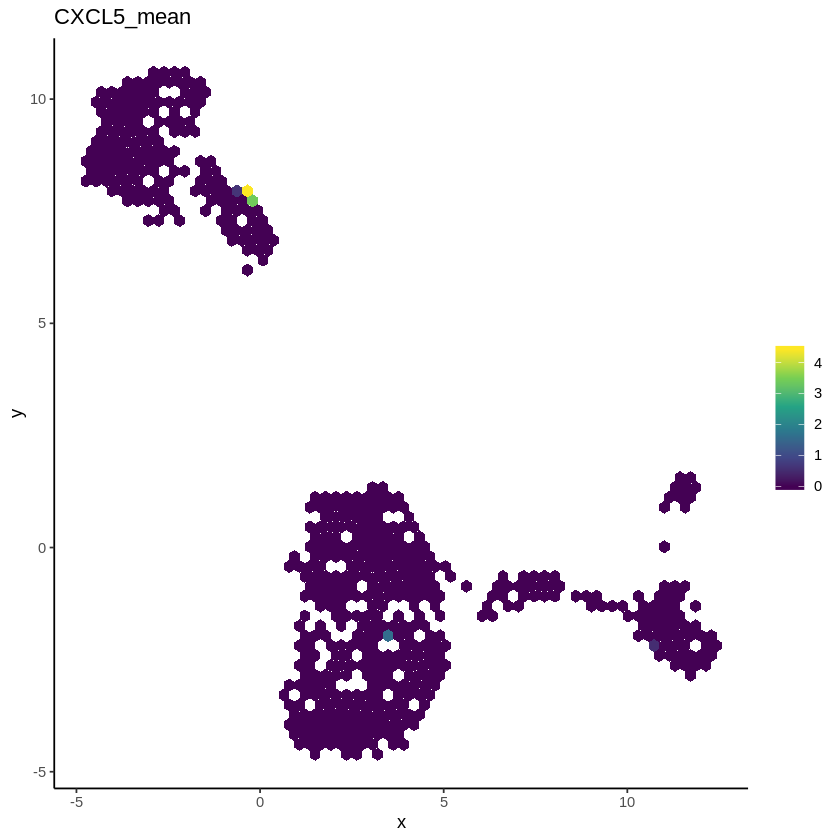

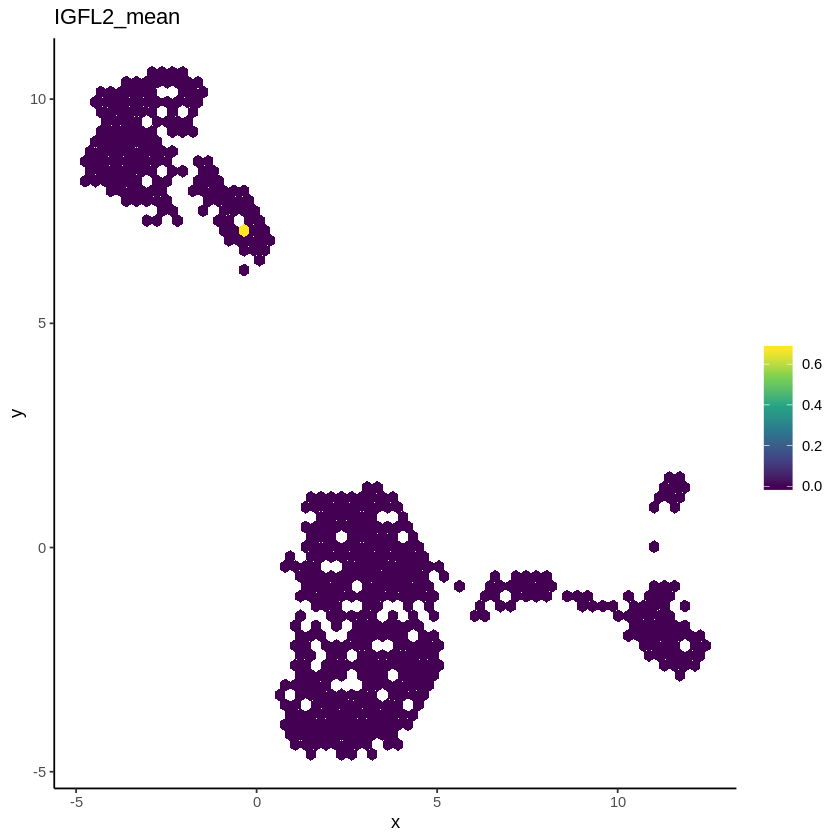

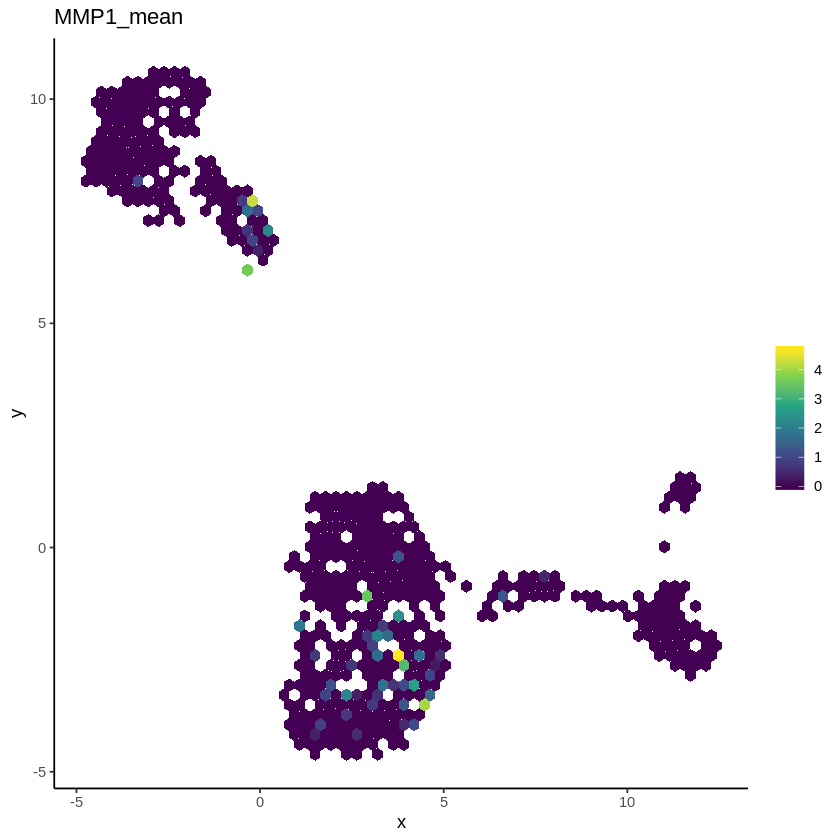

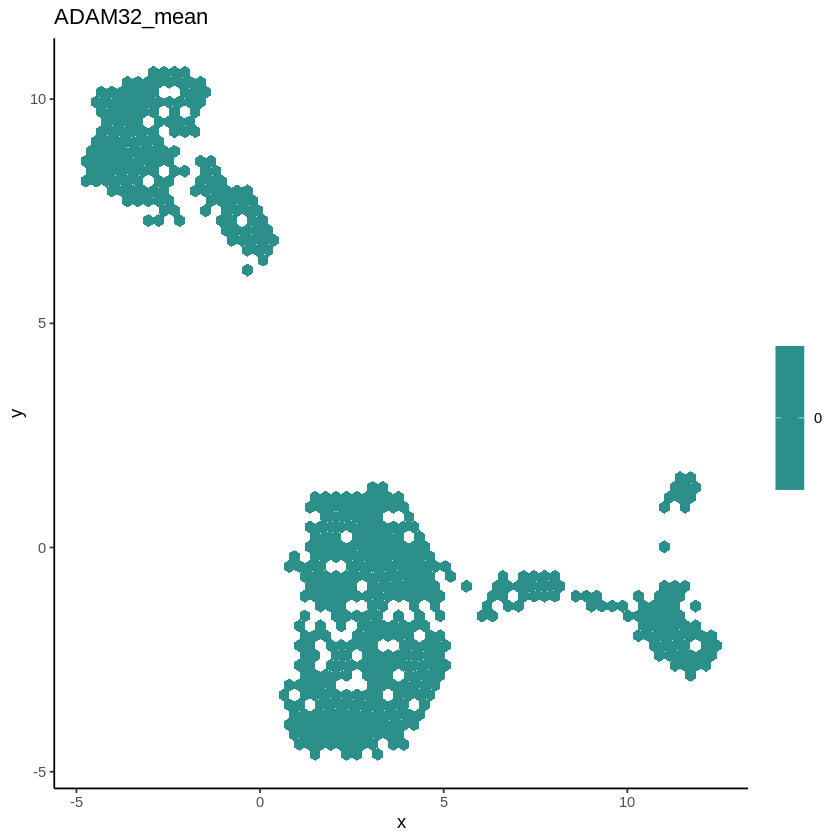

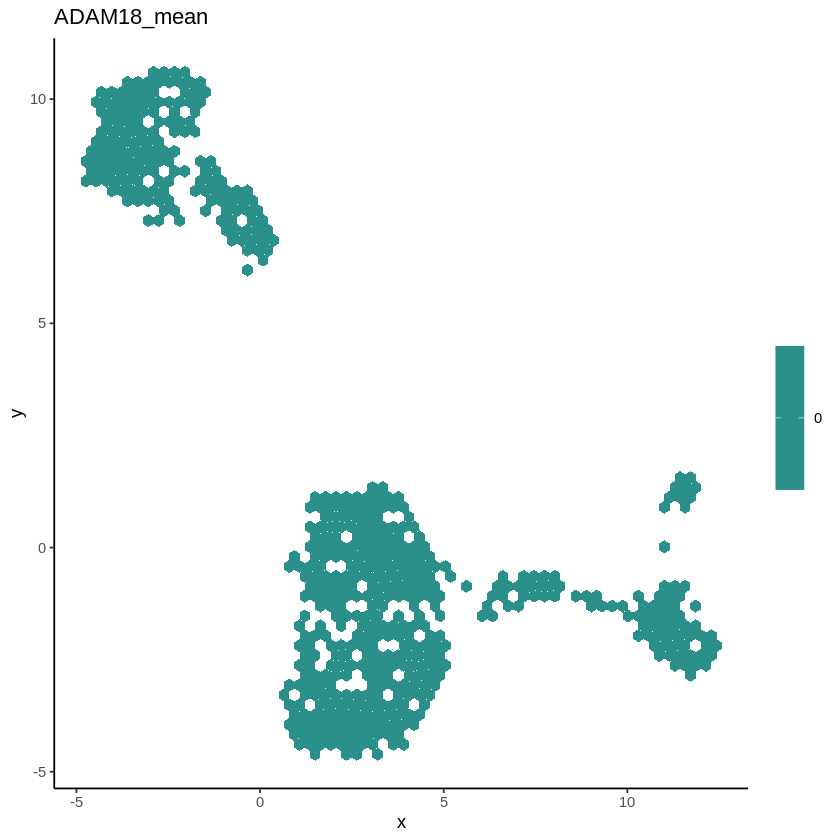

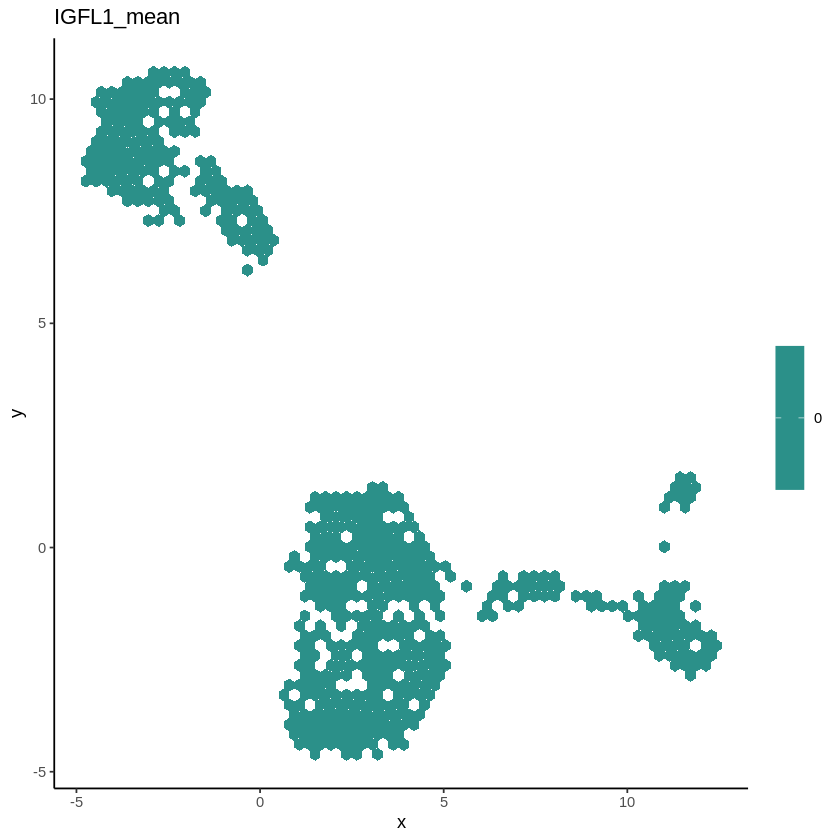

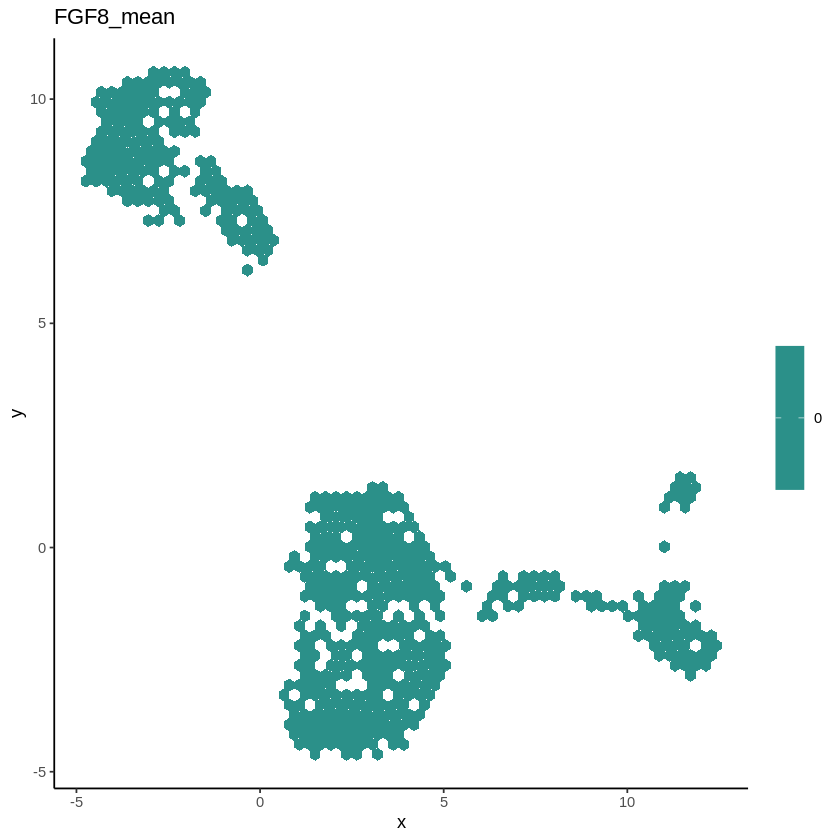

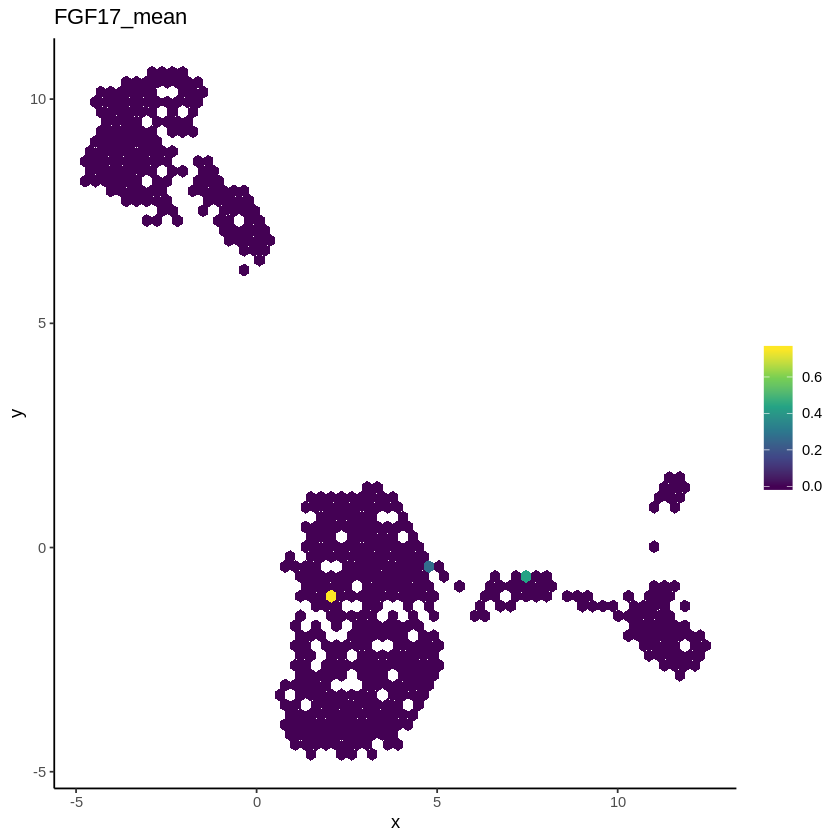

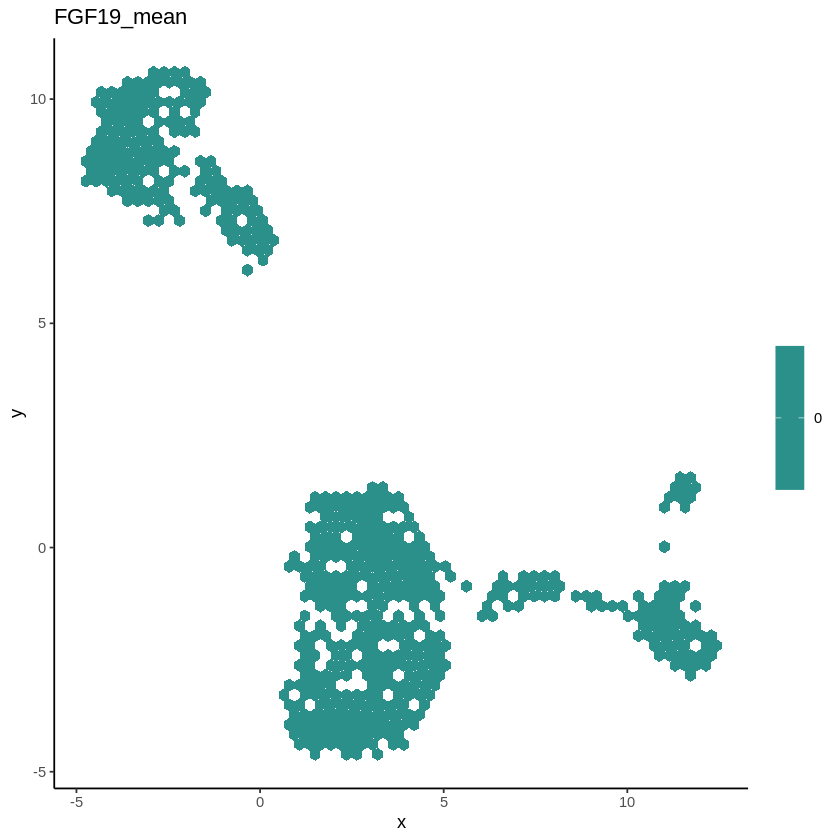

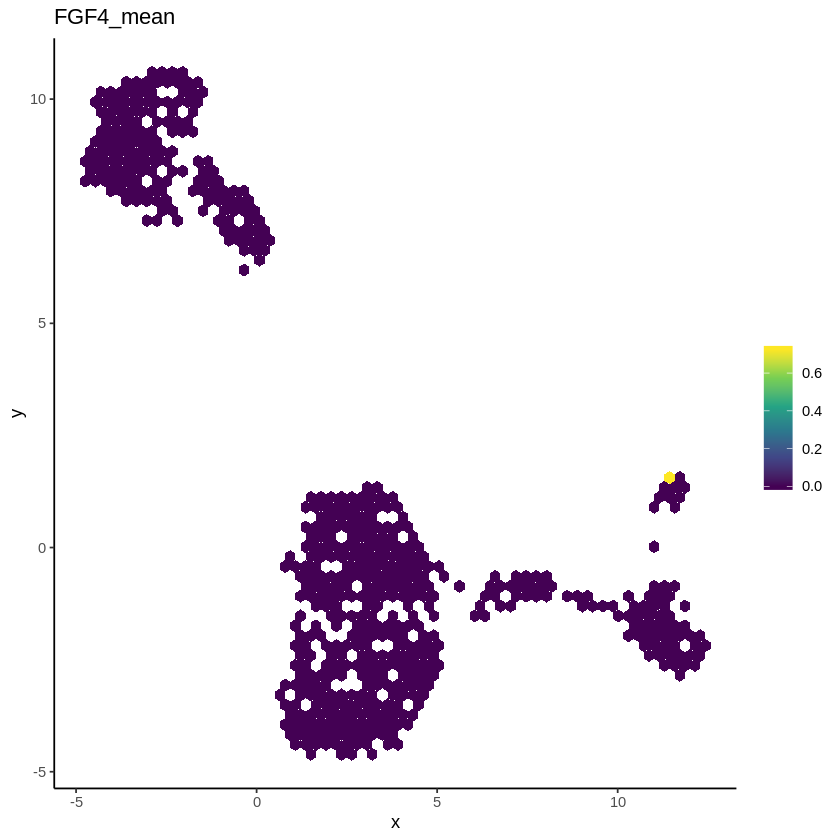

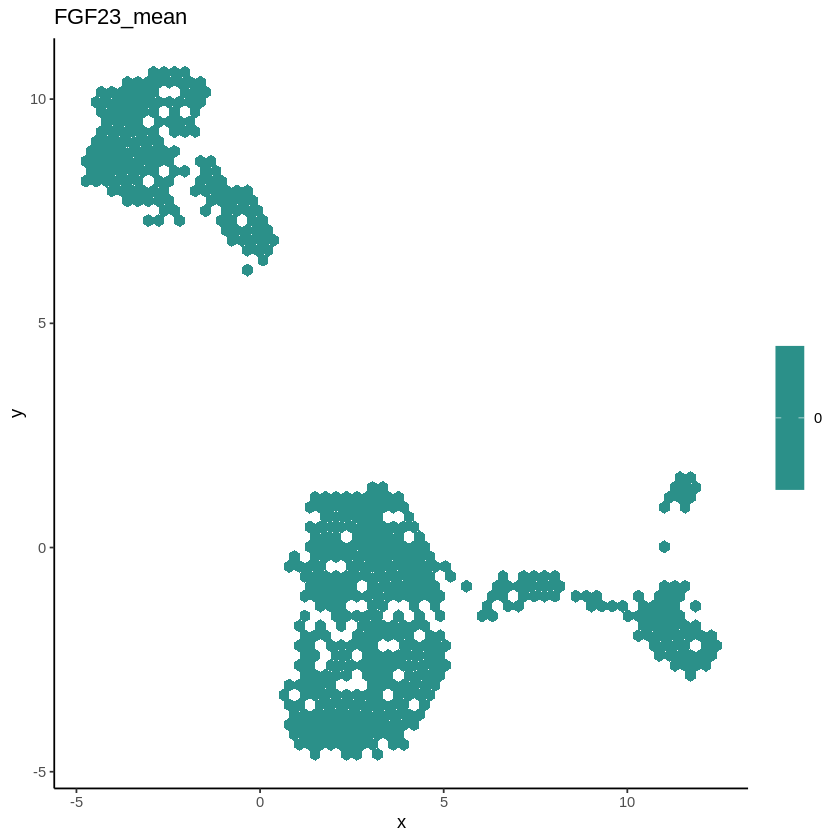

In [90]:
for (i in 1:length(caf.markers)){
    p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = caf.markers[i], action = "mean")
    plot(p1)
}

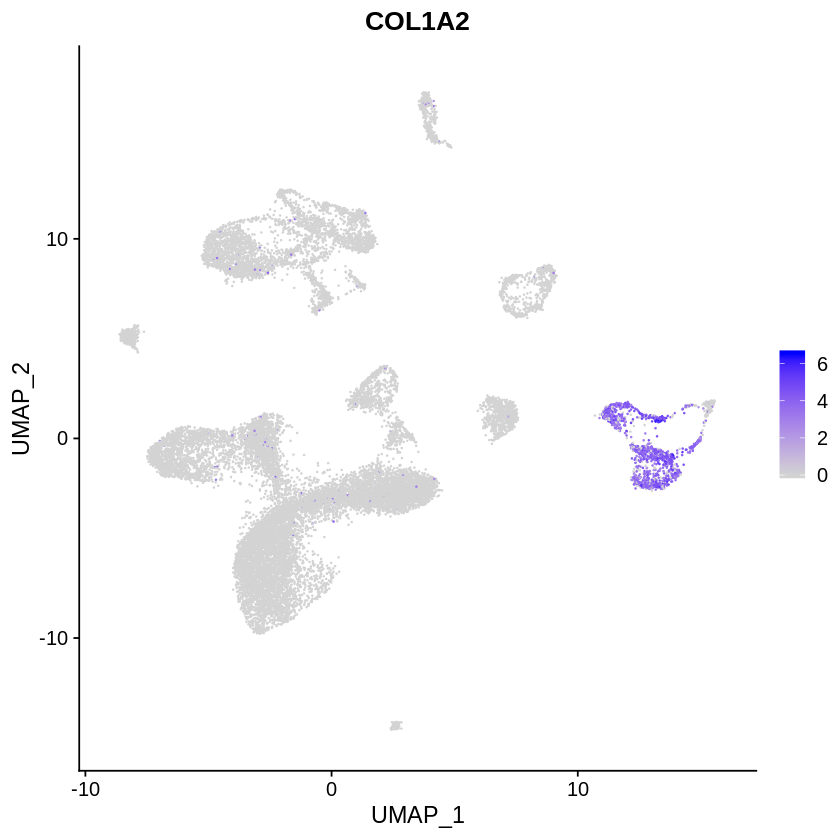

In [91]:
FeaturePlot(data.integrated, features = 'COL1A2')

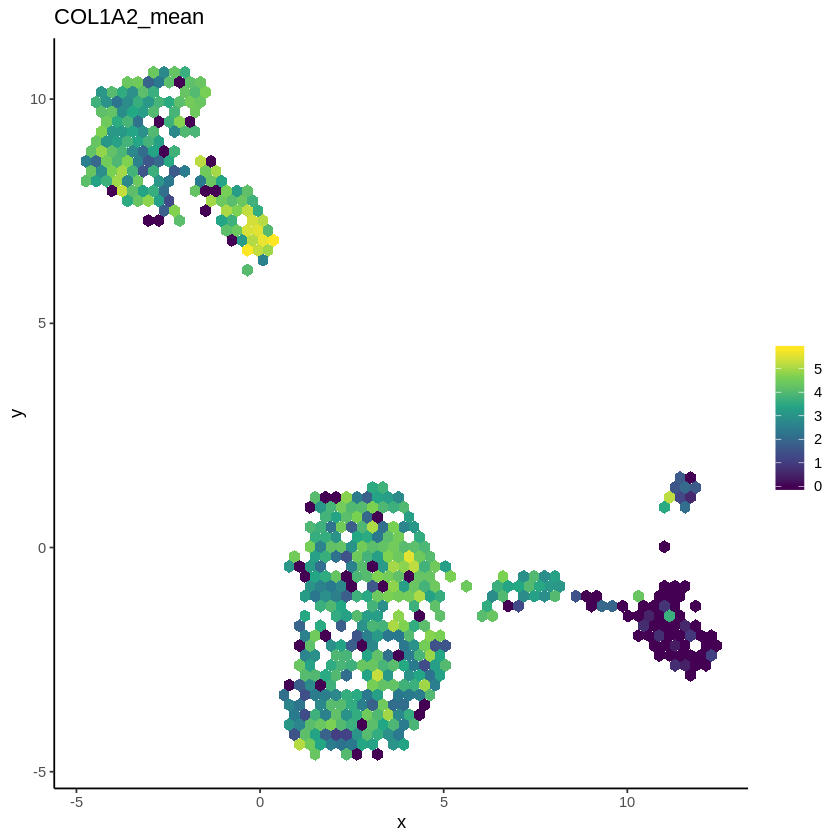

In [92]:
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'COL1A2', action = "mean")
plot(p1)

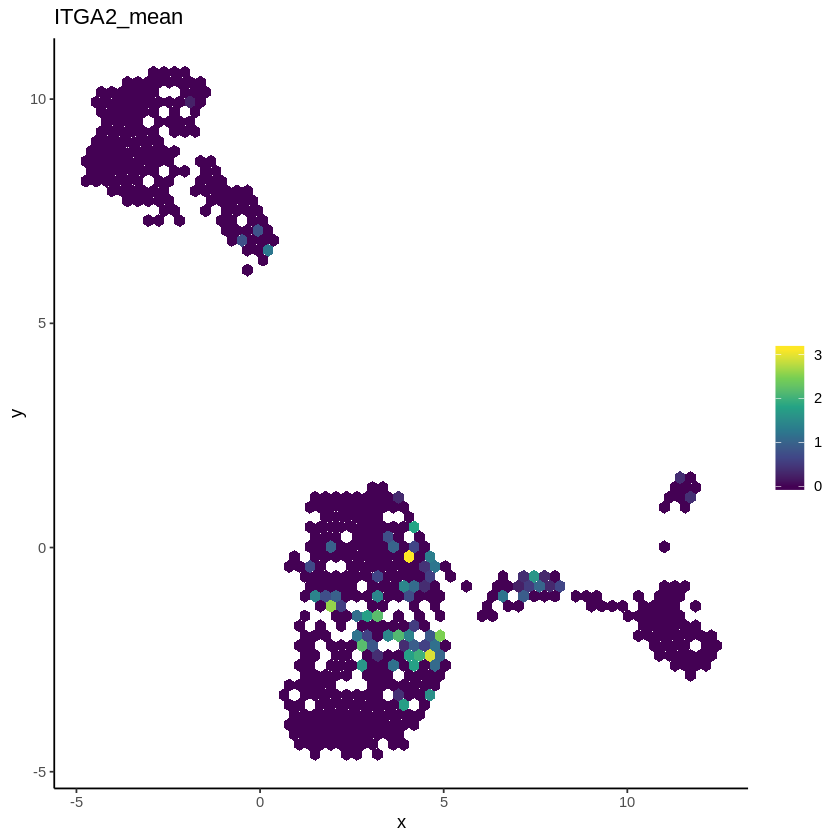

In [93]:
# activated fibroblasts
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'ITGA2', action = "mean")
plot(p1)

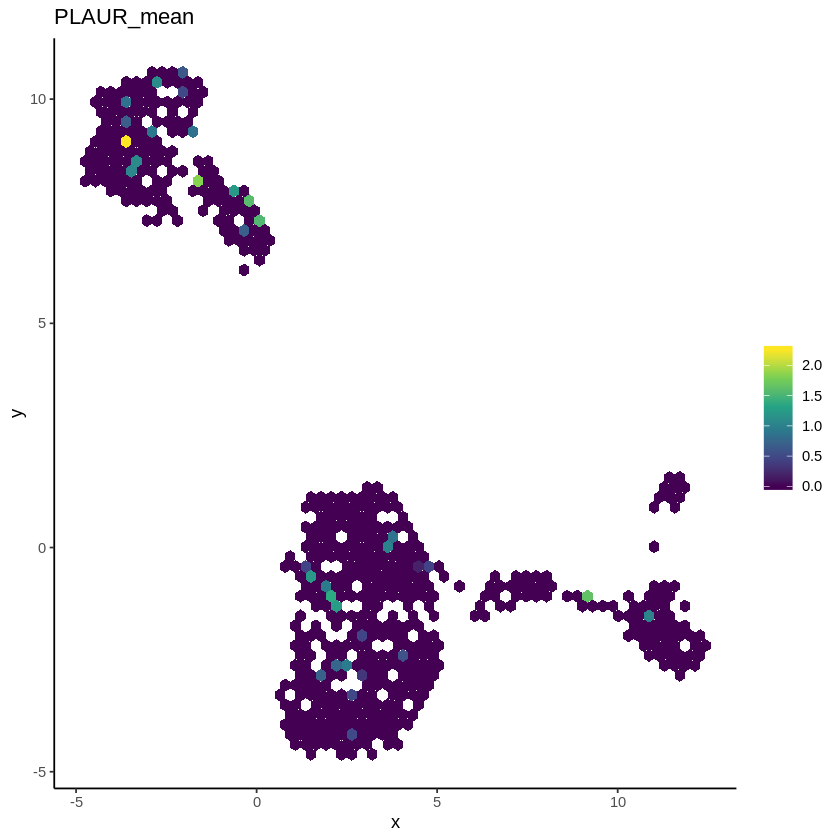

In [94]:
# activated fibroblasts
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'PLAUR', action = "mean")
plot(p1)

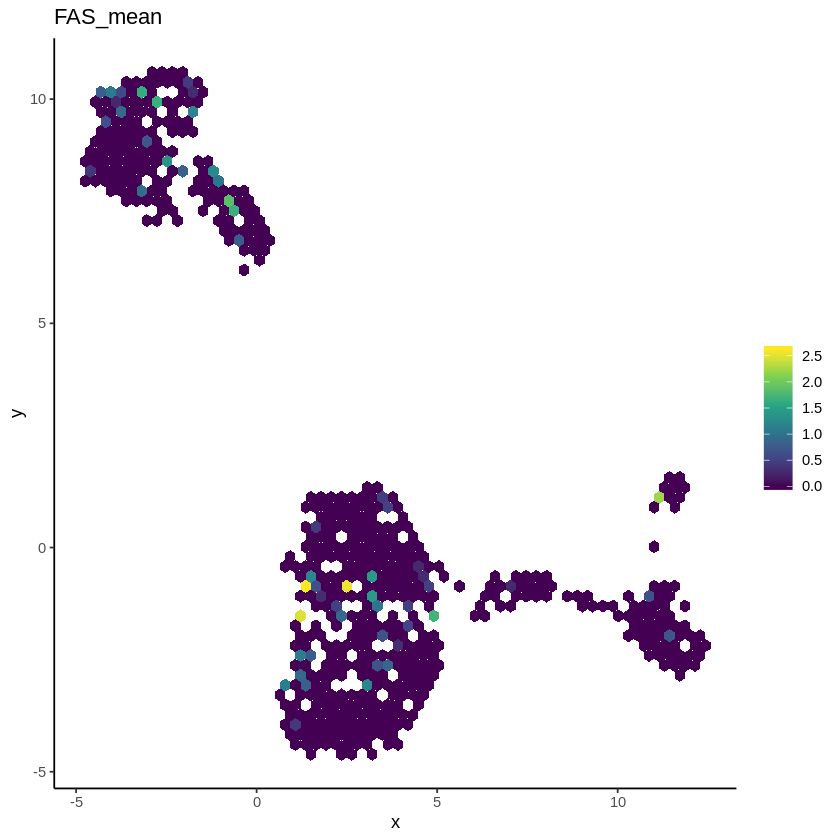

In [95]:
# activated fibroblasts
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'FAS', action = "mean")
plot(p1)

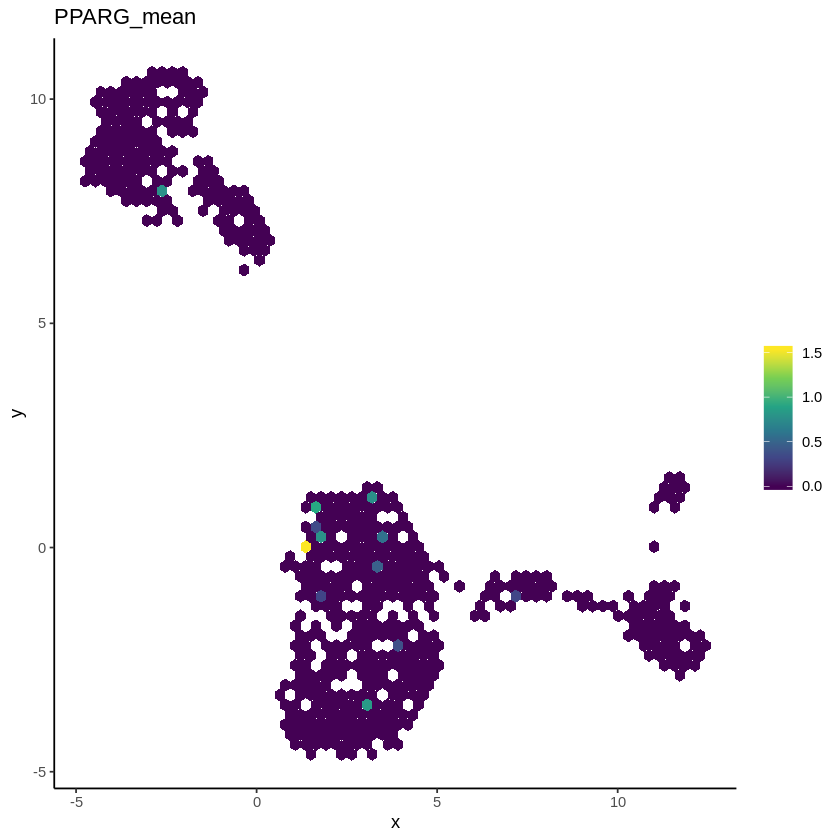

In [96]:
# activated fibroblasts
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'PPARG', action = "mean")
plot(p1)

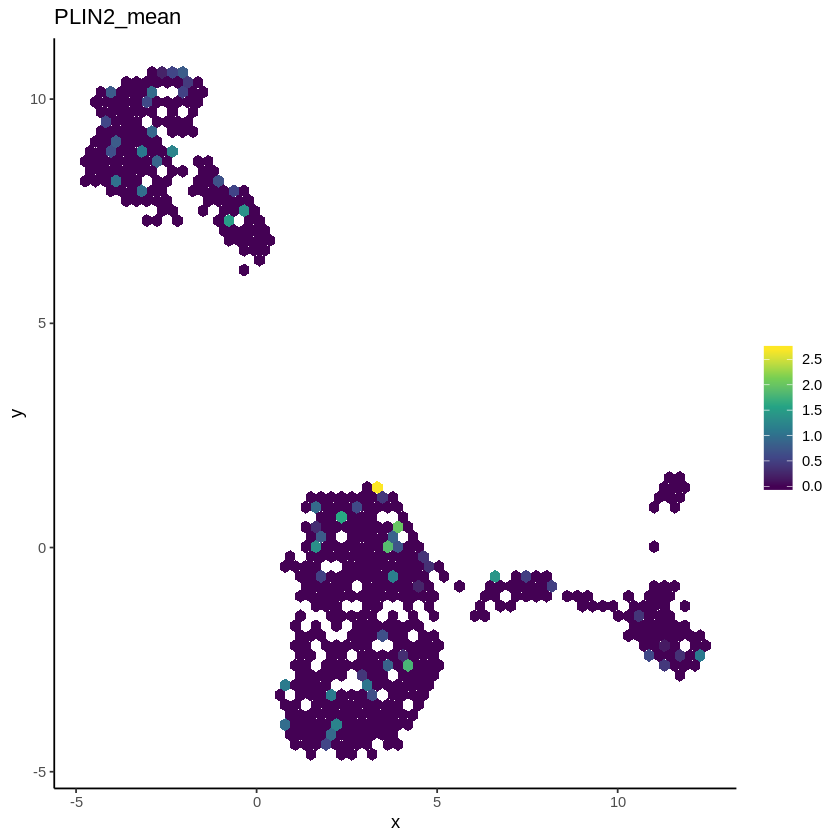

In [97]:
# activated fibroblasts
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'PLIN2', action = "mean")
plot(p1)

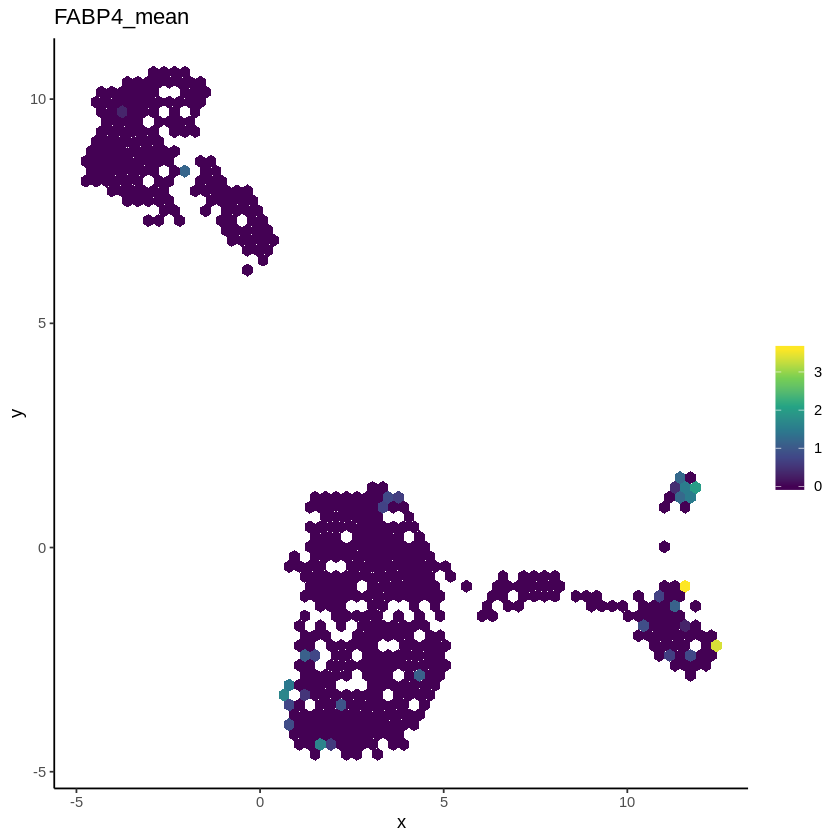

In [98]:
# activated fibroblasts
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'FABP4', action = "mean")
plot(p1)

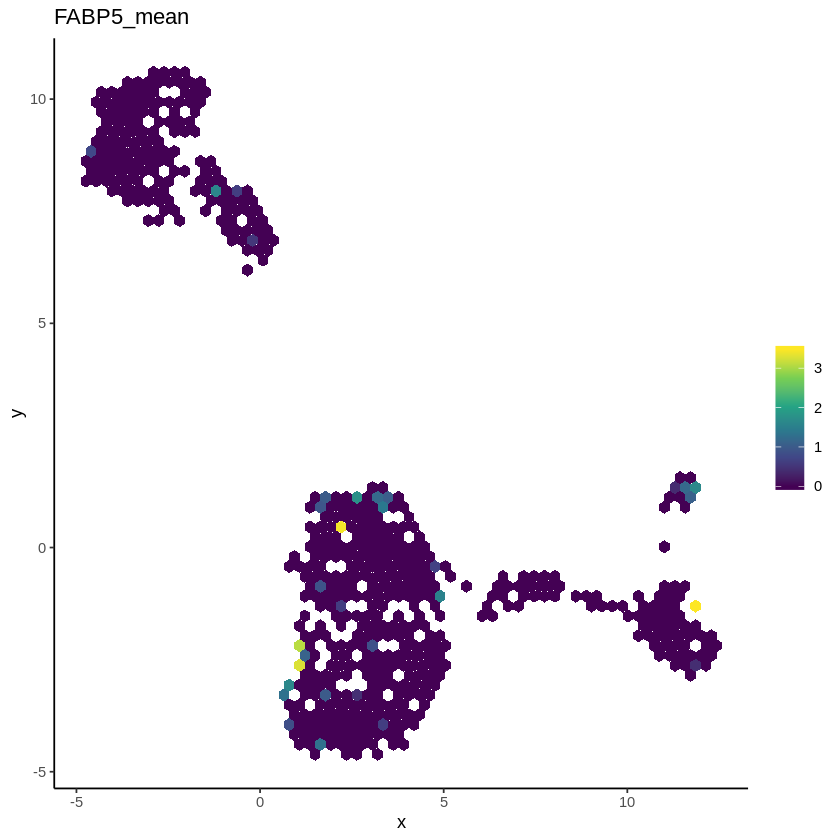

In [99]:
# activated fibroblasts
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'FABP5', action = "mean")
plot(p1)

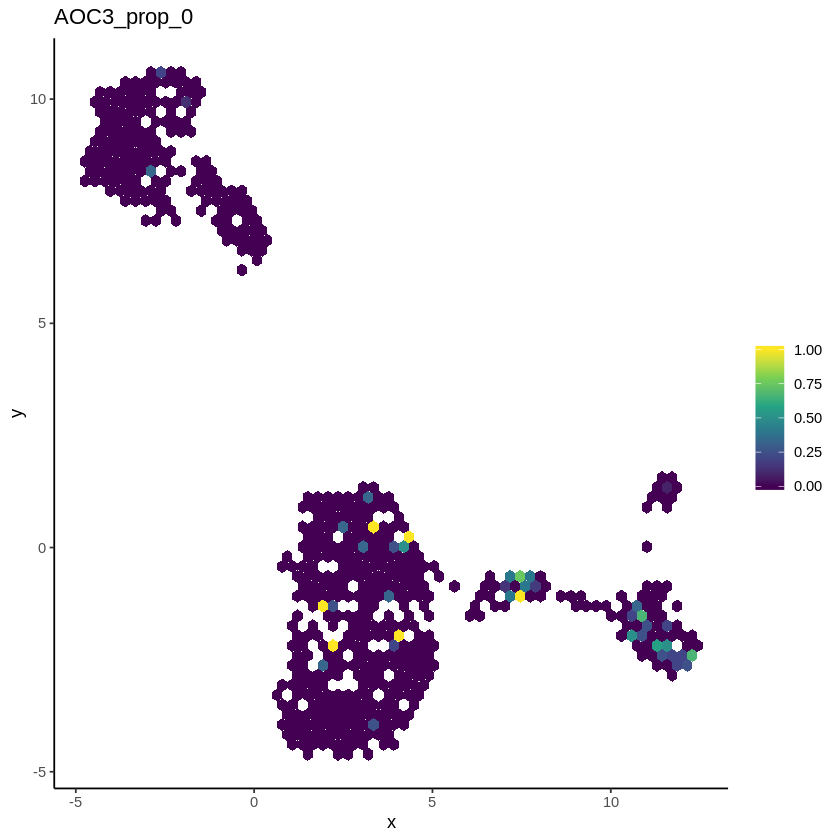

In [100]:
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'AOC3', action = "prop_0")
plot(p1)

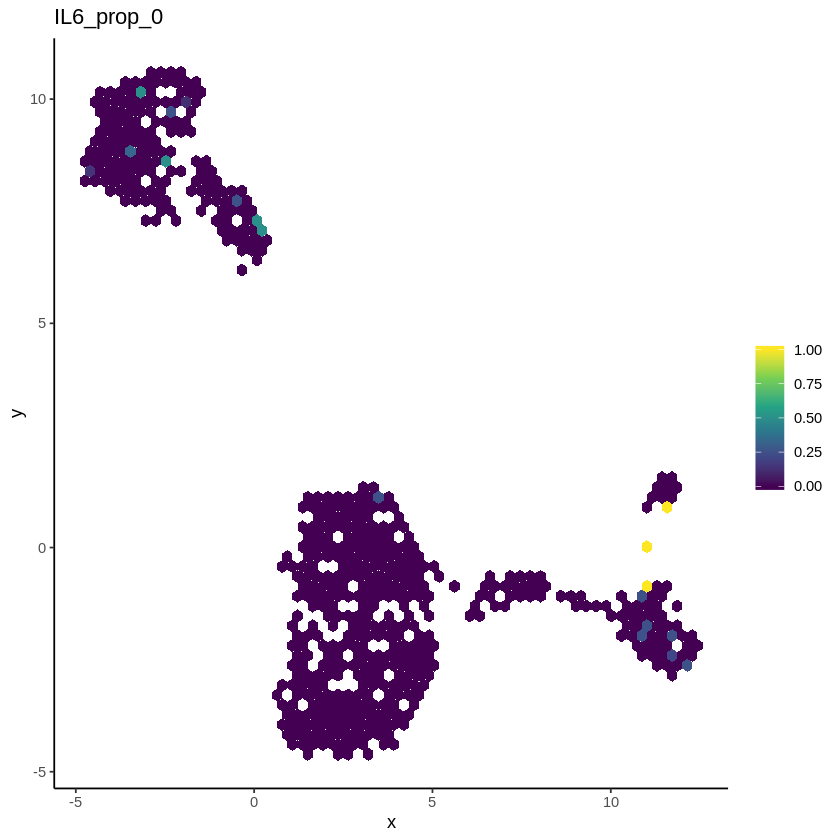

In [101]:
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'IL6', action = "prop_0")
plot(p1)

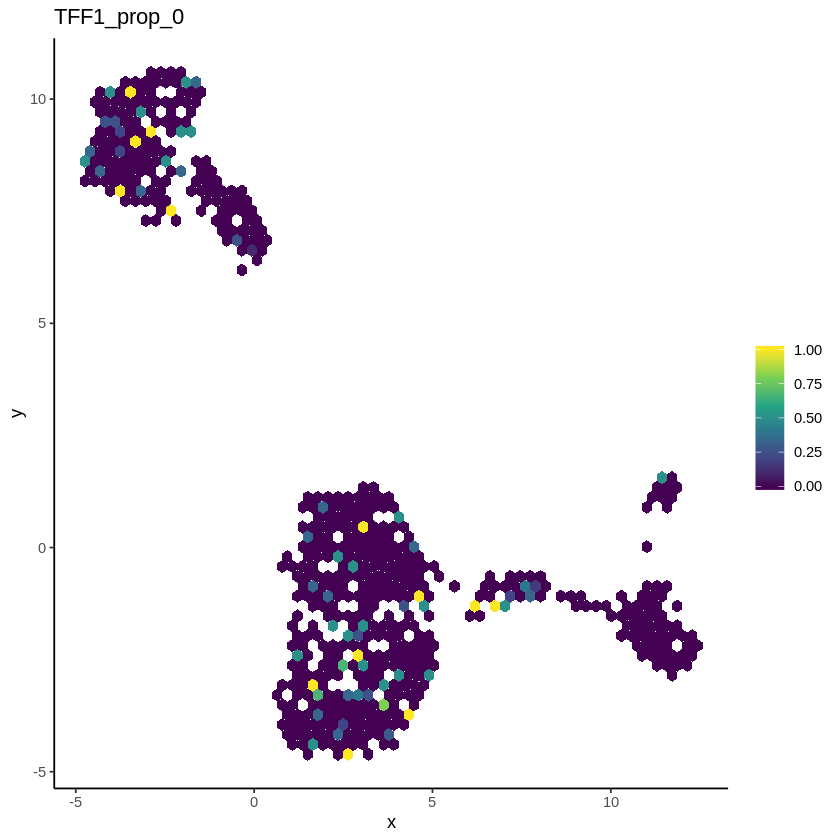

In [102]:
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'TFF1', action = "prop_0")
plot(p1)

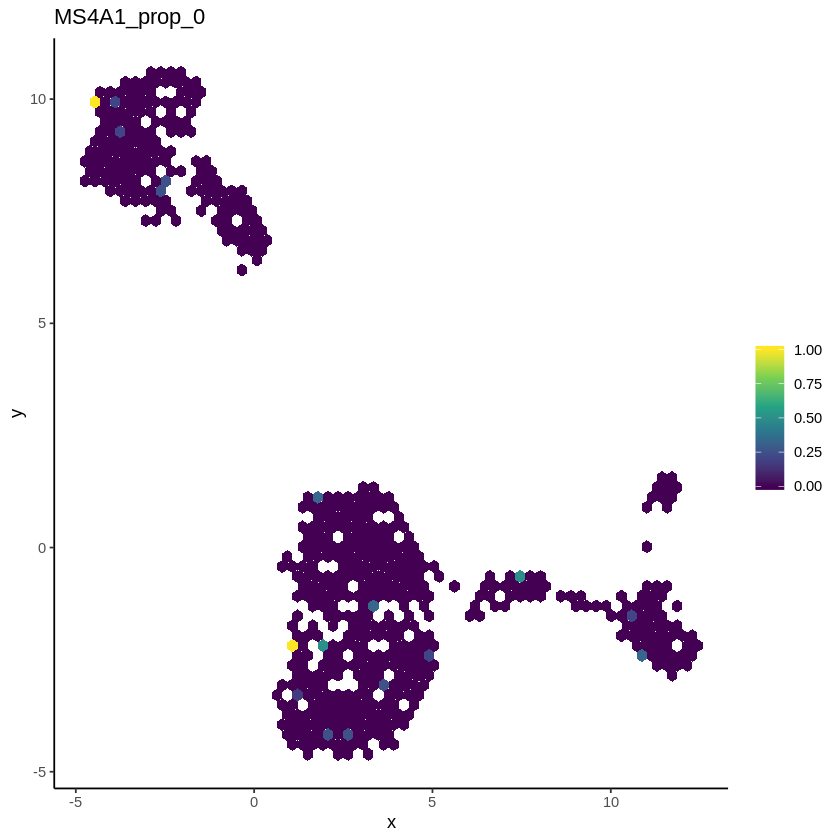

In [103]:
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'MS4A1', action = "prop_0")
plot(p1)

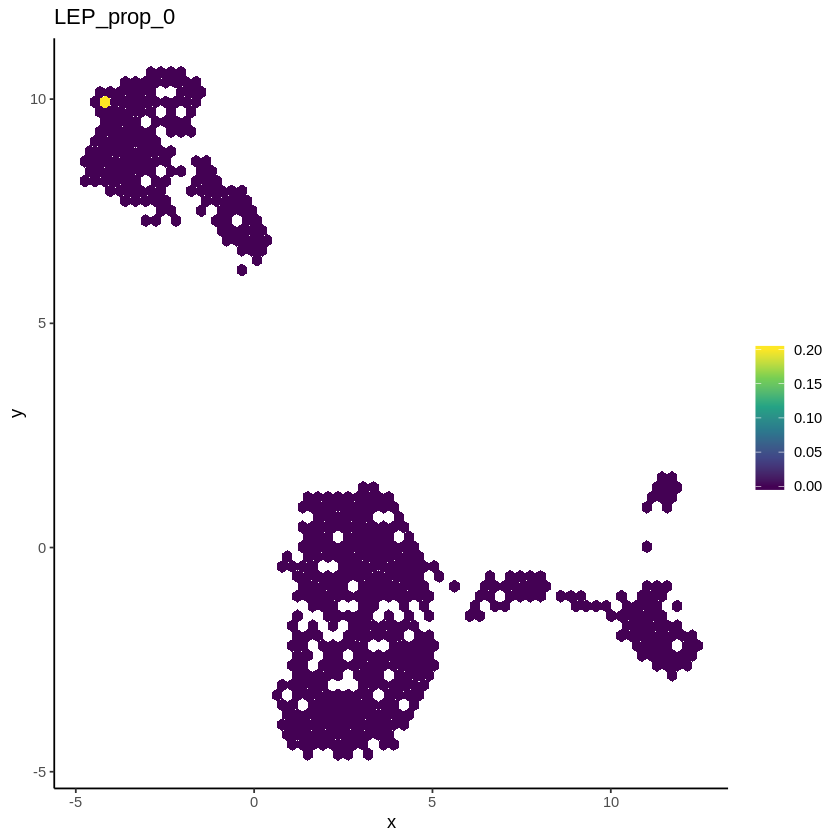

In [104]:
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'LEP', action = "prop_0")
plot(p1)

In [106]:
cluster0_4 <- FindMarkers(fibroblasts, ident.1 = 4, ident.2=0, only.pos=TRUE)

In [107]:
cluster0_8 <- FindMarkers(fibroblasts, ident.1 = 8, ident.2=0, only.pos=TRUE)

In [108]:
cluster0_4

p_val        avg_logFC pct.1 pct.2 p_val_adj   
MYL9     5.569179e-64 3.002818  0.939 0.236 1.867791e-59
TAGLN    3.014840e-60 2.999892  0.915 0.220 1.011117e-55
ADIRF    1.589721e-57 3.476428  0.897 0.263 5.331607e-53
MYH11    7.218182e-55 3.323213  0.721 0.012 2.420834e-50
DSTN     2.545209e-53 2.734886  0.885 0.320 8.536123e-49
ACTA2    5.736120e-48 2.543725  0.752 0.085 1.923780e-43
PLN      2.483105e-44 2.895143  0.600 0.004 8.327836e-40
SORBS2   1.523294e-41 2.952291  0.582 0.012 5.108823e-37
RERGL    1.735331e-37 2.858062  0.515 0.000 5.819952e-33
SNCG     2.298146e-36 2.715962  0.509 0.004 7.707523e-32
PTMA     5.409949e-35 1.034857  0.921 0.757 1.814389e-30
C12orf75 3.115996e-33 2.714249  0.497 0.015 1.045043e-28
TPM2     1.074221e-31 2.032288  0.733 0.313 3.602722e-27
TPM1     4.919727e-30 1.868458  0.727 0.293 1.649978e-25
GADD45B  7.426398e-29 2.487372  0.515 0.062 2.490665e-24
ACTB     4.819479e-28 1.293270  0.806 0.529 1.616357e-23
CRIP1    6.089350e-28 2.101627  0.703 0.297 2.042246e-23
HES4     4.376872e-26 2.070641  0.467 0.046 1.467915e-21
NOTCH3   4.691992e-25 1.975127  0.394 0.015 1.573600e-20
FLNA     9.083420e-24 1.657392  0.630 0.220 3.046397e-19
BCAM     1.274110e-23 1.830756  0.339 0.000 4.273110e-19
LPP      5.671279e-23 1.524906  0.697 0.382 1.902033e-18
JUNB     1.014172e-22 1.728362  0.618 0.232 3.401332e-18
MYLK     1.503141e-22 1.615165  0.624 0.212 5.041236e-18
NTRK2    2.545648e-22 1.760824  0.333 0.004 8.537596e-18
TINAGL1  5.652491e-21 1.557485  0.303 0.000 1.895733e-16
TNS1     5.833342e-21 1.651651  0.424 0.058 1.956386e-16
RGS5     6.109421e-20 2.429637  0.442 0.085 2.048978e-15
MCAM     7.569503e-20 1.638986  0.467 0.097 2.538660e-15
HSPB6    1.380334e-19 1.696989  0.303 0.008 4.629364e-15
⋮        ⋮            ⋮         ⋮     ⋮     ⋮           
PICALM   0.7372006    0.2752870 0.115 0.108 1           
ARF5     0.7677684    0.2985287 0.115 0.108 1           
KIF5B    0.7686149    0.5556566 0.164 0.166 1           
PCMT1    0.7699463    0.2661995 0.103 0.097 1           
TMEM50A  0.7713411    0.2725394 0.145 0.166 1           
IFITM2   0.7717121    0.3832466 0.200 0.236 1           
EIF3G    0.7721763    0.2791321 0.121 0.116 1           
CCDC50   0.7789523    0.3576879 0.091 0.104 1           
SERINC1  0.7814332    0.2760824 0.188 0.189 1           
BHLHE40  0.7907767    0.2672951 0.194 0.193 1           
MBNL2    0.7959825    0.2916102 0.139 0.135 1           
TPI1     0.7984325    0.3621474 0.121 0.120 1           
TOMM20   0.8010644    0.2924294 0.145 0.147 1           
GLUL     0.8215493    0.3005029 0.170 0.170 1           
ANXA6    0.8255086    0.2677532 0.109 0.104 1           
WDR83OS  0.8547769    0.2644444 0.109 0.120 1           
ATP1B3   0.8569744    0.3906606 0.152 0.154 1           
MRPS21   0.8614783    0.3516046 0.103 0.116 1           
C9orf3   0.8658384    0.3130334 0.200 0.205 1           
PPP2CA   0.8728942    0.4141834 0.127 0.127 1           
BEX3     0.8928131    0.3474802 0.285 0.317 1           
LDHB     0.8980549    0.3518427 0.109 0.120 1           
CAMK2N1  0.9127494    0.2574516 0.115 0.120 1           
H1F0     0.9148781    0.3144655 0.109 0.120 1           
NDUFC1   0.9273394    0.4389674 0.127 0.131 1           
CD59     0.9275273    0.2873787 0.176 0.193 1           
BAD      0.9518155    0.3289328 0.115 0.124 1           
CFL1     0.9532336    0.3296555 0.176 0.185 1           
DAZAP2   0.9552535    0.2673647 0.115 0.124 1           
MOCS2    0.9567950    0.2850225 0.115 0.116 1

In [109]:
cluster0_8

p_val        avg_logFC pct.1 pct.2 p_val_adj   
CD36     5.515557e-47 3.099383  0.788 0.008 1.849808e-42
RGS5     8.581901e-43 4.586802  1.000 0.085 2.878198e-38
COX4I2   2.828085e-42 2.755376  0.667 0.000 9.484833e-38
NOTCH3   7.673511e-38 2.668847  0.697 0.015 2.573542e-33
NR2F2    1.016064e-31 2.662809  0.727 0.042 3.407676e-27
ADGRF5   1.094777e-30 2.374203  0.515 0.004 3.671664e-26
STEAP4   2.343555e-27 2.448941  0.576 0.023 7.859814e-23
CDH6     8.438612e-27 2.126097  0.424 0.000 2.830142e-22
HIGD1B   6.394047e-25 2.298090  0.394 0.000 2.144435e-20
NDUFA4L2 6.012106e-22 2.248054  0.576 0.046 2.016340e-17
APOLD1   2.779932e-21 1.989288  0.394 0.008 9.323336e-17
PDGFRB   6.759748e-21 2.381018  0.576 0.050 2.267084e-16
ADIRF    9.144028e-20 2.472953  0.879 0.263 3.066724e-15
GUCY1A2  1.630651e-17 1.577197  0.273 0.000 5.468877e-13
MEF2C    1.994005e-17 2.365509  0.485 0.042 6.687494e-13
MYO1B    2.669879e-17 2.058649  0.576 0.077 8.954240e-13
MGP      1.156492e-16 2.157697  0.515 0.058 3.878644e-12
HES4     1.463929e-16 2.024318  0.485 0.046 4.909725e-12
IGFBP7   5.711858e-16 2.435266  0.879 0.394 1.915643e-11
TINAGL1  1.091971e-15 1.621871  0.242 0.000 3.662254e-11
ADAMTS4  1.418507e-15 1.956920  0.394 0.027 4.757390e-11
EDNRA    2.965295e-14 1.727013  0.394 0.031 9.945006e-10
ENPEP    7.161443e-14 1.363486  0.212 0.000 2.401805e-09
ADCY3    1.944279e-13 1.421435  0.364 0.027 6.520724e-09
FABP4    4.468415e-13 2.301488  0.394 0.039 1.498617e-08
PRSS23   8.169565e-13 2.088249  0.485 0.077 2.739909e-08
MCAM     1.389328e-12 1.520792  0.545 0.097 4.659530e-08
LURAP1L  2.043561e-12 1.761633  0.333 0.027 6.853696e-08
CSRP2    2.434300e-12 1.807815  0.242 0.008 8.164155e-08
ARHGDIB  2.482009e-12 1.352533  0.303 0.019 8.324163e-08
⋮        ⋮            ⋮         ⋮     ⋮     ⋮           
ATP2C1   0.8795957    0.3099039 0.091 0.108 1           
DDX21    0.8819691    0.2948596 0.182 0.216 1           
MAT2A    0.8866735    0.3949816 0.212 0.247 1           
SRP9     0.8936777    0.4805906 0.152 0.151 1           
ELAVL1   0.8964597    0.3320469 0.152 0.151 1           
FGFR1OP2 0.8990671    0.3766023 0.121 0.143 1           
FRG1     0.9073228    0.4072512 0.121 0.120 1           
BMI1     0.9073962    0.4629713 0.091 0.104 1           
FRY      0.9073962    0.4148837 0.091 0.104 1           
CD81     0.9107648    0.4464892 0.242 0.263 1           
SERINC3  0.9110313    0.3116707 0.182 0.216 1           
DNAJC7   0.9191758    0.4836564 0.121 0.143 1           
ATP5MD   0.9359151    0.5333329 0.152 0.162 1           
YWHAE    0.9365148    0.2743390 0.182 0.193 1           
GOLIM4   0.9383441    0.2541416 0.364 0.390 1           
SLTM     0.9401508    0.2787469 0.121 0.139 1           
DDX3X    0.9417653    0.2774488 0.242 0.255 1           
AIMP1    0.9451661    0.2549731 0.121 0.116 1           
SERPINB6 0.9458039    0.3235698 0.212 0.236 1           
PURB     0.9465188    0.3100480 0.121 0.124 1           
ARGLU1   0.9651523    0.2920830 0.303 0.320 1           
KLF10    0.9697078    0.2928070 0.152 0.158 1           
MTPN     0.9767988    0.3775976 0.182 0.216 1           
HSD17B12 0.9775972    0.3570911 0.121 0.131 1           
COMMD6   0.9814367    0.4933110 0.212 0.247 1           
ECE1     0.9833217    0.2879441 0.152 0.154 1           
MYL12A   0.9858517    0.5658797 0.212 0.236 1           
AP2M1    0.9879119    0.4464070 0.121 0.127 1           
UQCRQ    0.9881838    0.3867778 0.121 0.135 1           
ZNF207   1.0000000    0.3505857 0.212 0.239 1

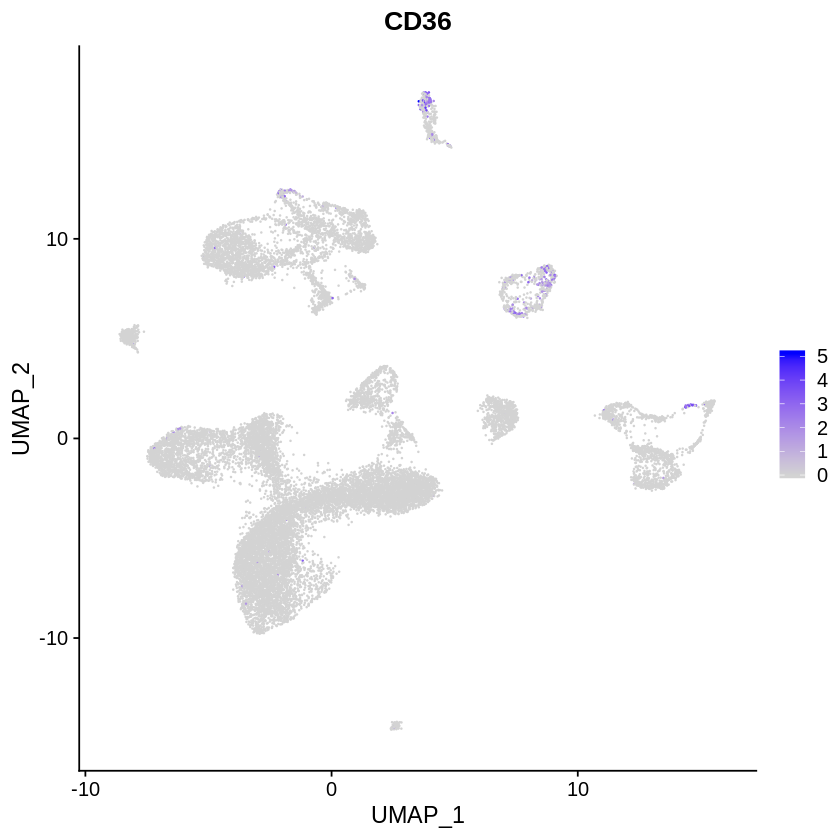

In [110]:
FeaturePlot(data.integrated, features = 'CD36')

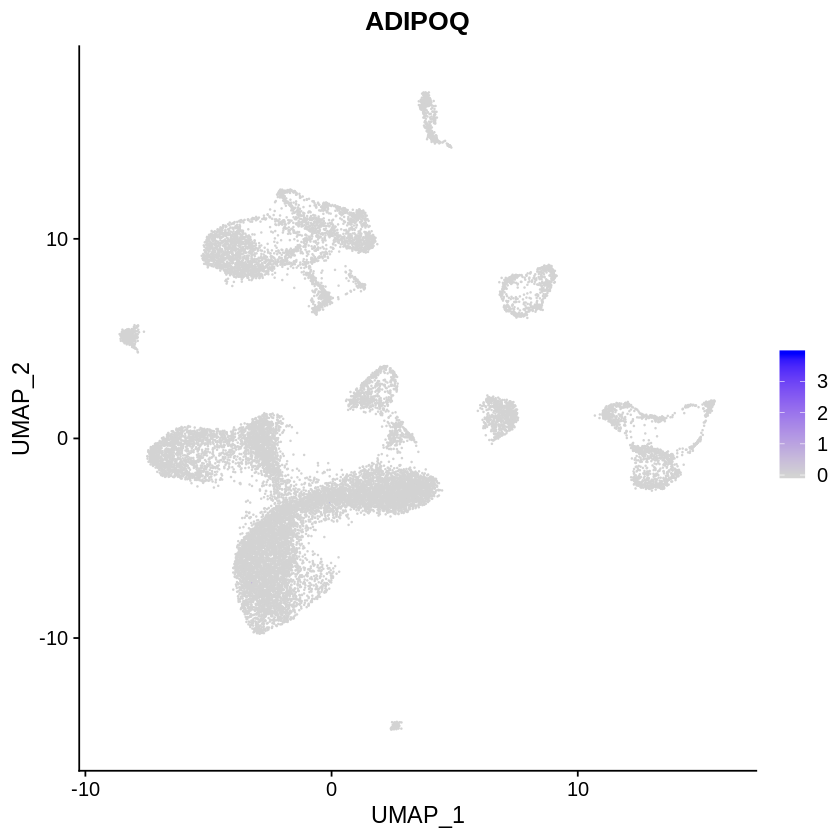

In [111]:
FeaturePlot(data.integrated, features = 'ADIPOQ')

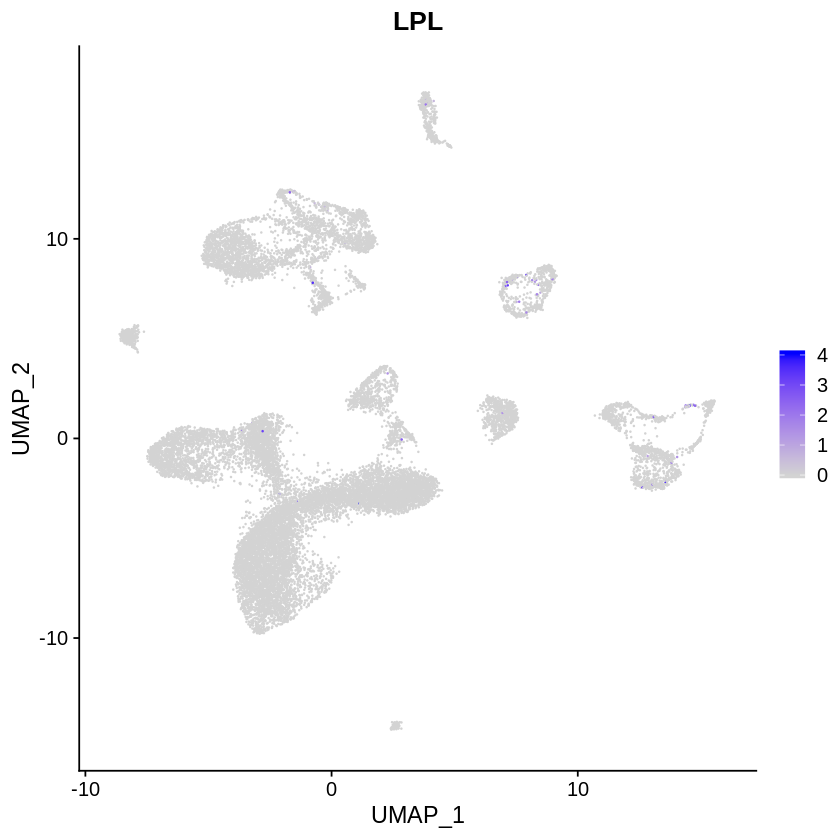

In [112]:
FeaturePlot(data.integrated, features = 'LPL')

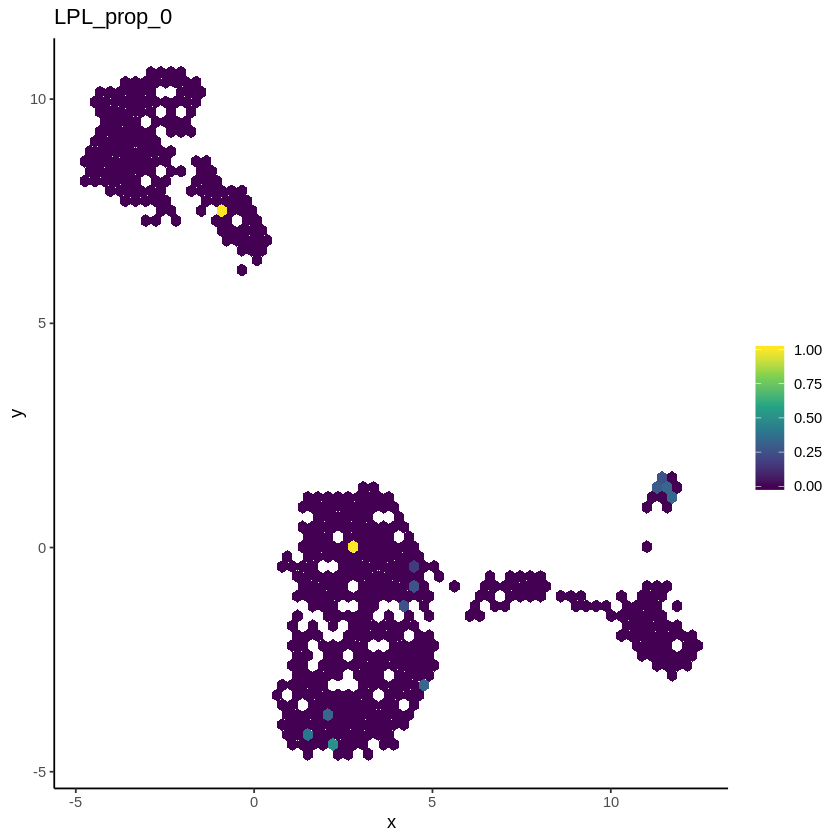

In [113]:
p1 <- plot_hexbin_gene(schex.fibroblasts,type = "logcounts", gene = 'LPL', action = "prop_0")
plot(p1)

In [114]:
subset(fibroblasts, idents=8)

An object of class Seurat 
33538 features across 33 samples within 1 assay 
Active assay: RNA (33538 features)
 2 dimensional reductions calculated: pca, umap

In [115]:
cluster4_8 <- FindMarkers(fibroblasts, ident.1 = 8, ident.2=4, only.pos=TRUE)

In [116]:
cluster4_8

p_val        avg_logFC pct.1 pct.2 p_val_adj   
CD36      5.118104e-34 3.137999  0.788 0.000 1.716510e-29
STEAP4    3.364392e-23 2.602081  0.576 0.006 1.128350e-18
ADGRF5    1.460738e-20 2.347379  0.515 0.006 4.899022e-16
RGS5      1.052033e-19 2.157166  1.000 0.442 3.528307e-15
TFPI      4.070187e-16 1.724508  0.576 0.042 1.365059e-11
PHLDA1    2.098007e-14 1.972185  0.576 0.067 7.036296e-10
HIGD1B    5.108941e-14 2.078963  0.394 0.012 1.713437e-09
SPARC     9.679824e-14 1.788708  0.848 0.212 3.246419e-09
MYO1B     2.969905e-13 1.829224  0.576 0.079 9.960468e-09
CYGB      4.803259e-13 2.028292  0.303 0.000 1.610917e-08
COX4I2    6.349997e-13 1.694952  0.667 0.127 2.129662e-08
CTSC      9.824066e-13 1.740034  0.364 0.012 3.294795e-08
PAG1      1.409738e-11 1.505956  0.303 0.006 4.727978e-07
HLA-B     1.698583e-11 1.802856  0.545 0.079 5.696709e-07
PRSS23    3.598570e-11 1.839458  0.485 0.061 1.206888e-06
LPL       1.248362e-10 1.259696  0.242 0.000 4.186757e-06
SGIP1     1.602153e-10 1.432056  0.333 0.018 5.373301e-06
TRIB2     1.899762e-10 1.406071  0.303 0.012 6.371421e-06
GUCY1A2   2.422527e-10 1.429578  0.273 0.006 8.124670e-06
B2M       3.009694e-09 1.420309  0.848 0.473 1.009391e-04
ADAMTS4   3.570509e-09 1.592147  0.394 0.048 1.197477e-04
GMFG      3.609573e-09 1.349593  0.242 0.006 1.210579e-04
ADCY3     3.633908e-09 1.439904  0.364 0.042 1.218740e-04
SPRY1     6.984235e-09 1.609318  0.424 0.061 2.342373e-04
HLA-A     8.607103e-09 1.629398  0.485 0.097 2.886650e-04
FABP4     9.487403e-09 2.058382  0.394 0.055 3.181885e-04
STOM      1.737661e-08 1.412025  0.606 0.182 5.827769e-04
GBP3      2.996675e-08 1.282428  0.182 0.000 1.005025e-03
DCBLD1    2.996675e-08 1.122426  0.182 0.000 1.005025e-03
CYTOR     3.683607e-08 1.892596  0.303 0.030 1.235408e-03
⋮         ⋮            ⋮         ⋮     ⋮     ⋮           
EPB41L2   0.5957154    0.4051669 0.152 0.121 1           
TBX2      0.5988867    0.2532167 0.242 0.224 1           
ELMSAN1   0.6134661    0.2570897 0.182 0.152 1           
INSR      0.6351200    0.3161391 0.212 0.188 1           
CST3      0.6437093    0.2932367 0.182 0.236 1           
EIF2S1    0.6536821    0.3333739 0.121 0.097 1           
PSMA1     0.6582797    0.3062749 0.121 0.097 1           
ISCU      0.6665263    0.4222174 0.152 0.127 1           
SNX7      0.6719899    0.3568335 0.121 0.103 1           
CTBP2     0.6797354    0.3747137 0.152 0.133 1           
CDS2      0.6895108    0.9124584 0.121 0.109 1           
SSBP2     0.6950217    0.4225073 0.182 0.158 1           
RALBP1    0.7002888    0.2977494 0.152 0.133 1           
VAPA      0.7085392    0.3046961 0.212 0.194 1           
PREPL     0.7168919    0.2620616 0.152 0.133 1           
SRP9      0.7210640    0.3570465 0.152 0.133 1           
FGFR1OP2  0.7226462    0.2692374 0.121 0.103 1           
SLTM      0.7487980    0.3452854 0.121 0.109 1           
NFE2L1    0.7534259    0.3375594 0.121 0.109 1           
EFCAB14   0.7631534    0.2521682 0.182 0.170 1           
LTBP4     0.7766958    0.2510640 0.121 0.109 1           
LINC01197 0.8155573    0.3996721 0.121 0.115 1           
CETN2     0.8295980    0.2556441 0.182 0.176 1           
C18orf32  0.8435331    0.2919089 0.121 0.115 1           
CSRP2     0.8467296    0.2978139 0.242 0.248 1           
ABCA5     0.8717077    0.3350397 0.121 0.115 1           
ITGAV     0.8826283    0.4524445 0.212 0.218 1           
PER1      0.8949151    0.3528103 0.121 0.121 1           
EIF3A     0.9585868    0.2562657 0.152 0.164 1           
RRAS      0.9907973    0.2576780 0.121 0.127 1

## 寄り道

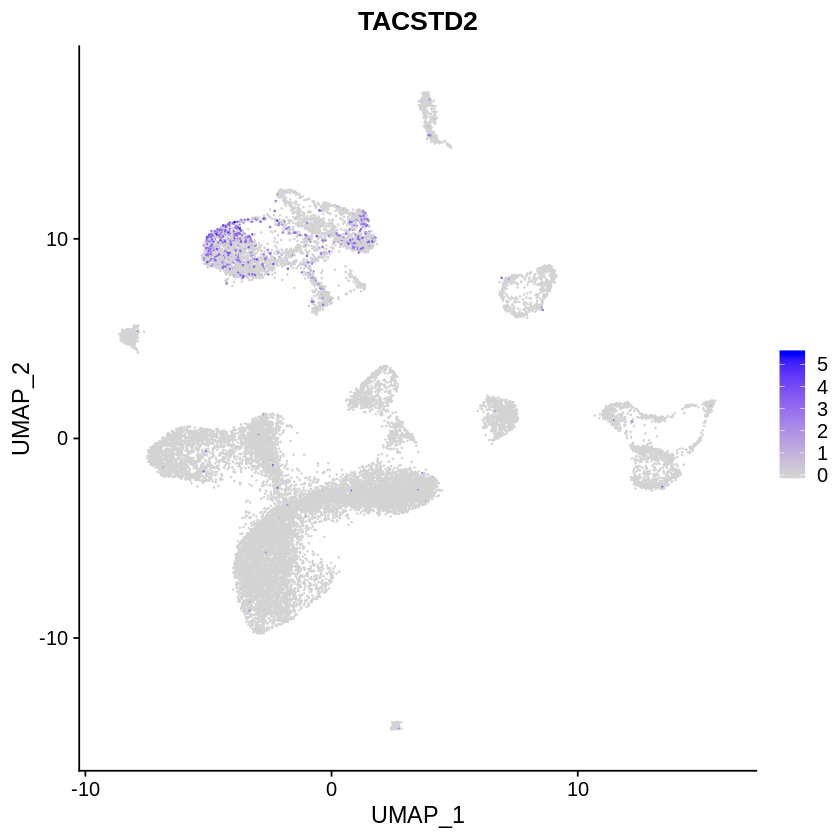

In [117]:
FeaturePlot(data.integrated, features = 'TACSTD2')

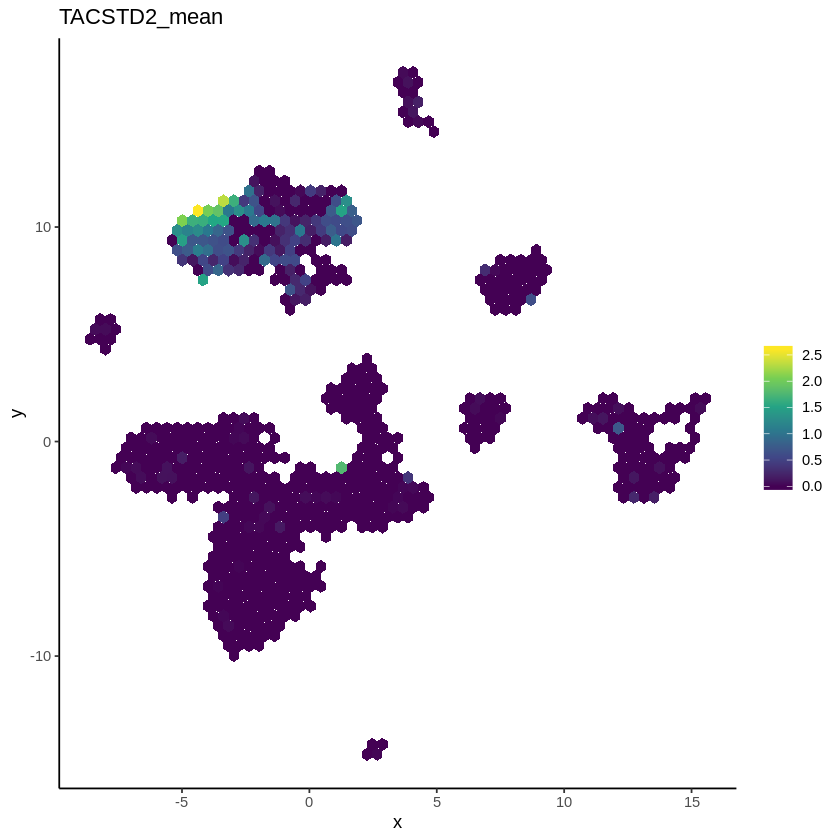

In [118]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'TACSTD2', action = "mean")

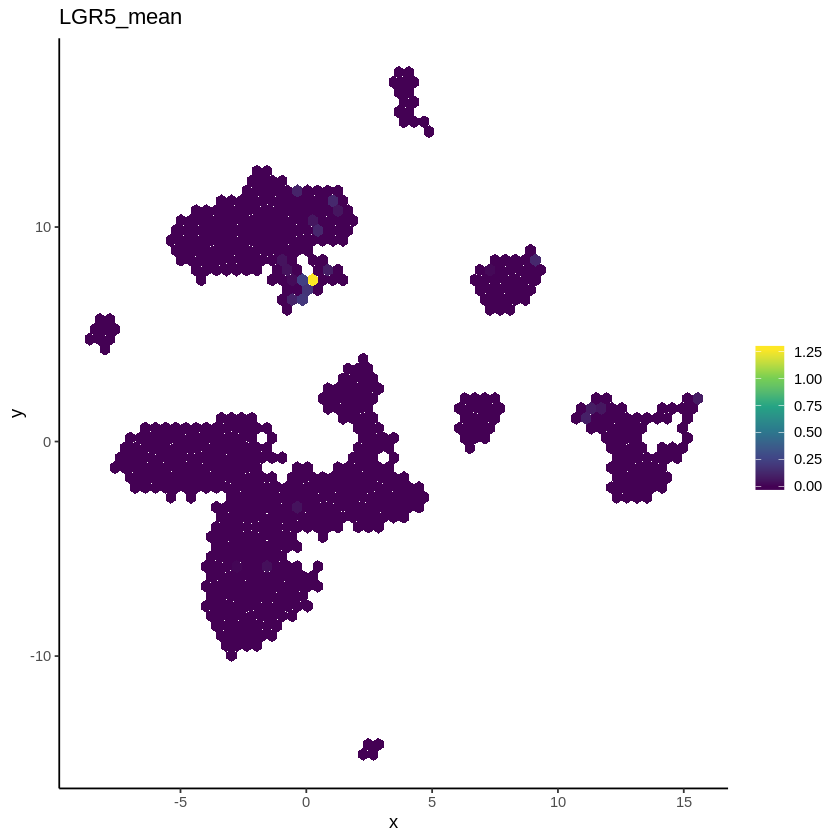

In [119]:
plot_hexbin_gene(data_schex,type = "logcounts", gene = 'LGR5', action = "mean")

In [120]:
endothelials <- UMAP(endothelials)

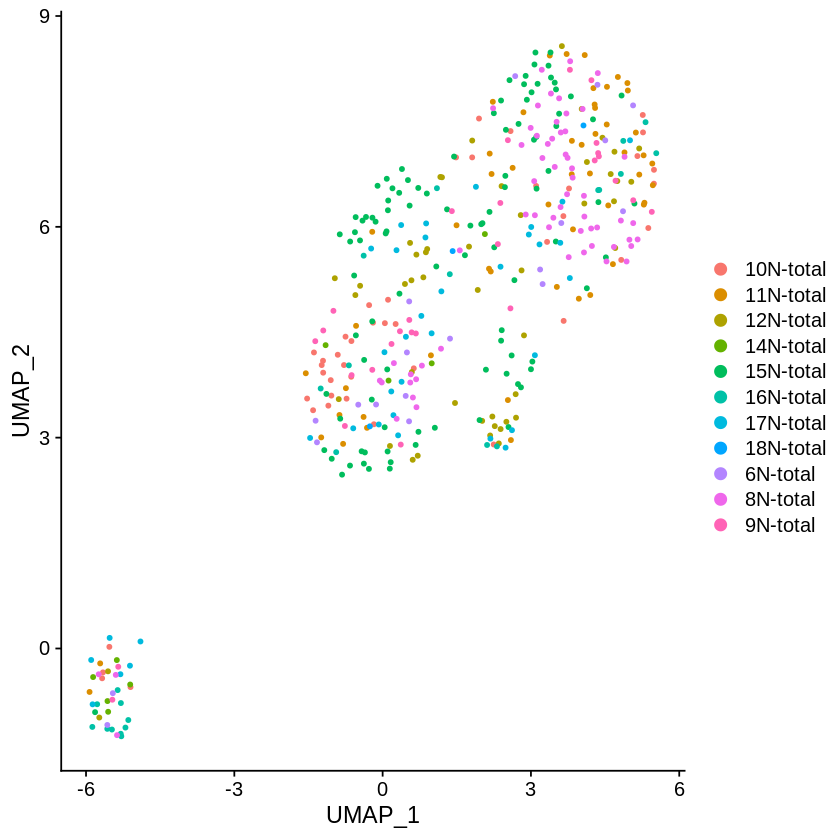

In [121]:
DimPlot(endothelials, group.by='orig.ident')

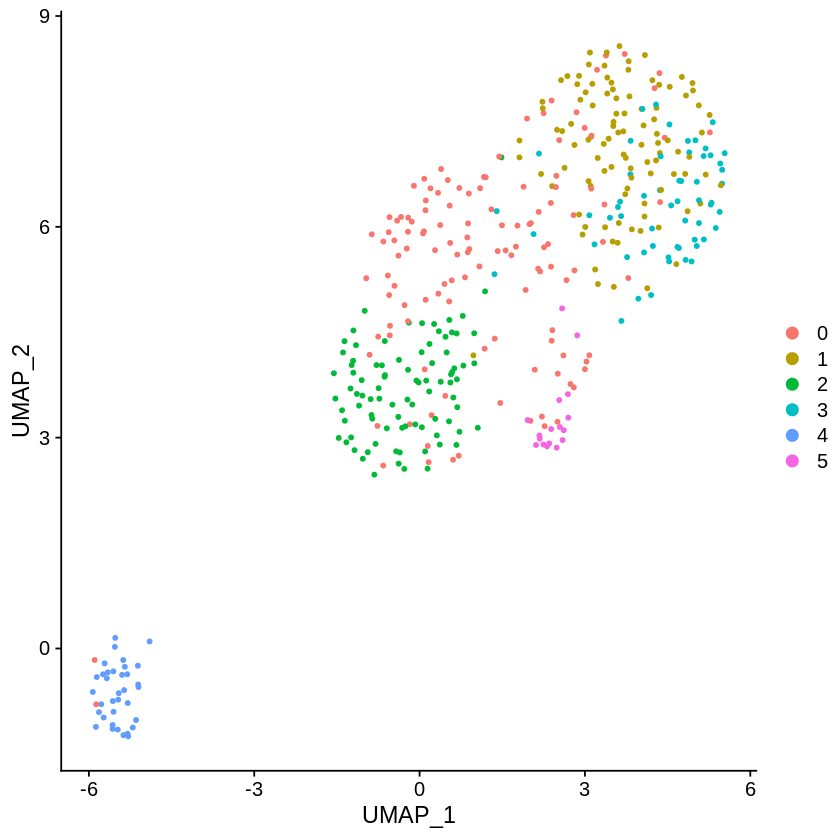

In [122]:
DimPlot(endothelials)

In [123]:
schex.endothelials <- make_hexbin(as.SingleCellExperiment(endothelials), nbins=30, dimension_reduction = 'UMAP')

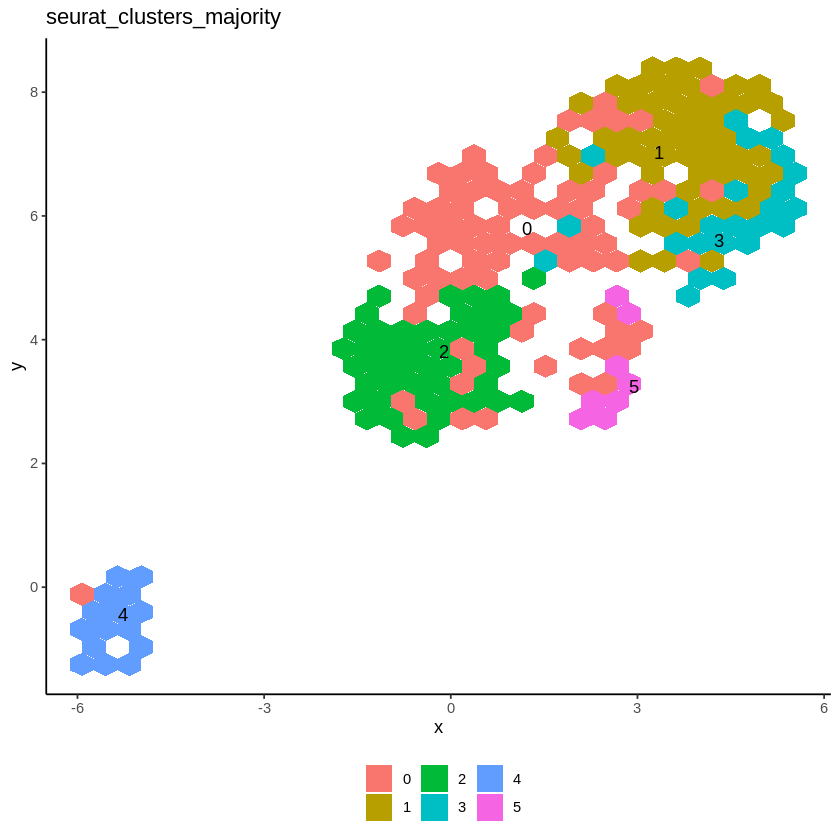

In [124]:
label_df <- make_hexbin_label(schex.endothelials, col = "seurat_clusters")
pp <- plot_hexbin_meta(schex.endothelials, col = "seurat_clusters", action = "majority")
pp + ggrepel::geom_label_repel(data = label_df, aes(x = x, y = y, label = label), colour = "black", 
    label.size = NA, fill = NA)

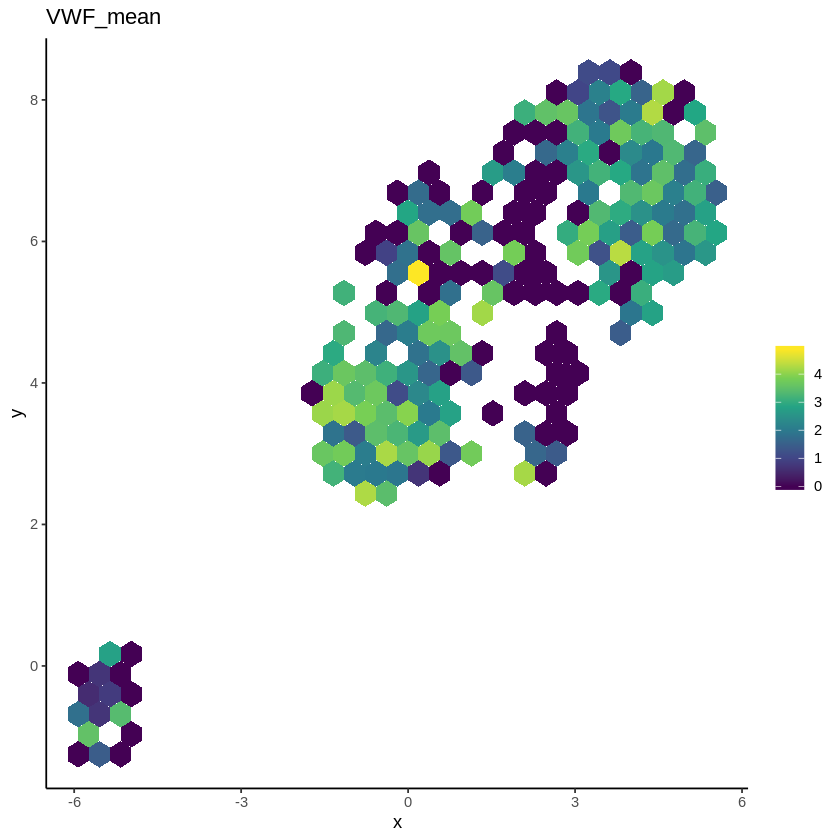

In [125]:
p1 <- plot_hexbin_gene(schex.endothelials,type = "logcounts", gene = 'VWF', action = "mean")
plot(p1)

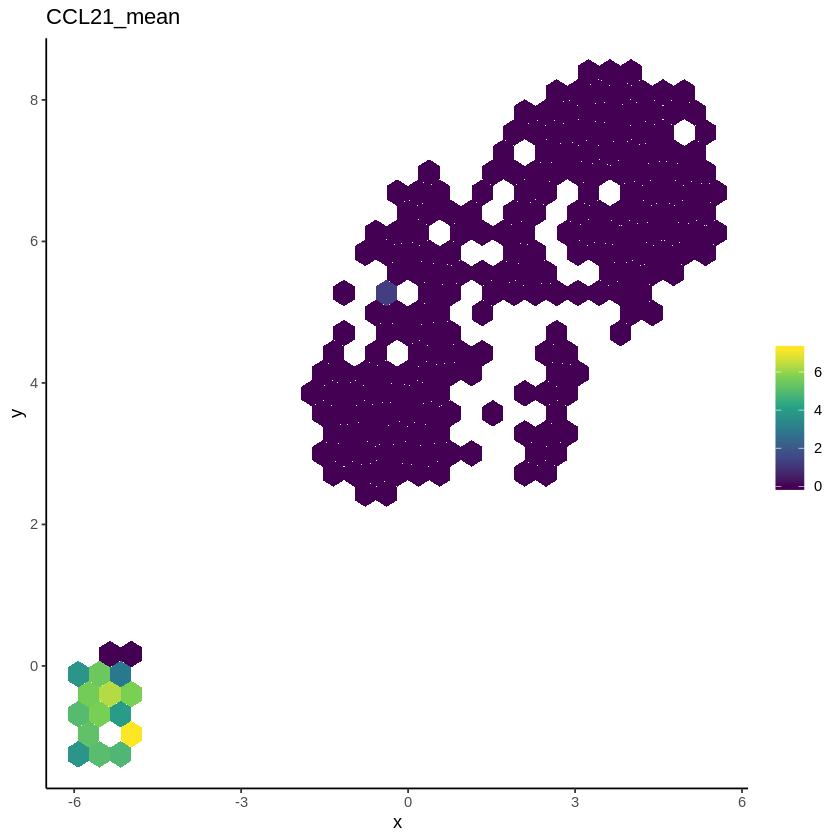

In [126]:
p1 <- plot_hexbin_gene(schex.endothelials,type = "logcounts", gene = 'CCL21', action = "mean")
plot(p1)

In [32]:
fibroblasts <- subset(data.integrated, idents = c(8,13,15))

endothelials <- subset(data.integrated, idents = 11)

macrophages <- subset(data.integrated, idents = 9)

epithelials <- subset(data.integrated, idents=c(3,6,12,14,17,19))

immunes <- subset(data.integrated, idents = c(0,1,2,4,5,7,10,16,18))

In [33]:
save(fibroblasts,file='N-stomach-fibroblasts.RData')
save(endothelials, file='N-stomach-endothelials.RData')
save(macrophages, file='N-stomach-macrophages.RData')
save(epithelials, file='N-stomach-epithelials.RData')
save(immunes, file='N-stomach-immunes.RData')

In [129]:
getwd()

[1] "/home/tsubosaka/stomach_normal_marker"

In [34]:
save(data.integrated, file='N-stomach-all.RData')

In [37]:
stomach.markers <- FindAllMarkers(object = data.integrated, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13
Calculating cluster 14
Calculating cluster 15
Calculating cluster 16
Calculating cluster 17
Calculating cluster 18
Calculating cluster 19


In [38]:
write.csv(stomach.markers, file='./seurat_object/stomach-all-marker.csv')

In [135]:
for (i in 0:19){
    print(stomach.markers %>% filter(p_val_adj < 0.05) %>% filter(cluster==i))
    print(' ')
    print(' ')
    print(' ')
}

           p_val avg_logFC pct.1 pct.2     p_val_adj cluster       gene
1   0.000000e+00 2.2527325 0.505 0.041  0.000000e+00       0      MS4A1
2   0.000000e+00 2.1747346 0.856 0.134  0.000000e+00       0    HLA-DRA
3   0.000000e+00 2.1642773 0.619 0.080  0.000000e+00       0   HLA-DPB1
4   0.000000e+00 2.1391350 0.833 0.226  0.000000e+00       0       CD74
5   0.000000e+00 2.0179240 0.754 0.144  0.000000e+00       0      CXCR4
6   0.000000e+00 2.0052854 0.575 0.102  0.000000e+00       0       CD37
7   0.000000e+00 1.9490630 0.396 0.043  0.000000e+00       0     VPREB3
8   0.000000e+00 1.9205441 0.489 0.083  0.000000e+00       0   HLA-DRB1
9   0.000000e+00 1.8636593 0.433 0.070  0.000000e+00       0   HLA-DPA1
10  0.000000e+00 1.8307790 0.310 0.025  0.000000e+00       0      BANK1
11  0.000000e+00 1.7422357 0.591 0.127  0.000000e+00       0       CD52
12  0.000000e+00 1.6712609 0.277 0.042  0.000000e+00       0   HLA-DQB1
13  0.000000e+00 1.6680241 0.251 0.022  0.000000e+00       0  LI